In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.stats import binned_statistic_2d


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate
from scipy import interpolate

import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the colormap
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')
SM_cmap = create_cyan_to_black_cmap(mcolors.to_rgb('coral'), 'black', cmap_name = 'SM_cmap')

In [3]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [4]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [5]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [6]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

In [7]:
dm_rd = [2.032, 0.118, 0.016, 1.172, 0.123, 0.026, 0.798, 0.121, 0.035, 0.598, 0.120, 0.044, 0.474, 0.119, 0.052]

In [8]:
# NEW background
m      = np.asarray([200, 200, 200, 250, 250, 250, 300, 300, 300, 350, 350, 350, 400, 400, 400])
deltam = np.asarray([34.4, 18.9, 9.9, 36.9, 21.7, 12.5, 39.2, 23.8, 14.7, 41.1, 25.5, 16.7, 42.7, 27.1, 19.3])

Z_base     = np.asarray([0.52, 1.19, 1.65 , 0.28, 0.61, 0.86, 0.17, 0.33, 0.46, 0.10, 0.19, 0.26, 0.05, 0.10, 0.14])

Z_BL0      = np.asarray([1.73, 4.83, 10.63, 1.08, 2.54, 5.16, 0.70, 1.49, 2.65, 0.45, 0.88, 1.46, 0.27, 0.51, 0.82])    # With individual training
Z_BL0_std  = np.asarray([0.81, 0.86, 0.89 , 0.92, 0.88, 0.86, 0.96, 0.88, 0.85, 0.98, 0.92, 0.89, 1.03, 0.99, 0.94]) # With individual training
Z_BL1      = np.asarray([1.63, 4.95, 9.88 , 1.04, 2.73, 5.23, 0.68, 1.67, 2.86, 0.44, 1.02, 1.65, 0.22, 0.56, 0.90])    # Without individual training
Z_BL1_std  = np.asarray([0.89, 0.88, 0.80 , 0.90, 0.87, 0.86, 0.98, 0.86, 0.86, 0.97, 0.90, 0.87, 1.20, 0.98, 0.96]) # Without individual training

Z_MLL0     = np.asarray([1.03, 5.35, 13.97, 1.06, 1.82, 7.46, 0.88, 1.22, 2.92, 0.24, 0.76, 1.91, 0.07, 0.40, 1.24])   # With individual training
Z_MLL0_std = np.asarray([1.79, 1.15, 1.12 , 1.40, 1.24, 1.09, 1.42, 1.09, 1.15, 1.26, 0.78, 1.03, 4.30, 1.33, 1.09]) # With individual training
Z_MLL1     = np.asarray([1.71, 5.80, 11.90, 1.02, 3.40, 6.67, 0.57, 2.17, 3.94, 0.50, 1.17, 2.19, 0.23, 0.58, 1.16])   # Without individual training
Z_MLL1_std = np.asarray([1.10, 1.10, 1.11 , 1.22, 1.04, 1.04, 1.57, 0.99, 0.98, 1.06, 1.00, 0.92, 1.31, 1.19, 0.90]) # Without individual training

Z_SCB0     = np.asarray([1.31, 2.78, 4.57 , 0.72, 2.41, 2.42, 0.79, 0.89, 1.42, 0.55, 0.62, 0.54, 0.86, 0.73, 0.89])    # With individual training
Z_SCB0_std = np.asarray([0.97, 0.94, 0.93 , 0.94, 0.89, 1.05, 0.98, 0.90, 0.93, 0.99, 0.98, 0.93, 0.98, 0.92, 0.94]) # With individual training
Z_SCB1     = np.asarray([0.54, 2.07, 4.41 , 0.35, 1.15, 2.27, 0.23, 0.68, 1.22, 0.16, 0.39, 0.69, 0.11, 0.23, 0.39])    # Without individual training
Z_SCB1_std = np.asarray([0.10, 0.18, 0.26 , 0.08, 0.14, 0.19, 0.06, 0.11, 0.14, 0.04, 0.08, 0.11, 0.03, 0.06, 0.08]) # Without individual training

In [9]:
#m      = np.asarray([200, 200, 200, 250, 250, 250, 300, 300, 300, 350, 350, 350, 400, 400, 400])
#deltam = np.asarray([34.4, 18.9, 9.9, 36.9, 21.7, 12.5, 39.2, 23.8, 14.7, 41.1, 25.5, 16.7, 42.7, 27.1, 19.3])
#
#Z_base     = np.asarray([0.58, 1.31, 1.82 , 0.31, 0.67, 0.95, 0.18, 0.37, 0.51, 0.11, 0.21, 0.29, 0.06, 0.11, 0.16])

#Z_BL0      = np.asarray([2.77, 5.94, 12.54, 1.68, 3.27, 6.25, 1.11, 1.96, 2.23, 0.84, 1.14, 1.86, 0.41, 0.72, 1.08])    # With individual training
#Z_BL0_std  = np.asarray([0.92, 0.8 , 0.76 , 0.84, 0.85, 0.87, 0.90, 0.90, 0.88, 0.80, 0.86, 0.83, 0.94, 0.92, 0.87]) # With individual training
#Z_BL1      = np.asarray([2.10, 5.71, 11.11, 1.37, 3.27, 5.91, 0.90, 1.97, 3.25, 0.59, 1.18, 1.89, 0.34, 0.69, 1.09])    # Without individual training
#Z_BL1_std  = np.asarray([0.85, 0.85, 0.92 , 0.85, 0.85, 0.87, 0.91, 0.84, 0.85, 0.93, 0.87, 0.84, 1.01, 0.94, 0.87]) # Without individual training

#Z_MLL0     = np.asarray([4.11, 6.99, 15.80, 3.04, 5.39, 8.64, 2.29, 3.04, 5.23, 1.38, 2.03, 3.08, 0.63, 1.32, 1.55])   # With individual training
#Z_MLL0_std = np.asarray([1.15, 1.36, 1.94 , 1.14, 1.21, 1.39, 1.17, 1.17, 1.13, 1.23, 1.20, 1.17, 1.82, 1.34, 1.32]) # With individual training
#Z_MLL1     = np.asarray([3.20, 7.71, 13.44, 2.10, 4.94, 8.04, 1.42, 3.24, 4.77, 0.75, 2.03, 2.92, 0.31, 1.01, 1.70])   # Without individual training
#Z_MLL1_std = np.asarray([1.12, 1.19, 1.27 , 1.12, 1.14, 1.19, 1.17, 1.18, 1.16, 2.00, 1.16, 1.13, 1.82, 1.26, 1.12]) # Without individual training

#Z_SCB0     = np.asarray([2.77, 5.04, 5.66 , 1.79, 3.61, 5.04, 0.66, 1.67, 2.47, 0.55, 0.88, 0.86, 0.54, 0.57, 0.64])    # With individual training
#Z_SCB0_std = np.asarray([1.11, 1.15, 0.89 , 1.06, 1.02, 1.15, 0.92, 1.01, 1.07, 0.87, 0.90, 0.87, 0.83, 0.84, 0.84]) # With individual training
#Z_SCB1     = np.asarray([1.08, 1.89, 2.47 , 0.73, 1.24, 1.52, 0.52, 0.82, 0.94, 0.37, 0.52, 0.60, 0.26, 0.34, 0.38])    # Without individual training
#Z_SCB1_std = np.asarray([0.20, 0.27, 0.30 , 0.17, 0.22, 0.24, 0.14, 0.17, 0.19, 0.11, 0.15, 0.16, 0.07, 0.11, 0.12]) # Without individual training

In [10]:
# NEW background
Z_base_MET200     = np.asarray([0.50, 1.27, 2.13 , 0.30, 0.69, 1.10, 0.19, 0.40, 0.60, 0.12, 0.23, 0.34, 0.07, 0.13, 0.19])

Z_BL0_MET200      = np.asarray([1.70, 4.60, 11.02, 1.14, 2.65, 5.62, 0.77, 1.62, 3.02, 0.54, 1.02, 1.73, 0.35, 0.62, 1.00]) # With individual training
Z_BL0_MET200_std  = np.asarray([0.82, 0.81, 0.89 , 0.82, 0.79, 0.82, 0.85, 0.79, 0.79, 0.86, 0.81, 0.78, 0.88, 0.85, 0.80]) # With individual training
Z_BL1_MET200      = np.asarray([1.54, 4.63, 9.82 , 1.07, 2.84, 5.44, 0.75, 1.81, 3.13, 0.53, 1.16, 1.88, 0.34, 0.72, 1.14]) # Without individual training
Z_BL1_MET200_std  = np.asarray([0.81, 0.85, 0.90 , 0.82, 0.80, 0.83, 0.85, 0.80, 0.80, 0.86, 0.79, 0.80, 0.87, 0.84, 0.81]) # Without individual training

Z_MLL0_MET200     = np.asarray([1.93, 6.23, 12.59, 1.38, 4.87, 7.60, 0.75, 2.46, 4.09, 0.46, 2.00, 2.93, 0.15, 0.76, 1.34]) # With individual training
Z_MLL0_MET200_std = np.asarray([1.37, 1.43, 1.14 , 1.76, 1.70, 1.14, 1.81, 1.43, 1.14, 1.18, 1.70, 1.28, 3.96, 1.35, 2.90]) # With individual training
Z_MLL1_MET200     = np.asarray([0.91, 4.75, 10.91, 0.73, 2.97, 6.50, 0.53, 1.79, 3.80, 0.23, 1.09, 2.18, 0.09, 0.85, 1.31]) # Without individual training
Z_MLL1_MET200_std = np.asarray([1.75, 1.20, 1.21 , 1.78, 1.11, 1.24, 3.95, 1.32, 1.20, 5.99, 1.58, 1.31, 7.55, 1.99, 1.83]) # Without individual training

Z_SCB0_MET200     = np.asarray([0.90, 3.49, 3.35 , 1.07, 2.12, 2.40, 0.49, 1.25, 1.56, 0.49, 0.89, 0.50, 0.54, 0.50, 0.57]) # With individual training
Z_SCB0_MET200_std = np.asarray([0.88, 0.97, 0.91 , 0.89, 0.79, 0.78, 0.77, 0.80, 0.80, 0.74, 0.87, 0.79, 0.85, 0.78, 0.83]) # With individual training
Z_SCB1_MET200     = np.asarray([0.62, 2.06, 4.12 , 0.40, 1.16, 2.13, 0.26, 0.68, 1.16, 0.18, 0.42, 0.66, 0.13, 0.24, 0.38]) # Without individual training
Z_SCB1_MET200_std = np.asarray([0.10, 0.19, 0.27 , 0.08, 0.15, 0.20, 0.07, 0.11, 0.14, 0.05, 0.09, 0.11, 0.03, 0.06, 0.08]) # Without individual training

In [11]:
#Z_base_MET200     = np.asarray([0.53, 1.37, 2.29 , 0.32, 0.74, 1.19, 0.21, 0.43, 0.64, 0.13, 0.25, 0.37, 0.07, 0.14, 0.21])

#Z_BL0_MET200      = np.asarray([2.80, 5.81, 12.84, 1.95, 3.44, 6.67, 1.43, 2.21, 3.73, 0.84, 1.14, 1.86, 0.41, 0.72, 1.08]) # With individual training
#Z_BL0_MET200_std  = np.asarray([0.76, 0.8 , 0.89 , 0.80, 0.79, 0.83, 0.80, 0.77, 0.70, 0.80, 0.86, 0.83, 0.94, 0.92, 0.87]) # With individual training
#Z_BL1_MET200      = np.asarray([2.12, 5.49, 11.04, 1.51, 3.46, 6.24, 1.09, 2.21, 3.66, 0.77, 1.43, 2.25, 0.48, 0.91, 1.35]) # Without individual training
#Z_BL1_MET200_std  = np.asarray([0.75, 0.81, 0.90 , 0.74, 0.77, 0.83, 0.74, 0.74, 0.78, 0.76, 0.74, 0.74, 0.77, 0.72, 0.73]) # Without individual training

#Z_MLL0_MET200     = np.asarray([3.62, 7.89, 13.82, 2.86, 5.31, 7.62, 2.24, 3.33, 4.89, 1.38, 2.03, 3.08, 0.63, 1.32, 1.55]) # With individual training
#Z_MLL0_MET200_std = np.asarray([1.23, 1.47, 1.18 , 1.41, 1.49, 1.18, 1.47, 1.22, 1.16, 1.23, 1.20, 1.17, 1.82, 1.34, 1.32]) # With individual training
#Z_MLL1_MET200     = np.asarray([2.94, 7.31, 12.53, 2.19, 4.94, 7.75, 1.53, 3.37, 5.00, 1.01, 2.23, 3.24, 0.46, 1.33, 1.99]) # Without individual training
#Z_MLL1_MET200_std = np.asarray([1.17, 1.26, 1.33 , 1.19, 1.22, 1.27, 1.22, 1.23, 1.23, 1.30, 1.20, 1.23, 1.76, 1.23, 1.23]) # Without individual training

#Z_SCB0_MET200     = np.asarray([2.38, 3.28, 5.87 , 2.01, 3.18, 2.94, 1.39, 1.68, 1.62, 0.55, 0.88, 0.86, 0.54, 0.57, 0.64]) # With individual training
#Z_SCB0_MET200_std = np.asarray([0.98, 0.90, 0.82 , 0.81, 1.00, 0.74, 0.75, 0.80, 0.67, 0.87, 0.90, 0.87, 0.83, 0.84, 0.84]) # With individual training
#Z_SCB1_MET200     = np.asarray([0.63, 2.03, 3.99 , 0.42, 1.16, 2.12, 0.27, 0.68, 1.15, 0.19, 0.42, 0.67, 0.13, 0.25, 0.38]) # Without individual training
#Z_SCB1_MET200_std = np.asarray([0.11, 0.19, 0.27 , 0.09, 0.15, 0.19, 0.07, 0.11, 0.14, 0.05, 0.08, 0.12, 0.03, 0.07, 0.09]) # Without individual training

In [12]:
ATLAS = np.loadtxt('../data/LHC/ATLAS.txt')
CMS   = np.loadtxt('../data/LHC/CMS.txt')

## SM

In [13]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

Wgamma_cross = 0.944 * 1000 #[fb]
Wgamma_NLO   = 2.37 # k-factor [14 TeV]

Wjets_cross = 168.12 * 1000 #[fb]
Wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [14]:
Wgamma_fidcross  = 584.6234
Wjets_fidcross   = 600.5788
ttgamma_fidcross = 24.98413

ttjets_fidcross  = 180.510721
zjets_fidcross   = 33.609922
wz_fidcross      = 6.740334
zz_fidcross      = 0.843997
ww_fidcross      = 15.8203
tj_fidcross      = 7.9070
tb_fidcross      = 11.52578
tw_fidcross      = 12.72042

B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross + \
                   ttjets_fidcross + zjets_fidcross + wz_fidcross  + \
                   zz_fidcross + ww_fidcross + tj_fidcross + \
                   tb_fidcross + tw_fidcross 
B_fidcross_tot

1479.8648040000003

In [15]:
Wgamma_aceptancia_init  = Wgamma_fidcross / (Wgamma_cross * Wgamma_NLO)
Wjets_aceptancia_init   = Wjets_fidcross / (Wjets_cross * Wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [16]:
Wgamma_expected  = 58462.34
Wjets_expected   = 60057.88
ttgamma_expected = 2498.413

ttjets_expected  = 18051.0721
zjets_expected   = 3360.9922
wz_expected      = 674.0334
zz_expected      = 84.3997
ww_expected      = 1582.03
tj_expected      = 790.70
tb_expected      = 1152.578
tw_expected      = 1272.042

B_expected = ttgamma_expected + Wjets_expected + Wgamma_expected + ttjets_expected + \
             zjets_expected + wz_expected + zz_expected + ww_expected + \
             tj_expected + tb_expected + tw_expected

print(B_expected)

147986.4804


In [17]:
sample = 200_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

79010
81167
3377
24396
4542
911
114
2138
1069
1558
1719


In [18]:
##############
# input data #
##############

# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_4.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_4.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_4.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_4.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_4.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_4.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_4.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_4.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_4.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_4.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_4.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_4.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_4.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_4.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_4.dat', delimiter=' ')

# tt  jet #

datFolderttjets = '../data/ttjets/'
 
photon_ttjets  = np.loadtxt(datFolderttjets + 'photon_4.dat', delimiter=' ')
jet_ttjets     = np.loadtxt(datFolderttjets + 'jet_4.dat', delimiter=' ')
lepton_ttjets  = np.loadtxt(datFolderttjets + 'lepton_4.dat', delimiter=' ')
MET_ttjets     = np.loadtxt(datFolderttjets + 'MET_4.dat', delimiter=' ')
hadinfo_ttjets = np.loadtxt(datFolderttjets + 'hadinfo_4.dat', delimiter=' ')

# z jet # rama leptonica

datFolderzjets = '../data/Zlep+j/'
 
photon_zjets  = np.loadtxt(datFolderzjets + 'photon_4.dat', delimiter=' ')
jet_zjets     = np.loadtxt(datFolderzjets + 'jet_4.dat', delimiter=' ')
lepton_zjets  = np.loadtxt(datFolderzjets + 'lepton_4.dat', delimiter=' ')
MET_zjets     = np.loadtxt(datFolderzjets + 'MET_4.dat', delimiter=' ')
hadinfo_zjets = np.loadtxt(datFolderzjets + 'hadinfo_4.dat', delimiter=' ')

# wz #

datFolderwz = '../data/wz/'
 
photon_wz  = np.loadtxt(datFolderwz + 'photon_4.dat', delimiter=' ')
jet_wz     = np.loadtxt(datFolderwz + 'jet_4.dat', delimiter=' ')
lepton_wz  = np.loadtxt(datFolderwz + 'lepton_4.dat', delimiter=' ')
MET_wz     = np.loadtxt(datFolderwz + 'MET_4.dat', delimiter=' ')
hadinfo_wz = np.loadtxt(datFolderwz + 'hadinfo_4.dat', delimiter=' ')

# ww #

datFolderww = '../data/ww/'
 
photon_ww  = np.loadtxt(datFolderww + 'photon_4.dat', delimiter=' ')
jet_ww     = np.loadtxt(datFolderww + 'jet_4.dat', delimiter=' ')
lepton_ww  = np.loadtxt(datFolderww + 'lepton_4.dat', delimiter=' ')
MET_ww     = np.loadtxt(datFolderww + 'MET_4.dat', delimiter=' ')
hadinfo_ww = np.loadtxt(datFolderww + 'hadinfo_4.dat', delimiter=' ')

# zz #

datFolderzz = '../data/zz/'
 
photon_zz  = np.loadtxt(datFolderzz + 'photon_4.dat', delimiter=' ')
jet_zz     = np.loadtxt(datFolderzz + 'jet_4.dat', delimiter=' ')
lepton_zz  = np.loadtxt(datFolderzz + 'lepton_4.dat', delimiter=' ')
MET_zz     = np.loadtxt(datFolderzz + 'MET_4.dat', delimiter=' ')
hadinfo_zz = np.loadtxt(datFolderzz + 'hadinfo_4.dat', delimiter=' ')

# tj #

datFoldertj = '../data/singleTop+j/'
 
photon_tj  = np.loadtxt(datFoldertj + 'photon_4.dat', delimiter=' ')
jet_tj     = np.loadtxt(datFoldertj + 'jet_4.dat', delimiter=' ')
lepton_tj  = np.loadtxt(datFoldertj + 'lepton_4.dat', delimiter=' ')
MET_tj     = np.loadtxt(datFoldertj + 'MET_4.dat', delimiter=' ')
hadinfo_tj = np.loadtxt(datFoldertj + 'hadinfo_4.dat', delimiter=' ')

# tb #

datFoldertb = '../data/singleTop+b/'
 
photon_tb  = np.loadtxt(datFoldertb + 'photon_4.dat', delimiter=' ')
jet_tb     = np.loadtxt(datFoldertb + 'jet_4.dat', delimiter=' ')
lepton_tb  = np.loadtxt(datFoldertb + 'lepton_4.dat', delimiter=' ')
MET_tb     = np.loadtxt(datFoldertb + 'MET_4.dat', delimiter=' ')
hadinfo_tb = np.loadtxt(datFoldertb + 'hadinfo_4.dat', delimiter=' ')

# tw #

datFoldertw = '../data/singleTop+W/'
 
photon_tw  = np.loadtxt(datFoldertw + 'photon_4.dat', delimiter=' ')
jet_tw     = np.loadtxt(datFoldertw + 'jet_4.dat', delimiter=' ')
lepton_tw  = np.loadtxt(datFoldertw + 'lepton_4.dat', delimiter=' ')
MET_tw     = np.loadtxt(datFoldertw + 'MET_4.dat', delimiter=' ')
hadinfo_tw = np.loadtxt(datFoldertw + 'hadinfo_4.dat', delimiter=' ')

In [19]:
photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample],
                             photon_ttjets[:ttjets_sample], photon_zjets[:zjets_sample], photon_wz[:wz_sample],
                             photon_zz[:zz_sample], photon_ww[:ww_sample], photon_tj[:tj_sample],
                             photon_tb[:tb_sample], photon_tw[:tw_sample]
                            ])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample],
                             jet_ttjets[:ttjets_sample], jet_zjets[:zjets_sample], jet_wz[:wz_sample],
                             jet_zz[:zz_sample], jet_ww[:ww_sample], jet_tj[:tj_sample],
                             jet_tb[:tb_sample], jet_tw[:tw_sample]
                            ]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample],
                             lepton_ttjets[:ttjets_sample], lepton_zjets[:zjets_sample], lepton_wz[:wz_sample],
                             lepton_zz[:zz_sample], lepton_ww[:ww_sample], lepton_tj[:tj_sample],
                             lepton_tb[:tb_sample], lepton_tw[:tw_sample]
                            ])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample],
                             MET_ttjets[:ttjets_sample], MET_zjets[:zjets_sample], MET_wz[:wz_sample],
                             MET_zz[:zz_sample], MET_ww[:ww_sample], MET_tj[:tj_sample],
                             MET_tb[:tb_sample], MET_tw[:tw_sample]
                            ])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample],
                             hadinfo_ttjets[:ttjets_sample], hadinfo_zjets[:zjets_sample], hadinfo_wz[:wz_sample],
                             hadinfo_zz[:zz_sample], hadinfo_ww[:ww_sample], hadinfo_tj[:tj_sample],
                             hadinfo_tb[:tb_sample], hadinfo_tw[:tw_sample]
                            ])

In [20]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1

init_ind = Wgamma_sample
end_ind  = Wgamma_sample + Wjets_sample
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_sample
bkg_flag[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_sample
bkg_flag[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_sample
bkg_flag[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_sample
bkg_flag[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_sample
bkg_flag[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_sample
bkg_flag[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_sample
bkg_flag[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_sample
bkg_flag[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_sample
bkg_flag[(init_ind):(end_ind)] = 11

In [21]:
wjets_pool  = len(photon_Wjets[Wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / Wjets_fidcross)

Wgamma_pool_sample  = int(round(pool_sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_pool_sample   = int(round(pool_sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_pool_sample)
print(Wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

173444
178178
7412
53553
9971
2000
250
4694
2346
3419
1719


In [22]:
photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  photon_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  photon_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  photon_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  photon_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  photon_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  photon_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  photon_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  photon_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  photon_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  photon_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  jet_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  jet_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  jet_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  jet_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  jet_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  jet_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  jet_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  jet_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  jet_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  jet_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ]) 

lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  lepton_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  lepton_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  lepton_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  lepton_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  lepton_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  lepton_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  lepton_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  lepton_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  lepton_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  lepton_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  MET_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  MET_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  MET_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  MET_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  MET_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  MET_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  MET_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  MET_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  MET_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  MET_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  hadinfo_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  hadinfo_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  hadinfo_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  hadinfo_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  hadinfo_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  hadinfo_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  hadinfo_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  hadinfo_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  hadinfo_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  hadinfo_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])


In [23]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

bkg_flag_pool[:Wgamma_pool_sample] = 1

init_ind = Wgamma_pool_sample
end_ind  = Wgamma_pool_sample + Wjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 11

In [24]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(259345, 4)
(2710879, 4)
(3579946, 4)
(92997, 4)
(15123, 4)
(9246, 4)
(2501, 4)
(27629, 4)
(4804, 4)
(5969, 4)
(17655, 4)


### Other variables

In [25]:
ST_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0], np.sqrt(hadinfo_Wgamma[:,0]) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

In [26]:
ST_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(hadinfo_Wjets[:,0]) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )

In [27]:
ST_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(hadinfo_ttgamma[:,0]) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )

In [28]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [29]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## NP

In [30]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_5.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_5.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_5.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_5.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_5.dat', delimiter=' ') )

In [31]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (200001, 5)
BP1 (524041, 5)
BP2 (492157, 5)
BP3 (414951, 5)
BP4 (603424, 5)
BP5 (533112, 5)
BP6 (406048, 5)
BP7 (631234, 5)
BP8 (560590, 5)
BP9 (451741, 5)
BP10 (652300, 5)
BP11 (583750, 5)
BP12 (488317, 5)
BP13 (670737, 5)
BP14 (602479, 5)
BP15 (516051, 5)


In [32]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([1836673, 2e6, 2400081, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6])
#signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277]) #OLD
signal_cut_ev       = np.asarray([524041, 492157, 414951, 603424, 533112, 406048, 631234, 560590, 451741, 652300, 583750, 488317, 670737, 602479, 516051])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [2.02450796 4.59030589 6.36297195 1.11064713 2.35495829 3.33821603
 0.66005614 1.29200298 1.79306845 0.39933235 0.73575485 1.01992452
 0.22901644 0.41142086 0.57265147]
Events expected:  [202.4507965  459.03058905 636.29719543 111.06471288 235.49582866
 333.82160293  66.00561444 129.20029848 179.30684468  39.93323524
  73.57548516 101.99245228  22.90164413  41.14208595  57.26514737]


In [33]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [34]:
print(photon_SM.shape)
print(photon_NP[0].shape)

(200001, 4)
(524041, 4)


# Analysis

## training

In [35]:
Z_BL_loops      = list(np.load('../data/temp_Z_BL_loops_ar.npy'))
Z_BL_std_loops  = list(np.load('../data/temp_Z_BL_std_loops_ar.npy'))
muhat_BL_loops  = list(np.load('../data/temp_muhat_BL_loops_ar.npy'))
Z_MLL_loops     = list(np.load('../data/temp_Z_MLL_loops_ar.npy'))
Z_MLL_std_loops = list(np.load('../data/temp_Z_MLL_std_loops_ar.npy'))
muhat_MLL_loops = list(np.load('../data/temp_muhat_MLL_loops_ar.npy'))

In [36]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

In [37]:
nobs = len(photon_SM)
#BPS_trained = np.asarray([0]) #np.arange(15)
BPS_trained = np.arange(15)
nobs_bp = round(nobs / len(BPS_trained))

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df = pd.DataFrame()

np.random.seed(28890)

mask_list = []
for bp in BPS_trained:
    print(bp)
    BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = nobs_bp, replace = False)
    mask = np.ones(len(photon_NP[bp]), dtype=bool)
    mask[BP_indices] = False
    mask_list.append( mask )
    
    if bp == 0:
        
        df[lst[0]] = np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][BP_indices,0]])
        df[lst[1]] = np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][BP_indices,1]])
        df[lst[2]] = np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][BP_indices,2]])
        df[lst[3]] = np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][BP_indices,3]])

        df[lst[4]] = np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][BP_indices,0]])
        df[lst[5]] = np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][BP_indices,1]])
        df[lst[6]] = np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][BP_indices,2]])

        df[lst[7]] = np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][BP_indices,0]])
        df[lst[8]] = np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][BP_indices,1]])
        df[lst[9]] = np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][BP_indices,2]])
        df[lst[10]] = np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][BP_indices,3]])
        df[lst[11]] = np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][BP_indices,4]])

        df[lst[12]] = np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][BP_indices,0]])
        df[lst[13]] = np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][BP_indices,2]])

        df[lst[14]] = np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][BP_indices,0]])
        df[lst[15]] = np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][BP_indices,1]])
        df[lst[16]] = np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][BP_indices,2]])

        df[lst[17]] = np.concatenate([ST_SM[SM_indices], ST_NP[bp][BP_indices]])
        df[lst[18]] = np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][BP_indices]])

        df[lst[19]] = np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][BP_indices]])
        df[lst[20]] = np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][BP_indices]])
        df[lst[21]] = np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][BP_indices]])


        df['bkg_flag'] = np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][BP_indices]))) )

        df[lst[22]] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices]))])
        
        df['bp_flag'] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) ])
    else:
        df_aux = pd.DataFrame()
        
        df_aux[lst[0]] = photon_NP[bp][BP_indices,0] 
        df_aux[lst[1]] = photon_NP[bp][BP_indices,1] 
        df_aux[lst[2]] = photon_NP[bp][BP_indices,2] 
        df_aux[lst[3]] = photon_NP[bp][BP_indices,3] 

        df_aux[lst[4]] = jet_NP[bp][BP_indices,0] 
        df_aux[lst[5]] = jet_NP[bp][BP_indices,1] 
        df_aux[lst[6]] = jet_NP[bp][BP_indices,2] 

        df_aux[lst[7]] = lepton_NP[bp][BP_indices,0] 
        df_aux[lst[8]] = lepton_NP[bp][BP_indices,1] 
        df_aux[lst[9]] = lepton_NP[bp][BP_indices,2] 
        df_aux[lst[10]] = lepton_NP[bp][BP_indices,3] 
        df_aux[lst[11]] = lepton_NP[bp][BP_indices,4] 

        df_aux[lst[12]] = MET_NP[bp][BP_indices,0] 
        df_aux[lst[13]] = MET_NP[bp][BP_indices,2] 

        df_aux[lst[14]] = hadinfo_NP[bp][BP_indices,0] 
        df_aux[lst[15]] = hadinfo_NP[bp][BP_indices,1] 
        df_aux[lst[16]] = hadinfo_NP[bp][BP_indices,2] 

        df_aux[lst[17]] = ST_NP[bp][BP_indices] 
        df_aux[lst[18]] = MET_sig_NP[bp][BP_indices] 

        df_aux[lst[19]] = mT_photon_NP[bp][BP_indices] 
        df_aux[lst[20]] = mT_jet_NP[bp][BP_indices] 
        df_aux[lst[21]] = mT_lepton_NP[bp][BP_indices] 


        df_aux['bkg_flag'] = np.zeros(len(photon_NP[bp][BP_indices]))

        df_aux[lst[22]] = np.ones(len(photon_NP[bp][BP_indices]))
        df_aux['bp_flag'] = np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) 
        
        df = pd.concat((df, df_aux))
df_array = np.asarray(df)
df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1,bp_flag
0,24.52,-2.140,2.075,1.0,375.62,-1.429,-0.797,155.35,-1.386,2.046,...,424.97,2.0,555.49,10.024602,25.848172,608.306992,70.651093,1.0,0.0,0.0
1,107.50,-1.181,-2.628,1.0,169.90,-2.745,0.112,19.63,0.440,-2.367,...,385.86,4.0,297.03,6.003722,161.631535,262.088246,78.482619,3.0,0.0,0.0
2,48.96,0.501,0.164,1.0,226.34,0.954,-2.489,51.02,-1.619,0.895,...,226.34,1.0,326.32,7.543596,46.870222,350.862504,12.412373,1.0,0.0,0.0
3,10.94,0.369,0.711,1.0,161.79,1.069,-2.416,24.01,-0.139,-0.608,...,161.79,1.0,196.74,10.333369,7.514810,305.103066,80.766592,2.0,0.0,0.0
4,15.56,-0.133,-2.150,1.0,173.79,-0.776,1.998,11.74,1.075,1.257,...,395.61,3.0,201.09,6.924462,75.156519,287.116804,57.452311,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13328,26.06,-1.853,-2.674,1.0,272.59,-0.736,-0.252,10.34,0.254,1.239,...,397.43,2.0,308.99,17.704034,50.420097,630.941018,98.627239,0.0,1.0,15.0
13329,33.05,0.968,2.047,1.0,120.18,-1.909,-0.132,12.40,0.312,-1.852,...,265.44,3.0,165.63,13.394908,88.870117,336.599847,66.794468,0.0,1.0,15.0
13330,16.52,1.158,-1.111,1.0,256.16,-0.051,2.459,18.74,0.246,0.212,...,337.27,2.0,291.42,7.998016,31.195065,395.731726,36.633209,0.0,1.0,15.0
13331,27.98,-0.533,-0.367,1.0,102.92,2.176,2.588,22.51,0.661,2.476,...,130.21,2.0,153.41,8.417352,3.712926,214.108669,99.263245,0.0,1.0,15.0


In [38]:
print('There are ' + str(len(np.where(df_array[:,24] == 0)[0])) + ' bkg events')
for i in np.arange(15):
    print('There are ' + str(len(np.where(df_array[:,24] == (i+1))[0])) + ' BP' + str(i+1) + ' events')

There are 200001 bkg events
There are 13333 BP1 events
There are 13333 BP2 events
There are 13333 BP3 events
There are 13333 BP4 events
There are 13333 BP5 events
There are 13333 BP6 events
There are 13333 BP7 events
There are 13333 BP8 events
There are 13333 BP9 events
There are 13333 BP10 events
There are 13333 BP11 events
There are 13333 BP12 events
There are 13333 BP13 events
There are 13333 BP14 events
There are 13333 BP15 events


In [39]:
SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

#BPS_analyzed = np.asarray([0])
BPS_analyzed = np.arange(15)

df_test = pd.DataFrame()

for bp in BPS_analyzed:
    if bp in BPS_trained:
        mask = mask_list[np.where(BPS_trained == bp)[0][0]]
        mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 75000
    else:
        BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = 15_000, replace = False)
        mask = np.zeros(len(photon_NP[bp]), dtype=bool)
        mask[BP_indices] = True
    print(bp)
    #mask = mask_list[bp]
    #mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 15000
    if bp == 0:
        
        df_test[lst[0]] = np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][mask,0]])
        df_test[lst[1]] = np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][mask,1]])
        df_test[lst[2]] = np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][mask,2]])
        df_test[lst[3]] = np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][mask,3]])

        df_test[lst[4]] = np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][mask,0]])
        df_test[lst[5]] = np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][mask,1]])
        df_test[lst[6]] = np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][mask,2]])

        df_test[lst[7]] = np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][mask,0]])
        df_test[lst[8]] = np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][mask,1]])
        df_test[lst[9]] = np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][mask,2]])
        df_test[lst[10]] = np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][mask,3]])
        df_test[lst[11]] = np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][mask,4]])

        df_test[lst[12]] = np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][mask,0]])
        df_test[lst[13]] = np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][mask,2]])

        df_test[lst[14]] = np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][mask,0]])
        df_test[lst[15]] = np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][mask,1]])
        df_test[lst[16]] = np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][mask,2]])

        df_test[lst[17]] = np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][mask]])
        df_test[lst[18]] = np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][mask]])

        df_test[lst[19]] = np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][mask]])
        df_test[lst[20]] = np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][mask]])
        df_test[lst[21]] = np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][mask]])


        df_test['bkg_flag_pool'] = np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][mask]))) )

        df_test[lst[22]] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask]))])
        
        df_test['bp_flag'] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask])) * (bp+1) ])
        
    else:
        df_aux = pd.DataFrame()
        
        df_aux[lst[0]] = photon_NP[bp][mask,0] 
        df_aux[lst[1]] = photon_NP[bp][mask,1] 
        df_aux[lst[2]] = photon_NP[bp][mask,2] 
        df_aux[lst[3]] = photon_NP[bp][mask,3] 

        df_aux[lst[4]] = jet_NP[bp][mask,0] 
        df_aux[lst[5]] = jet_NP[bp][mask,1] 
        df_aux[lst[6]] = jet_NP[bp][mask,2] 

        df_aux[lst[7]] = lepton_NP[bp][mask,0] 
        df_aux[lst[8]] = lepton_NP[bp][mask,1] 
        df_aux[lst[9]] = lepton_NP[bp][mask,2] 
        df_aux[lst[10]] = lepton_NP[bp][mask,3] 
        df_aux[lst[11]] = lepton_NP[bp][mask,4] 

        df_aux[lst[12]] = MET_NP[bp][mask,0] 
        df_aux[lst[13]] = MET_NP[bp][mask,2] 

        df_aux[lst[14]] = hadinfo_NP[bp][mask,0] 
        df_aux[lst[15]] = hadinfo_NP[bp][mask,1] 
        df_aux[lst[16]] = hadinfo_NP[bp][mask,2] 

        df_aux[lst[17]] = ST_NP[bp][mask] 
        df_aux[lst[18]] = MET_sig_NP[bp][mask] 

        df_aux[lst[19]] = mT_photon_NP[bp][mask] 
        df_aux[lst[20]] = mT_jet_NP[bp][mask] 
        df_aux[lst[21]] = mT_lepton_NP[bp][mask] 


        df_aux['bkg_flag_pool'] = np.zeros(len(photon_NP[bp][mask]))

        df_aux[lst[22]] = np.ones(len(photon_NP[bp][mask]))
        
        df_aux['bp_flag'] = np.ones(len(photon_NP[bp][mask])) * (bp+1)
        
        df_test = pd.concat((df_test, df_aux))
df_test_array = np.asarray(df_test)
df_test

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1,bp_flag
0,15.40,-1.028,-3.076,1.0,131.76,2.148,-2.957,21.98,2.319,-2.151,...,354.68,5.0,169.14,6.360444,81.238720,243.125215,104.998946,4.0,0.0,0.0
1,17.37,0.602,0.970,1.0,219.74,-1.177,-1.738,14.43,-1.105,0.476,...,484.15,6.0,251.54,10.527621,53.968127,447.884809,73.781980,3.0,0.0,0.0
2,17.84,-0.701,2.325,1.0,170.47,-0.678,-1.978,11.70,-1.531,-0.776,...,260.29,3.0,200.01,9.449382,43.051972,326.581972,78.731413,1.0,0.0,0.0
3,15.11,0.571,-1.295,1.0,155.39,-0.229,-1.635,34.90,1.053,2.527,...,210.13,2.0,205.40,6.272139,77.736313,253.470230,59.951963,4.0,0.0,0.0
4,19.33,1.972,-0.890,1.0,257.80,-0.290,2.609,205.06,0.393,-0.890,...,567.12,7.0,482.19,4.183582,4.863132,345.548275,15.839468,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97388,12.71,-0.460,-2.513,1.0,288.57,0.160,1.497,14.34,0.670,-0.358,...,613.53,3.0,315.62,22.609529,48.446677,804.056239,128.633118,0.0,1.0,15.0
97389,22.01,0.415,0.023,1.0,112.28,0.222,-2.141,10.74,2.030,-2.725,...,112.28,1.0,145.03,8.321065,49.438753,221.273922,64.755999,0.0,1.0,15.0
97390,12.70,0.341,1.816,1.0,236.50,-0.738,-0.393,18.87,0.253,2.557,...,385.07,2.0,268.07,16.560060,68.939113,563.305950,29.146284,0.0,1.0,15.0
97391,19.61,-1.206,-2.516,1.0,186.68,2.002,-1.816,22.22,-0.040,1.132,...,427.59,5.0,228.51,8.678534,99.458964,361.997426,45.298294,0.0,1.0,15.0


In [40]:
print('There are ' + str(len(np.where(df_test_array[:,24] == 0)[0])) + ' bkg events')
for i in np.arange(15):
    print('There are ' + str(len(np.where(df_test_array[:,24] == (i+1))[0])) + ' BP' + str(i+1) + ' events')

There are 439041 bkg events
There are 97516 BP1 events
There are 97313 BP2 events
There are 96750 BP3 events
There are 97821 BP4 events
There are 97525 BP5 events
There are 96780 BP6 events
There are 97802 BP7 events
There are 97642 BP8 events
There are 97030 BP9 events
There are 97920 BP10 events
There are 97719 BP11 events
There are 97305 BP12 events
There are 98028 BP13 events
There are 97831 BP14 events
There are 97393 BP15 events


In [41]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [42]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [43]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [44]:
print('y:', df.columns[-2]) # Just to check

y: SM=0 - NP=1


In [45]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -2]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -2]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -2]

In [46]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma
ind_ttjets_train  = np.where(bkg_flag_train == 4)[0] # tt jets
ind_zjets_train   = np.where(bkg_flag_train == 5)[0] # zjets
ind_wz_train      = np.where(bkg_flag_train == 6)[0] # wz
ind_zz_train      = np.where(bkg_flag_train == 7)[0] # zz
ind_ww_train      = np.where(bkg_flag_train == 8)[0] # ww
ind_tj_train      = np.where(bkg_flag_train == 9)[0] # tj
ind_tb_train      = np.where(bkg_flag_train == 10)[0] # tb
ind_tw_train      = np.where(bkg_flag_train == 11)[0] # tw

if(len(ind_signal_train) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_train), S_expected[bp]))

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))
if(len(ind_ttjets_train) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_train), ttjets_expected))
if(len(ind_zjets_train) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_train), zjets_expected))
if(len(ind_wz_train) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_train), wz_expected))
if(len(ind_zz_train) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_train), zz_expected))
if(len(ind_ww_train) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_train), ww_expected))
if(len(ind_tj_train) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_train), tj_expected))
if(len(ind_tb_train) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_train), tb_expected))
if(len(ind_tw_train) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_train), tw_expected))

In [47]:
ind_signal_test  = np.where(bkg_flag_test == 0)[0]
ind_wgamma_test  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets_test   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma_test = np.where(bkg_flag_test == 3)[0] # tt gamma
ind_ttjets_test  = np.where(bkg_flag_test == 4)[0] # tt jets
ind_zjets_test   = np.where(bkg_flag_test == 5)[0] # zjets
ind_wz_test      = np.where(bkg_flag_test == 6)[0] # wz
ind_zz_test      = np.where(bkg_flag_test == 7)[0] # zz
ind_ww_test      = np.where(bkg_flag_test == 8)[0] # ww
ind_tj_test      = np.where(bkg_flag_test == 9)[0] # tj
ind_tb_test      = np.where(bkg_flag_test == 10)[0] # tb
ind_tw_test      = np.where(bkg_flag_test == 11)[0] # tw

if(len(ind_signal_test) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_test), S_expected[bp]))

if(len(ind_wgamma_test) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_test), Wgamma_expected))
if(len(ind_ttgamma_test) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_test), ttgamma_expected))
if(len(ind_wjets_test) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_test), Wjets_expected))
if(len(ind_ttjets_test) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_test), ttjets_expected))
if(len(ind_zjets_test) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_test), zjets_expected))
if(len(ind_wz_test) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_test), wz_expected))
if(len(ind_zz_test) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_test), zz_expected))
if(len(ind_ww_test) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_test), ww_expected))
if(len(ind_tj_test) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_test), tj_expected))
if(len(ind_tb_test) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_test), tb_expected))
if(len(ind_tw_test) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_test), tw_expected))

In [48]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma
ind_ttjets  = np.where(bkg_flag_val == 4)[0] # tt jets
ind_zjets   = np.where(bkg_flag_val == 5)[0] # zjets
ind_wz      = np.where(bkg_flag_val == 6)[0] # wz
ind_zz      = np.where(bkg_flag_val == 7)[0] # zz
ind_ww      = np.where(bkg_flag_val == 8)[0] # ww
ind_tj      = np.where(bkg_flag_val == 9)[0] # tj
ind_tb      = np.where(bkg_flag_val == 10)[0] # tb
ind_tw      = np.where(bkg_flag_val == 11)[0] # tw

if(len(ind_signal) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal), S_expected[bp]))

if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))
if(len(ind_ttjets) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets), ttjets_expected))
if(len(ind_zjets) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets), zjets_expected))
if(len(ind_wz) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz), wz_expected))
if(len(ind_zz) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz), zz_expected))
if(len(ind_ww) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww), ww_expected))
if(len(ind_tj) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj), tj_expected))
if(len(ind_tb) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb), tb_expected))
if(len(ind_tw) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw), tw_expected))

There are less Wgamma events 15844 than expected 58462.34
There are less ttgamma events 667 than expected 2498.413
There are less Wjets events 16209 than expected 60057.88
There are less ttjets events 5021 than expected 18051.0721
There are less zjets events 877 than expected 3360.9922
There are less wz events 176 than expected 674.0334
There are less zz events 28 than expected 84.3997
There are less ww events 455 than expected 1582.03
There are less tj events 212 than expected 790.7
There are less tb events 328 than expected 1152.578
There are less tw events 336 than expected 1272.042


In [49]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [78]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)


# FIT
fit = False
if fit:
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  =True)
    classifier.save_model('BP-Independent.json')
else:
    classifier.load_model('BP-Independent.json')

In [79]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [80]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (319996, 22)
y_mon_train :  (319996,)
X_mon_val :  (80000, 22)
y_mon_val :  (80000,)
X_mon_test :  (1901416, 22)
y_mon_test :  (1901416,)



In [81]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

Text(0.5, 1.0, 'All BPs')

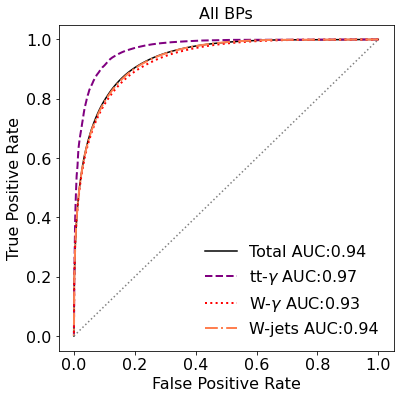

In [82]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"All BPs",fontsize=16)

#plt.savefig('../graph/ROC_AllVars_AllBPs.png', bbox_inches='tight')

In [83]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

tpr_bps = np.zeros((15, nvals))
fpr_bps = np.zeros((15, nvals))
for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    
  
    for bp in BPS_analyzed:
        tp = np.where( (df_test_array[:,24] == (bp+1)) & (y_pred_xg > th) )[0]
        fn = np.where( (df_test_array[:,24] == (bp+1)) & (y_pred_xg < th) )[0]
        tpr_bps[bp, ith] = len(tp) / (len(tp) + len(fn))
        fpr_bps[bp, ith] = len(fp) / (len(fp) + len(tn))
        
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))

        
        
auc_total   = auc(fpr_total, tpr_total)
auc_wgamma  = auc(fpr_wgamma, tpr_wgamma)
auc_wjets   = auc(fpr_wjets, tpr_wjets)
auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

auc_bps = []
for bp in np.arange(15):
    auc_bps.append( auc(fpr_bps[bp,:], tpr_bps[bp,:]) )
    
auc_bps = np.asarray(auc_bps)

Text(0.5, 1.0, 'All BPs')

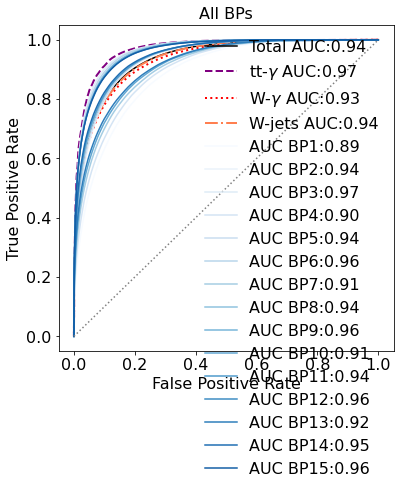

In [84]:
cmap = cm.get_cmap('Blues', 18)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))

for bp in BPS_analyzed:
    plt.plot(fpr_bps[bp,:], tpr_bps[bp,:], c = cmap(bp), label = 'AUC BP{:}:{:.2f}'.format((bp+1),auc_bps[bp]))

    
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"All BPs",fontsize=16)

#plt.savefig('../graph/ROC_AllVars_AllBPs_new.png', bbox_inches='tight')

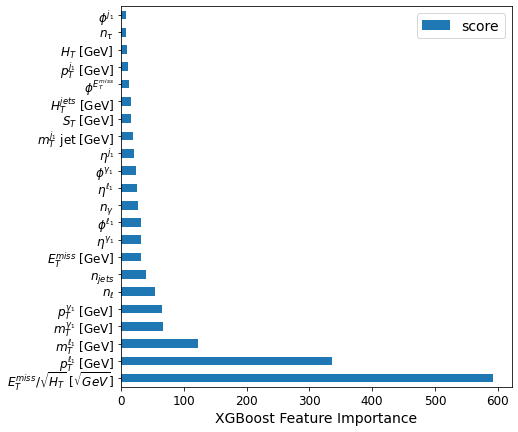

In [85]:
lst1 = ['$p_T^{\gamma_1}$ [GeV]', '$\eta^{\gamma_1}$', '$\phi^{\gamma_1}$', '$n_\gamma$',
       '$p_T^{j_1}$ [GeV]', '$\eta^{j_1}$', '$\phi^{j_1}$',
       '$p_T^{\ell_1}$ [GeV]', '$\eta^{\ell_1}$', '$\phi^{\ell_1}$', '$n_\ell$', '$n_{\\tau}$',
       '$E_T^{miss}$ [GeV]', '$\phi^{E_T^{miss}}$',
       '$H_T$ [GeV]', '$H_T^{jets}$ [GeV]', '$n_{jets}$',
       '$S_T$ [GeV]', 
       '$E_T^{miss}/\sqrt{H_T}$ [$\sqrt{GeV}$]',
       '$m_T^{\gamma_1}$ [GeV]', '$m_T^{j_{1}}$ jet [GeV]', '$m_T^{\ell_1}$ [GeV]',
       'SM=0 - NP=1']

fig, ax = plt.subplots(figsize = (7,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("XGBoost Feature Importance", fontsize = 14)
ax.set_yticklabels(np.asarray(lst1)[np.argsort(values)[::-1]], fontsize = 12)

ax.legend(fontsize = 14)
#plt.savefig('../graph/AllBps_featureImportance_All_new.pdf', bbox_inches='tight')

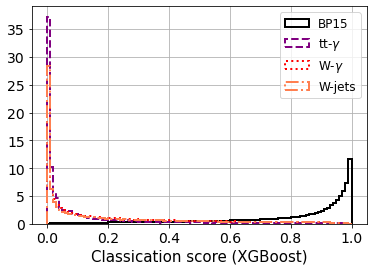

In [86]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
#plt.savefig('../graph/MLOutput_dist_AllVars_AllBPs_new.png', bbox_inches="tight")

In [87]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [88]:
len(np.where(bkg_flag_test != 0)[0])

439041

In [89]:
len(np.where(bkg_flag_test == 0)[0])

1462375

## Sequential selection criteria

In [64]:
nbins = 10
indices_aux = np.arange(len(df_test_array))

n_np0 = []
for bp in np.arange(15):
    n_np0.append( len(np.where(df_test_array[:, 24] == (bp+1))[0]) )
    
n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[:, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[:, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[:, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[:, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[:, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[:, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[:, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[:, 22] == 11)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 3), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    ZN_sup = np.zeros(nbins)
    ZN_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_sup, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_sup, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_sup, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_sup, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_sup, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_sup, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_sup, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_sup, 22] == 11)[0])
        
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
        
        S_expected_aux = np.zeros(15)
        for bp in np.arange(15):
            n_np = len(np.where( (df_test_array[indices_sup, 24] == (bp+1)) )[0])
            S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and ( np.min(S_expected_aux) > 5):
            Z_norm = np.zeros(15)
            for bp in np.arange(15):
                Z_norm[bp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp]))
                Z_norm[bp] = Z_norm[bp] / S_expected[bp]
            ZN_sup[icut] = np.mean(Z_norm)
            Z.append( ZN_sup[icut] )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_inf, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_inf, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_inf, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_inf, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_inf, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_inf, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_inf, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_inf, 22] == 11)[0])
        
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
        
        S_expected_aux = np.zeros(15)
        for bp in np.arange(15):
            n_np = len(np.where( (df_test_array[indices_inf, 24] == (bp+1)) )[0])
            S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (np.min(S_expected_aux) > 5):
            Z_norm = np.zeros(15)
            for bp in np.arange(15):
                Z_norm[bp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp]))
                Z_norm[bp] = Z_norm[bp] / S_expected[bp]
            ZN_inf[icut] = np.mean(Z_norm)
            Z.append( ZN_inf[icut] )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut     = np.argmax(np.asarray(Z))
    indices_aux = indices[max_cut]
    max_cut     = np.argmax((ZN_inf, ZN_sup))
    if max_cut >= len(ZN_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(ZN_sup)]) + '; <Z Norm> = ' + str(ZN_sup[max_cut - len(ZN_inf)]))
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(ZN_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(ZN_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; <Z Norm> = ' + str(ZN_inf[max_cut]))
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = np.zeros(15)
for bp in np.arange(15):
    n_np = len(np.where( (df_test_array[indices_inf, 24] == (bp+1)) )[0])
    S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))
    
# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux > 5) and (np.min(S_expected_aux) > 5): 
    for bp in np.arange(15):
        print('\n')
        print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp])))
        print('Expected Background = ' + str(B_expected_aux))
        print('Expected Signal = ' + str(S_expected_aux[bp]))

MET $\phi$ <= 3.142; <Z Norm> = 0.002581710945621976
num_taus <= 2.0; <Z Norm> = 0.002581710945621976
jet $\eta$ <= 4.483; <Z Norm> = 0.002581710945621976
lepton $\phi$ <= 3.142; <Z Norm> = 0.002581710945621976
MET $p_T$ [GeV] <= 1843.2766666666664; <Z Norm> = 0.002581710945621976
lepton $p_T$ [GeV] <= 202.01666666666668; <Z Norm> = 0.002640737695207692
num photon <= 3.0; <Z Norm> = 0.002640737695207692
$H_T$ (jets) [GeV] <= 2694.354444444444; <Z Norm> = 0.0026408405516220664
num lepton <= 1.3333333333333333; <Z Norm> = 0.0026588257946503937
jet $p_T$ [GeV] <= 2381.138888888889; <Z Norm> = 0.0026588257946503937
MET sig [GeV] >= 12.637473052931206; <Z Norm> = 0.004291701345843743
photon $\phi$ <= 3.142; <Z Norm> = 0.004291701345843743
$m_T$ lepton [GeV] <= 373.17272422257804; <Z Norm> = 0.0042978798123951495
num_jets <= 7.111111111111112; <Z Norm> = 0.004302107735261501
lepton $\eta$ <= 2.5; <Z Norm> = 0.004302107735261501
jet $\phi$ <= 3.142; <Z Norm> = 0.004302107735261501
photon $p_T

In [65]:
sup_cuts

{'MET $\\phi$': 3.142,
 'num_taus': 1.1111111111111112,
 'jet $\\eta$': 3.312,
 'lepton $\\phi$': 3.142,
 'MET $p_T$ [GeV]': 1616.5566666666668,
 'lepton $p_T$ [GeV]': 38.44,
 'num photon': 2.111111111111111,
 '$H_T$ (jets) [GeV]': 2483.89,
 'num lepton': 1.0,
 'jet $p_T$ [GeV]': 1602.543333333333,
 'MET sig [GeV]': 36.21876910999353,
 'photon $\\phi$': 3.142,
 '$m_T$ lepton [GeV]': 287.5456954715418,
 'num_jets': 7.0,
 'lepton $\\eta$': 2.5,
 'jet $\\phi$': 3.142,
 'photon $p_T$ [GeV]': 180.75,
 '$m_T$ jet [GeV]': 3089.0367506370726,
 '$H_T$ [GeV]': 2262.0311111111114,
 '$m_T$ photon [GeV]': 283.66722141945115,
 'photon $\\eta$': 2.369,
 '$S_T$ [GeV]': 1921.4211111111108}

In [66]:
inf_cuts

{'MET $\\phi$': -999999,
 'num_taus': -999999,
 'jet $\\eta$': -999999,
 'lepton $\\phi$': -999999,
 'MET $p_T$ [GeV]': -999999,
 'lepton $p_T$ [GeV]': -999999,
 'num photon': -999999,
 '$H_T$ (jets) [GeV]': -999999,
 'num lepton': -999999,
 'jet $p_T$ [GeV]': -999999,
 'MET sig [GeV]': 12.637473052931206,
 'photon $\\phi$': -999999,
 '$m_T$ lepton [GeV]': -999999,
 'num_jets': -999999,
 'lepton $\\eta$': -999999,
 'jet $\\phi$': -999999,
 'photon $p_T$ [GeV]': -999999,
 '$m_T$ jet [GeV]': -999999,
 '$H_T$ [GeV]': -999999,
 '$m_T$ photon [GeV]': -999999,
 'photon $\\eta$': -1.8425555555555557,
 '$S_T$ [GeV]': -999999}

In [90]:
write = False
if write:
    with open('../data/cuts/ALLBPs_supCuts.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/ALLBPs_infCuts.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/ALLBPs_supCuts.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/ALLBPs_infCuts.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 85.60it/s]


Final results: for BP 1
 
Z = 0.6034252994493122; Z_std = 0.08686539949671225
B_exp = 6100.7995; B_exp_std = 63.13633897962409
S_exp = 47.4665; S_exp_std = 6.703646600918041


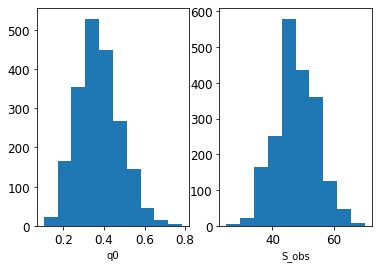

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 85.35it/s]


Final results: for BP 2
 
Z = 1.8960205941210337; Z_std = 0.15751342252372835
B_exp = 6101.079; B_exp_std = 63.489036526001875
S_exp = 148.891; S_exp_std = 12.25557501710956


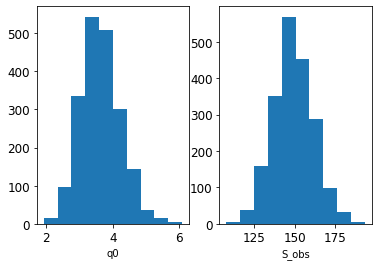

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 84.97it/s]


Final results: for BP 3
 
Z = 3.5037601239078864; Z_std = 0.21285722200108317
B_exp = 6103.7635; B_exp_std = 64.21377241487998
S_exp = 275.7945; S_exp_std = 16.77317112981323


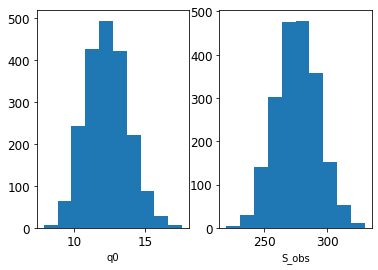

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 85.86it/s]


Final results: for BP 4
 
Z = 0.381941242810645; Z_std = 0.07026118638628931
B_exp = 6100.866; B_exp_std = 64.08266570610184
S_exp = 29.838; S_exp_std = 5.333737526350542


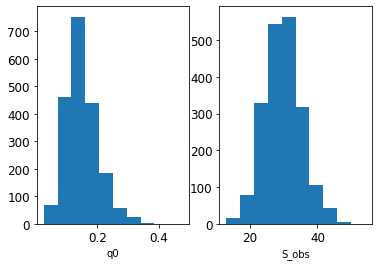

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 85.66it/s]


Final results: for BP 5
 
Z = 1.03342552097661; Z_std = 0.11704277530199088
B_exp = 6101.606; B_exp_std = 63.462735238878565
S_exp = 81.2905; S_exp_std = 9.025193058876912


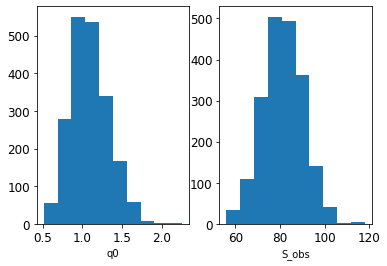

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 85.55it/s]


Final results: for BP 6
 
Z = 1.8426859570677891; Z_std = 0.15676151233650318
B_exp = 6099.691; B_exp_std = 64.27520143103403
S_exp = 144.722; S_exp_std = 12.234447923792883


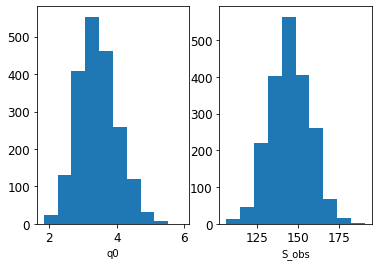

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 86.37it/s]


Final results: for BP 7
 
Z = 0.24353310993959912; Z_std = 0.05962282691441933
B_exp = 6102.594; B_exp_std = 64.67808101667829
S_exp = 19.28; S_exp_std = 4.457532949962344


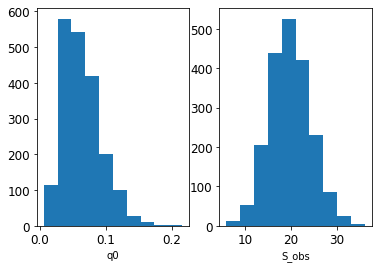

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 86.30it/s]


Final results: for BP 8
 
Z = 0.6131473885130684; Z_std = 0.09258282342208746
B_exp = 6099.012; B_exp_std = 62.876520705268035
S_exp = 47.959; S_exp_std = 7.140680569805653


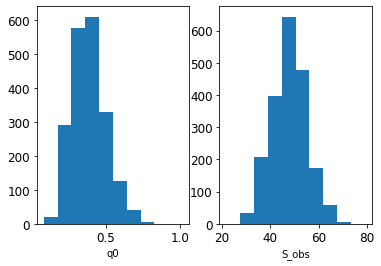

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 86.30it/s]


Final results: for BP 9
 
Z = 0.9940989049874662; Z_std = 0.11247746379768818
B_exp = 6103.463; B_exp_std = 65.73146606458737
S_exp = 77.8735; S_exp_std = 8.745941787480637


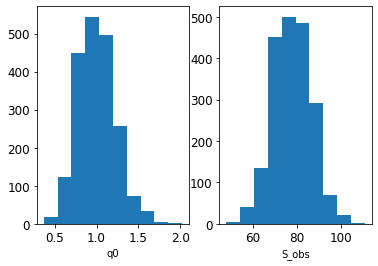

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 86.41it/s]


Final results: for BP 10
 
Z = 0.15382720922668378; Z_std = 0.04728437102239141
B_exp = 6100.0655; B_exp_std = 65.5810354428016
S_exp = 12.2095; S_exp_std = 3.4649112181988153


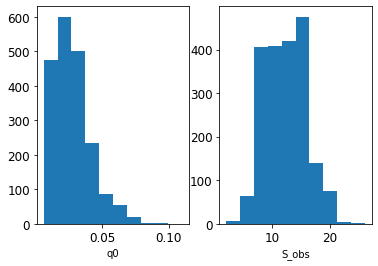

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 86.55it/s]


Final results: for BP 11
 
Z = 0.3597193394686665; Z_std = 0.07067830446919603
B_exp = 6100.4015; B_exp_std = 64.25585808118977
S_exp = 28.4695; S_exp_std = 5.336109982937009


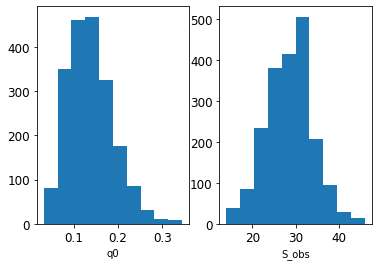

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 86.46it/s]


Final results: for BP 12
 
Z = 0.5768528476337312; Z_std = 0.08664603686238195
B_exp = 6103.0775; B_exp_std = 64.51208796613236
S_exp = 45.1315; S_exp_std = 6.6569668581118835


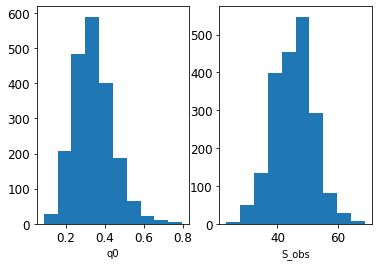

100%|███████████████████████████████| 2000/2000 [00:23<00:00, 86.63it/s]


Final results: for BP 13
 
Z = 0.1025500620351939; Z_std = 0.031755491267055715
B_exp = 6101.4405; B_exp_std = 64.16463558495442
S_exp = 7.319; S_exp_std = 2.67642279918551


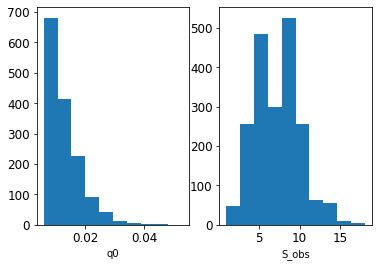

 55%|█████████████████              | 1101/2000 [00:12<00:10, 86.38it/s]


KeyboardInterrupt: 

In [76]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,22] > 0)[0]

for bp in np.arange(15):
    
    NP_test_pool = np.where(df_test_array[:,24] == (bp+1))[0]

    q0_exp = np.zeros(nexperiments)
    B_observed_exp = np.zeros(nexperiments)
    S_observed_exp = np.zeros(nexperiments)
    for nexp in tqdm(range(nexperiments)):
        # Let's create a pseudo-experiment
        SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
        NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
        indices_aux = np.concatenate((NP_indices, SM_indices))

        # Let's make the cuts

        variables = list(sup_cuts.keys())
        for i in range(len(variables)):
            ind_var = np.where(df_test.columns == variables[i])[0][0]
            indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                    (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                                   )[0]]
        # Let's calculate everything

        n_np = len(np.where(df_test_array[indices_aux, 24] == (bp+1))[0])

        n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

        S_observed_exp[nexp] = n_np

        # Formula discovery
        B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets + \
                               n_ttjets + n_zjets + n_wz + \
                               n_zz + n_ww + n_tj + \
                               n_tb + n_tw

        N_observed = n_np + n_ttgamma + n_wgamma + n_wjets+ \
                     n_ttjets + n_zjets + n_wz + \
                     n_zz + n_ww + n_tj + \
                     n_tb + n_tw
        
        if (B_observed_exp[nexp] >= 5) and (n_np > 5): 
            q0_exp[nexp] = -2 * N_observed * np.log(B_observed_exp[nexp] / N_observed) -2 * (N_observed - B_observed_exp[nexp])
        else:
            q0_exp[nexp] = -99
            
    q0_exp = q0_exp[np.where(q0_exp > 0)[0]]
    print('Final results: for BP ' + str(bp+1) + '\n ')
    print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
    print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
    print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))
    fig,ax = plt.subplots(1,2)
    
    ax[0].hist(q0_exp)
    ax[0].set_xlabel('q0')
    ax[1].hist(S_observed_exp)
    ax[1].set_xlabel('S_obs')
    plt.show()

In [ ]:
Z_SCB1     = np.asarray([0.54, 2.07, 4.41 , 0.35, 1.15, 2.27, 0.23, 0.68, 1.22, 0.16, 0.39, 0.69, 0.11, 0.23, 0.39])    # Without individual training


In [63]:
imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]

In [64]:
imp_vars

array(['MET sig [GeV]', 'lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

In [65]:
from scipy.interpolate import bisplrep,bisplev

In [66]:
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('white'), cmap_name = 'NP_cmap')

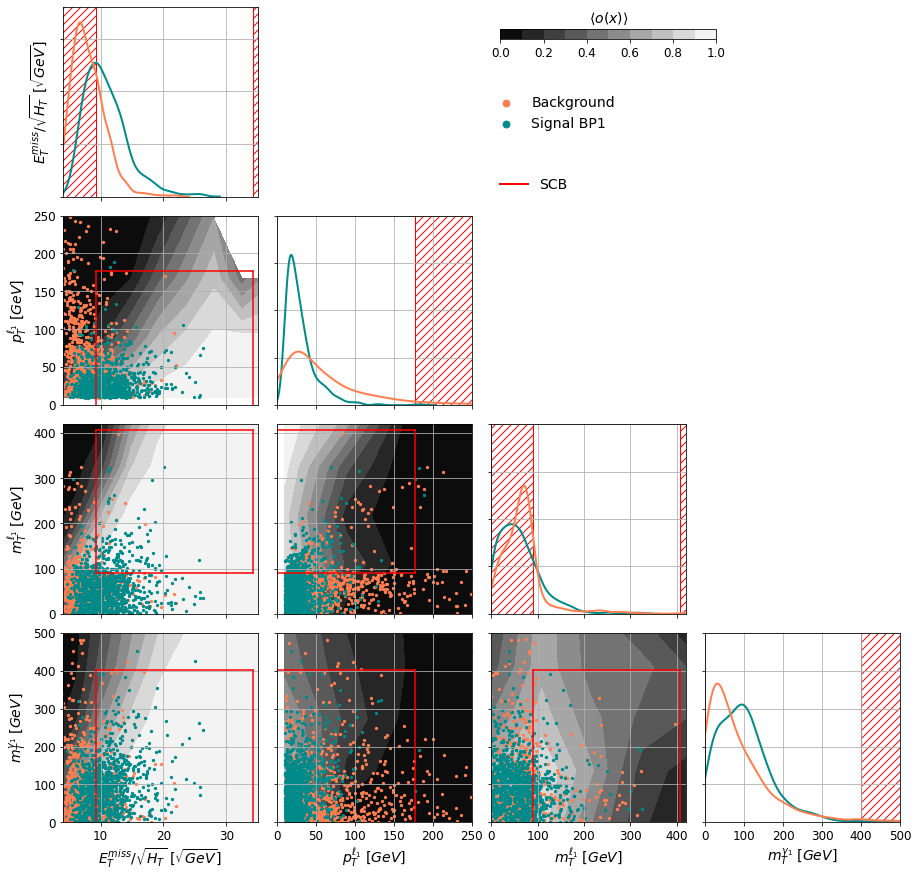

In [95]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bp_flag'] == 1]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  1000, replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]

rand_ind = np.random.choice(range(len(SM)), size =  1000, replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

limites = [[4,35], [0,250], [0,420], [0,500]]
ylimites = [[0,0.18], [0,0.04], [0,0.02], [0,0.01]]

rand_ind = np.random.choice(range(len(df_test)), size =  len(df_test), replace = False)
aux = df_test.iloc[rand_ind]
y_pred_aux = y_pred_xg[rand_ind]

with open('../data/cuts/ALLBPs_supCuts.txt', "r") as fp:
    # Load the dictionary from the file
    sup_cuts = json.load(fp)
with open('../data/cuts/ALLBPs_infCuts.txt', "r") as fp:
    # Load the dictionary from the file
    inf_cuts = json.load(fp)
        
fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = 'solid')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, facecolor = 'none', edgecolor = 'red', zorder = 0, hatch = '///')
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], facecolor = 'none', edgecolor = 'red', zorder = 0, hatch = '///')
                ax[i,j].set_ylim(ylimites[i])
            else:
                stats, xedge, yedge, _ = binned_statistic_2d(aux[imp_vars[j]], aux[imp_vars[i]], y_pred_aux, bins = 22)
                im_NP = ax[i,j].contourf(xedge[:-1], yedge[:-1], stats.T, cmap=NP_cmap, zorder = 0, levels = np.linspace(0,1,11))
                ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = 'coral', rasterized=True, label = 'Background')
                ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = 'darkcyan', rasterized=True, label = 'Signal BP1')
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                #ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'silver', zorder = 1)
                #ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'silver', zorder = 1)
                #ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'silver', zorder = 1)
                #ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'silver', zorder = 1)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')

                #%if (i==1) & (j==0):
                #%    # Create 2D interpolation function
                #%    x = xedge[:-1] + (xedge[1] - xedge[0])/2
                #%    y = yedge[:-1] + (yedge[1] - yedge[0])/2
                #%    x_new = np.linspace(limites[j][0], limites[j][1], 10000)
                #%    y_new = np.linspace(limites[i][0], limites[i][1], 10000)
                #%    X_new, Y_new = np.meshgrid(x_new, y_new)

                    # Interpolate values on the finer grid
                #%    f = bisplrep(aux[imp_vars[j]][:100000], aux[imp_vars[i]][:100000], y_pred_aux[:100000],kx=2,ky=2)
                #%    Z_new = bisplev(x_new, y_new,f)

                #%    ax[i,j].contourf(x_new, y_new, Z_new.T,cmap=NP_cmap,levels=np.linspace(0,1,10),zorder=1)

                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel('$E_T^{miss}/\sqrt{H_T}$ [$\sqrt{GeV}$]', fontsize = 14)
ax[3,1].set_xlabel('$p_T^{\ell_{1}}$ [$GeV$]', fontsize = 14)
ax[3,2].set_xlabel('$m_T^{\ell_1}$ [$GeV$]', fontsize = 14)
ax[3,3].set_xlabel('$m_T^{\gamma_1}$ [$GeV$]', fontsize = 14)

ax[0,0].set_ylabel('$E_T^{miss}/\sqrt{H_T}$ [$\sqrt{GeV}$]', fontsize = 14)
ax[1,0].set_ylabel('$p_T^{\ell_{1}}$ [$GeV$]', fontsize = 14)
ax[2,0].set_ylabel('$m_T^{\ell_1}$ [$GeV$]', fontsize = 14)
ax[3,0].set_ylabel('$m_T^{\gamma_1}$ [$GeV$]', fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])



#%with open('../data/cuts/BP1_supCuts.txt', "r") as fp:
    # Load the dictionary from the file
#%    sup_cuts = json.load(fp)
#%with open('../data/cuts/BP1_infCuts.txt', "r") as fp:
    # Load the dictionary from the file
#%    inf_cuts = json.load(fp)

#%for i in range(4):
#%    for j in range(4):
#%        if i >= j:
#%            if i==j:
#%                pass
                #ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'silver', zorder = 0)
                #ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'silver', zorder = 0)
#%            else:
#%                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red', ls = '-.', lw = 2) 
#%                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red', ls = '-.', lw = 2) 
#%                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red', ls = '-.', lw = 2) 
#%                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red', ls = '-.', lw = 2) 


# Legends------------------------------------------

ax[1,0].legend(loc = 'upper right', bbox_to_anchor=(2.9, 1.7), fontsize = 14, frameon = False, markerscale=3)

#%cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal', pad = 0.5)
#%cbar_SM.set_label('$P(S|B)$', labelpad=-50)
cax = fig.add_axes([0.53, 0.85, 0.2, 0.01])
cbar_NP = plt.colorbar(im_NP, cax=cax, orientation = 'horizontal')
cbar_NP.set_label(r'$\langle o(x) \rangle$', labelpad=-50, fontsize = 14)

patch1 = mlines.Line2D([], [], color='red', label='SCB', linestyle='-', markerfacecolor='none', markeredgewidth=2, lw = 2)
patch2 = mlines.Line2D([], [], color='red', label='BP 1', linestyle='-.', markerfacecolor='none', markeredgewidth=2, lw = 2)

# Add custom legend with boxes
ax[0,0].legend(handles=[patch1], loc = 'lower left', bbox_to_anchor=(2.18, -0.04), fontsize = 14, frameon = False )

plt.savefig('../graph/ALLBPs_ImpVars_dist.pdf', bbox_inches='tight')

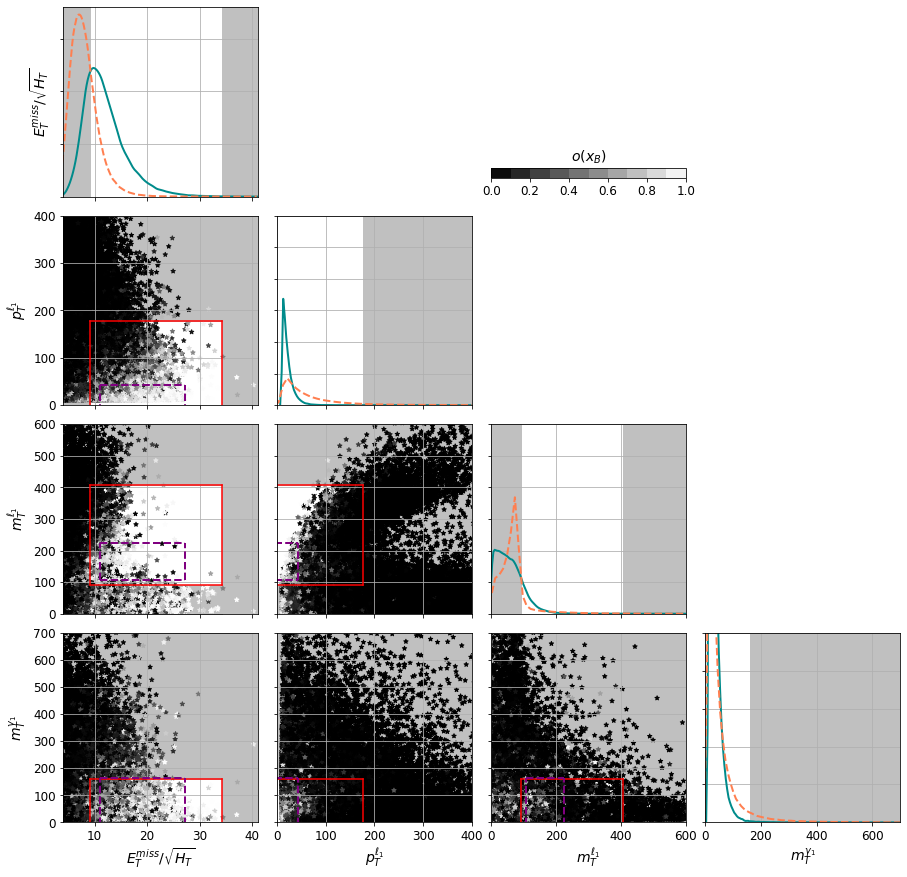

In [219]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bp_flag'] == 5]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  len(NP), replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]


rand_ind = np.random.choice(range(len(SM)), size =  len(SM), replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

limites = [[4,41], [0,400], [0,600], [0,700]]
ylimites = [[0,0.18], [0,0.12], [0,0.03], [0,0.01]]

with open('../data/cuts/ALLBPs_supCuts.txt', "r") as fp:
    # Load the dictionary from the file
    sup_cuts = json.load(fp)
with open('../data/cuts/ALLBPs_infCuts.txt', "r") as fp:
    # Load the dictionary from the file
    inf_cuts = json.load(fp)
        
fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = '--')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'silver', zorder = 0)
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'silver', zorder = 0)
                ax[i,j].set_ylim(ylimites[i])
            else:
                im_SM = ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 20.8, marker = '*', 
                                        c = pred_XG_SM, cmap = NP_cmap, vmin = 0, vmax = 1, rasterized=True)
                                        #%c = 'coral', rasterized=True)
                #im_NP = ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 20.8, marker = '.', 
                #                        c = pred_XG_NP, cmap = NP_cmap, vmin = 0, vmax = 1, rasterized=True)
                                        #%c = 'darkcyan', rasterized=True)
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'silver', zorder = 0)
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'silver', zorder = 0)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'silver', zorder = 0)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'silver', zorder = 0)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel('$E_T^{miss}/\sqrt{H_T}$', fontsize = 14)
ax[3,1].set_xlabel('$p_T^{\ell_{1}}$', fontsize = 14)
ax[3,2].set_xlabel('$m_T^{\ell_1}$', fontsize = 14)
ax[3,3].set_xlabel('$m_T^{\gamma_1}$', fontsize = 14)

ax[0,0].set_ylabel('$E_T^{miss}/\sqrt{H_T}$', fontsize = 14)
ax[1,0].set_ylabel('$p_T^{\ell_{1}}$', fontsize = 14)
ax[2,0].set_ylabel('$m_T^{\ell_1}$', fontsize = 14)
ax[3,0].set_ylabel('$m_T^{\gamma_1}$', fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])

#%cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal', pad = 0.5)
#%cbar_SM.set_label('$P(S|B)$', labelpad=-50)
cbar_NP = plt.colorbar(im_NP, ax = ax[0,2], orientation = 'horizontal', pad = 0.2)
cbar_NP.set_label('$o(x_{B})$', labelpad=-50, fontsize = 14)

with open('../data/cuts/BP5_supCuts.txt', "r") as fp:
    # Load the dictionary from the file
    sup_cuts = json.load(fp)
with open('../data/cuts/BP5_infCuts.txt', "r") as fp:
    # Load the dictionary from the file
    inf_cuts = json.load(fp)

for i in range(4):
    for j in range(4):
        if i >= j:
            if i==j:
                pass
                #ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'silver', zorder = 0)
                #ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'silver', zorder = 0)
            else:
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'purple', ls = '--', lw = 2) 
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'purple', ls = '--', lw = 2) 
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'purple', ls = '--', lw = 2) 
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'purple', ls = '--', lw = 2) 


#plt.savefig('../graph/ALLBPs_ImpVars_dist.pdf', bbox_inches='tight')

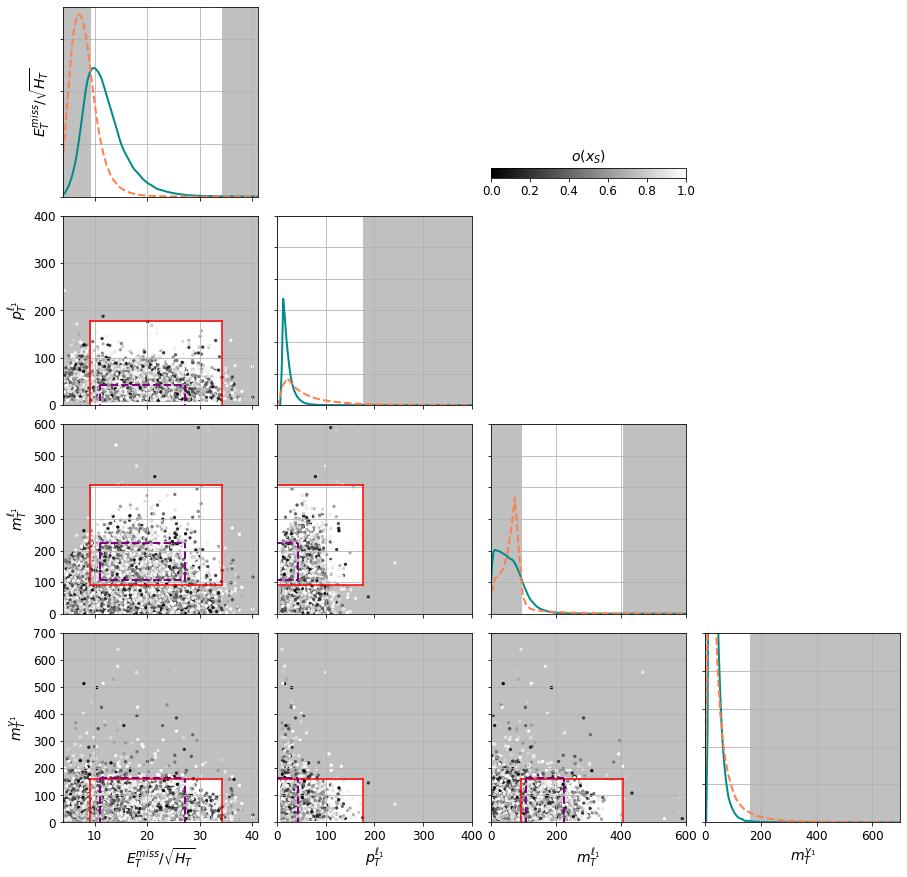

In [220]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bp_flag'] == 5]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  len(NP), replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]


rand_ind = np.random.choice(range(len(SM)), size =  len(SM), replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

limites = [[4,41], [0,400], [0,600], [0,700]]
ylimites = [[0,0.18], [0,0.12], [0,0.03], [0,0.01]]

with open('../data/cuts/ALLBPs_supCuts.txt', "r") as fp:
    # Load the dictionary from the file
    sup_cuts = json.load(fp)
with open('../data/cuts/ALLBPs_infCuts.txt', "r") as fp:
    # Load the dictionary from the file
    inf_cuts = json.load(fp)
        
fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = '--')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'silver', zorder = 0)
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'silver', zorder = 0)
                ax[i,j].set_ylim(ylimites[i])
            else:
                #im_SM = ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 20.8, marker = '*', 
                #                        c = pred_XG_SM, cmap = NP_cmap, vmin = 0, vmax = 1, rasterized=True)
                                        #%c = 'coral', rasterized=True)
                im_NP = ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = pred_XG_NP, cmap = NP_cmap, vmin = 0, vmax = 1, rasterized=True)
                                        #%c = 'darkcyan', rasterized=True)
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'silver', zorder = 0)
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'silver', zorder = 0)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'silver', zorder = 0)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'silver', zorder = 0)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel('$E_T^{miss}/\sqrt{H_T}$', fontsize = 14)
ax[3,1].set_xlabel('$p_T^{\ell_{1}}$', fontsize = 14)
ax[3,2].set_xlabel('$m_T^{\ell_1}$', fontsize = 14)
ax[3,3].set_xlabel('$m_T^{\gamma_1}$', fontsize = 14)

ax[0,0].set_ylabel('$E_T^{miss}/\sqrt{H_T}$', fontsize = 14)
ax[1,0].set_ylabel('$p_T^{\ell_{1}}$', fontsize = 14)
ax[2,0].set_ylabel('$m_T^{\ell_1}$', fontsize = 14)
ax[3,0].set_ylabel('$m_T^{\gamma_1}$', fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])

#%cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal', pad = 0.5)
#%cbar_SM.set_label('$P(S|B)$', labelpad=-50)
cbar_NP = plt.colorbar(im_NP, ax = ax[0,2], orientation = 'horizontal', pad = 0.2)
cbar_NP.set_label('$o(x_{S})$', labelpad=-50, fontsize = 14)

with open('../data/cuts/BP5_supCuts.txt', "r") as fp:
    # Load the dictionary from the file
    sup_cuts = json.load(fp)
with open('../data/cuts/BP5_infCuts.txt', "r") as fp:
    # Load the dictionary from the file
    inf_cuts = json.load(fp)

for i in range(4):
    for j in range(4):
        if i >= j:
            if i==j:
                pass
                #ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'silver', zorder = 0)
                #ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'silver', zorder = 0)
            else:
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'purple', ls = '--', lw = 2) 
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'purple', ls = '--', lw = 2) 
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'purple', ls = '--', lw = 2) 
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'purple', ls = '--', lw = 2) 


#plt.savefig('../graph/ALLBPs_ImpVars_dist.pdf', bbox_inches='tight')

## BinnedLikelihood

In [50]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [51]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(439041,)
(1462375,)


In [52]:
B_expected = int(B_expected)

B_expected:  147986

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


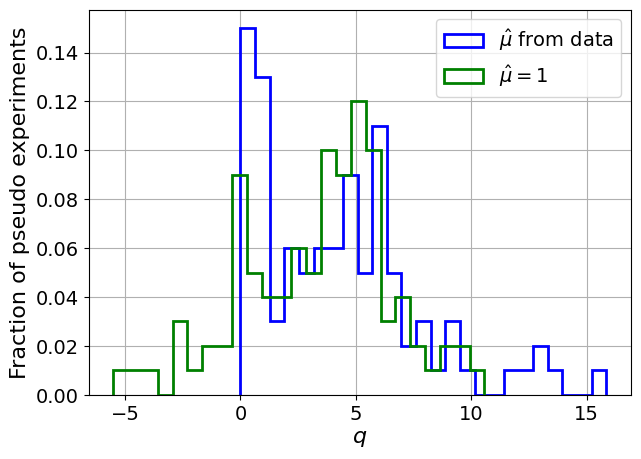

BP1

S_expected:  202.45079649725346
muhat mean:  1.1390000000000002
Z_bins:  2.0060358377486676
std Z_bins:  0.8635383479011994
Z_bins mu=1:  1.9727308310946148
std Z_bins mu=1:  0.8134442293996464

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


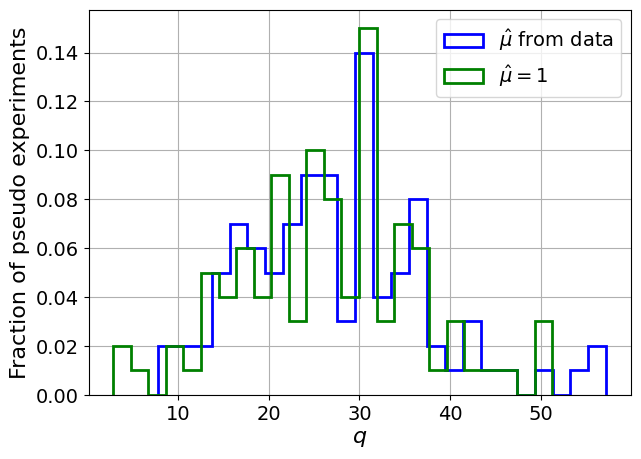

BP2

S_expected:  459.030589045875
muhat mean:  1.0495
Z_bins:  5.19851977098284
std Z_bins:  0.9701374737422767
Z_bins mu=1:  5.197252829703287
std Z_bins mu=1:  0.9392247767940676

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


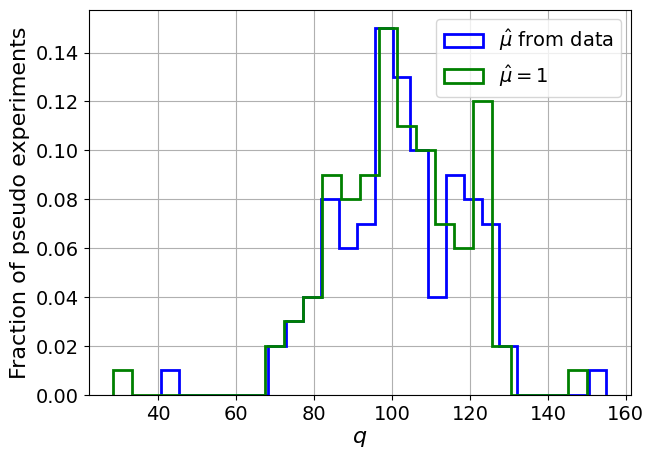

BP3

S_expected:  636.2971954330917
muhat mean:  1.022
Z_bins:  10.04722013001111
std Z_bins:  0.8273347823230326
Z_bins mu=1:  10.052214947396322
std Z_bins mu=1:  0.846789638545045

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


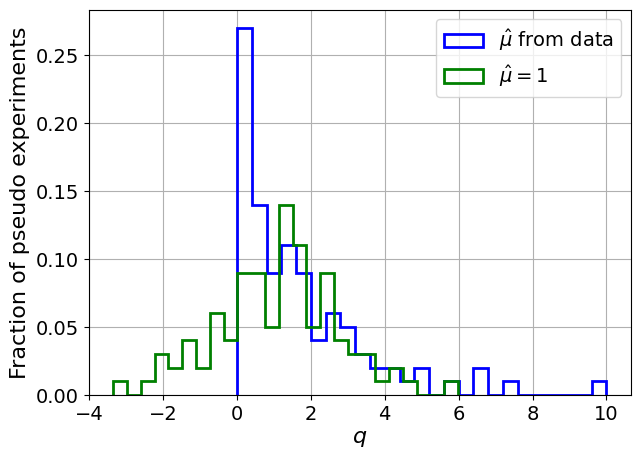

BP4

S_expected:  111.06471287999999
muhat mean:  1.0285000000000002
Z_bins:  1.0997503040116245
std Z_bins:  0.822561191965356
Z_bins mu=1:  1.0986053415977202
std Z_bins mu=1:  0.7493916113126626

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


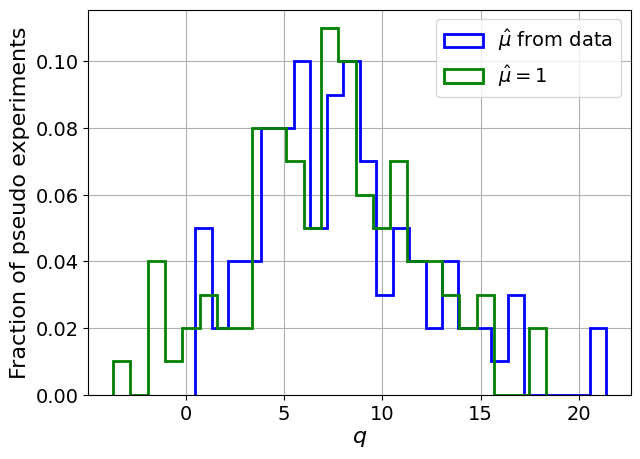

BP5

S_expected:  235.49582865600001
muhat mean:  0.9910000000000001
Z_bins:  2.7027994384083858
std Z_bins:  0.7993804173282035
Z_bins mu=1:  2.7027994384083858
std Z_bins mu=1:  0.821377000118184

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


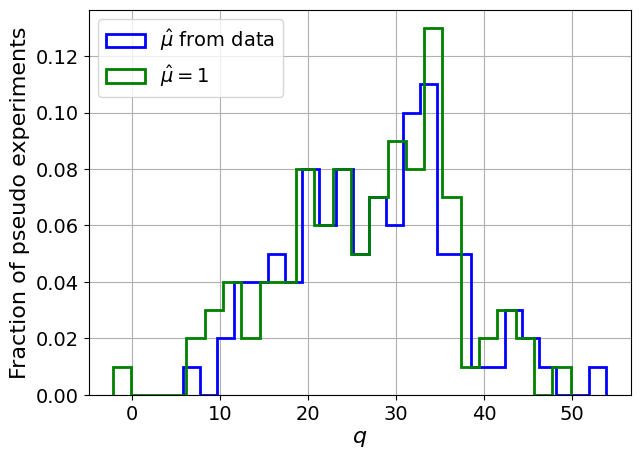

BP6

S_expected:  333.821602928
muhat mean:  0.9985
Z_bins:  5.2736355152101195
std Z_bins:  0.879873501366883
Z_bins mu=1:  5.2736355152101195
std Z_bins mu=1:  0.9207185396098424

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


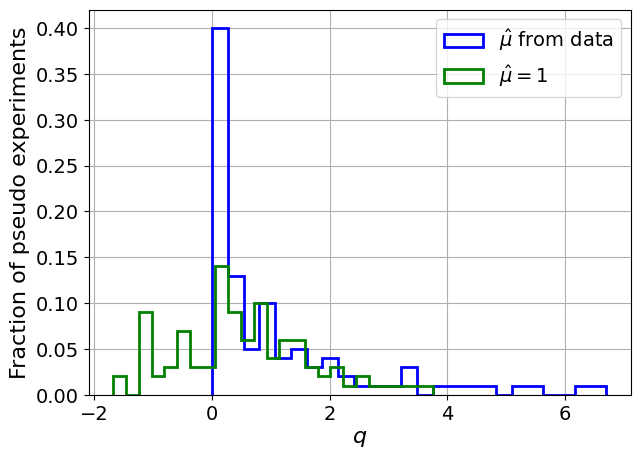

BP7

S_expected:  66.00561444399999
muhat mean:  1.0225
Z_bins:  0.6507134147147564
std Z_bins:  1.1375950535154409
Z_bins mu=1:  0.6490474750048697
std Z_bins mu=1:  0.8781769680620344

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


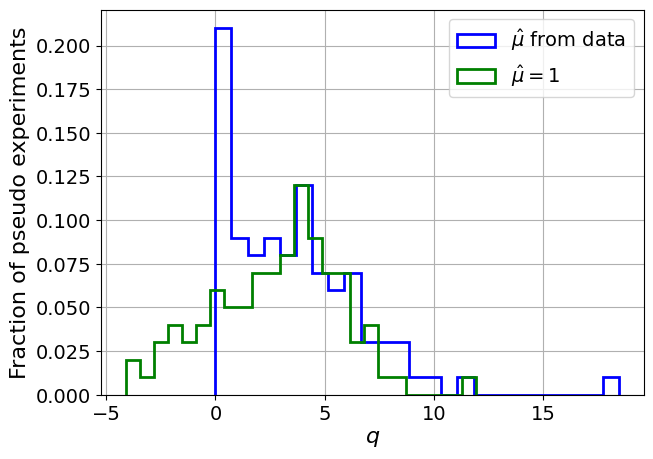

BP8

S_expected:  129.20029848000001
muhat mean:  1.024
Z_bins:  1.7777300390305164
std Z_bins:  0.8567795449872403
Z_bins mu=1:  1.7750535551012616
std Z_bins mu=1:  0.8359305428978612

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


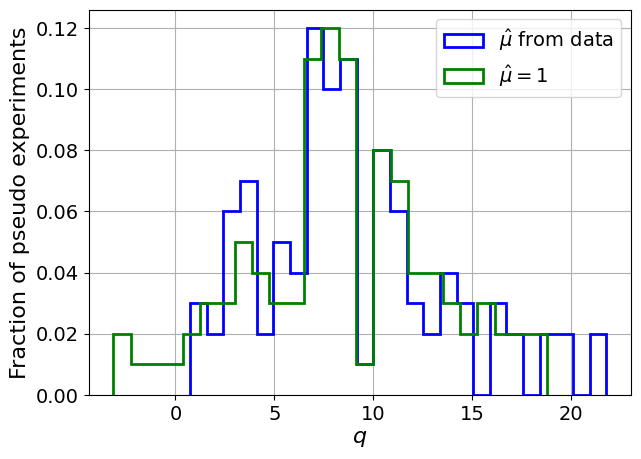

BP9

S_expected:  179.306844684
muhat mean:  1.0230000000000004
Z_bins:  2.868682232734014
std Z_bins:  0.8216482051694116
Z_bins mu=1:  2.868682232734014
std Z_bins mu=1:  0.8189938739239518

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


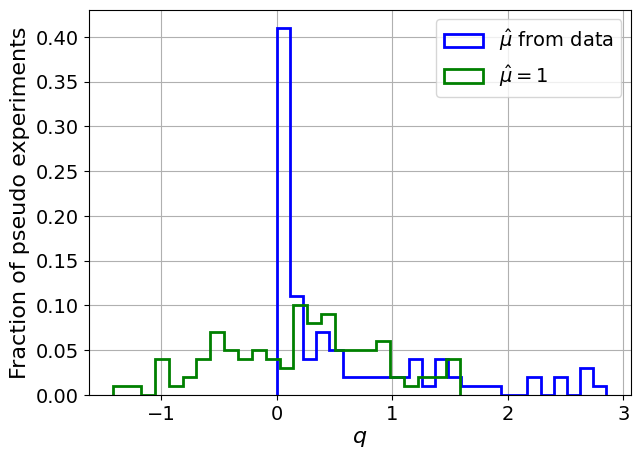

BP10

S_expected:  39.933235237500014
muhat mean:  1.0015000000000003
Z_bins:  0.4631074104304704
std Z_bins:  0.833233773381323
Z_bins mu=1:  0.47596857237348117
std Z_bins mu=1:  0.7077063438809406

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


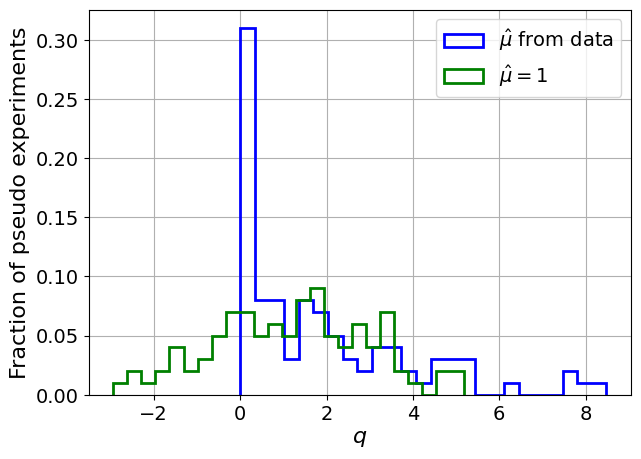

BP11

S_expected:  73.57548515624998
muhat mean:  1.089
Z_bins:  1.1356130660646337
std Z_bins:  0.895860013346863
Z_bins mu=1:  1.1275424391842053
std Z_bins mu=1:  0.7829723868289293

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


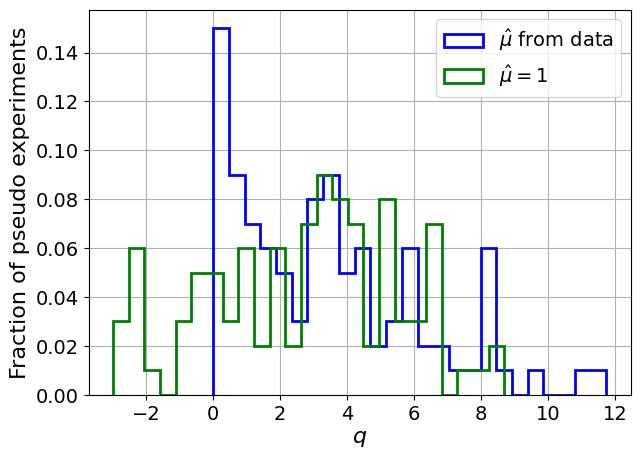

BP12

S_expected:  101.99245228425
muhat mean:  1.008
Z_bins:  1.783589256678283
std Z_bins:  0.7745621371196411
Z_bins mu=1:  1.779397046986416
std Z_bins mu=1:  0.7943483114603742

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


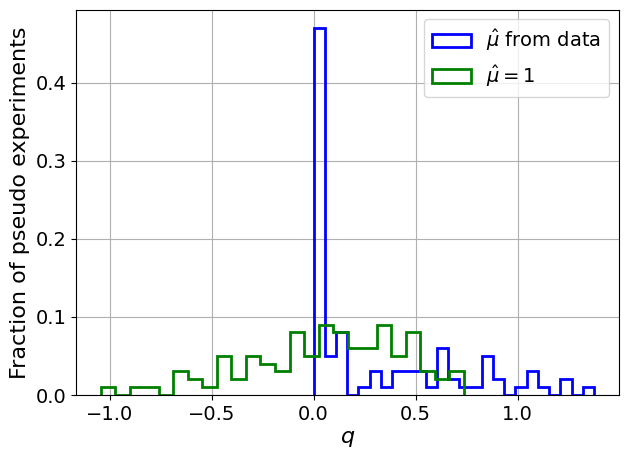

BP13

S_expected:  22.901644128
muhat mean:  1.0235
Z_bins:  0.2783002493881233
std Z_bins:  0.6803794360605493
Z_bins mu=1:  0.31589042429116077
std Z_bins mu=1:  0.5985567195883857

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


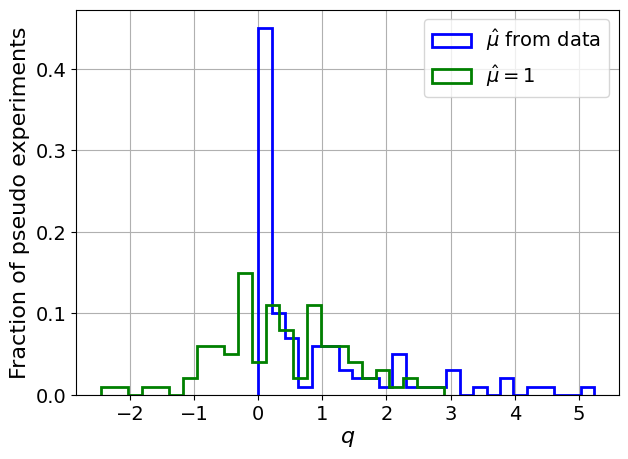

BP14

S_expected:  41.142085952
muhat mean:  0.9864999999999999
Z_bins:  0.5466089564204796
std Z_bins:  1.089396708012458
Z_bins mu=1:  0.5447367198810198
std Z_bins mu=1:  0.9193307741573351

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


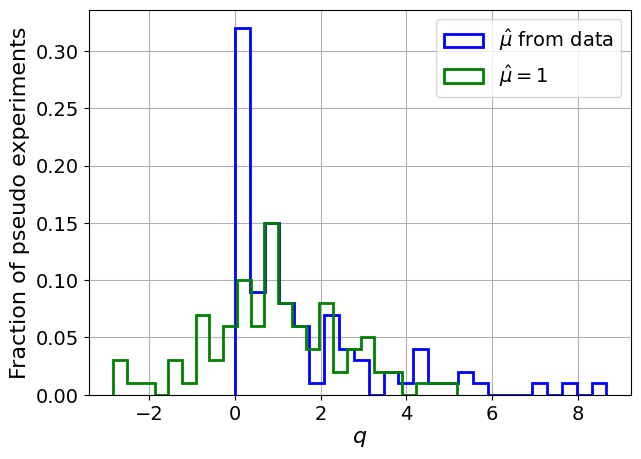

BP15

S_expected:  57.265147368
muhat mean:  1.0285
Z_bins:  0.9338000241584584
std Z_bins:  0.9808749905850918
Z_bins mu=1:  0.9338000241584584
std Z_bins mu=1:  0.8441678843910472

--------



In [53]:
D_or_E = 'discovery'
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]]
# requested number of pseudo experiments
num_pseudo = 100
    
print('B_expected: ', B_expected)
print('')
Z_BL_BPs = np.ones(15) * (-99)
Z_BL_std_BPs = np.ones(15) * (-99)
muhat_BL = np.ones(15) * (-99)
for bp in BPS_analyzed:
    Z_BL = BL_test_fast(D_or_E, pred_XG_SM, y_pred_xg[np.where( (df_test_array[:,24] == (bp+1)) )[0]], B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 
    
    Z_BL_BPs[bp] = Z_BL[0]
    Z_BL_std_BPs[bp] = Z_BL[1]
    muhat_BL[bp] = Z_BL[2]
    
    print('BP' + str(bp+1) + '\n')
    print('S_expected: ', S_expected[bp])
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=1: ', Z_BL[3])
    print('std Z_bins mu=1: ', Z_BL[4])
    print('')
    print('--------\n')

In [68]:
# requested number of pseudo experiments
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
    
#%print('B_expected: ', B_expected)
#%print('')

#%for bp in BPS_analyzed:
#%    Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, y_pred_xg[np.where( (df_test_array[:,24] == (bp+1)) )[0]], B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 
#%    print('BP' + str(bp+1) + '\n')
#%    print('S_expected: ', S_expected[bp])
#%    print('muhat mean: ', Z_BL[2])
#%    print('Z_bins: ', Z_BL[0])
#%    print('std Z_bins: ', Z_BL[1])
#%    print('Z_bins mu=0: ', Z_BL[3])
#%    print('std Z_bins mu=0: ', Z_BL[4])
#%    print('')
#%    print('--------\n')

## KDE

In [ ]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (BPS_trained[0] + 1))[0]]

kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        50000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


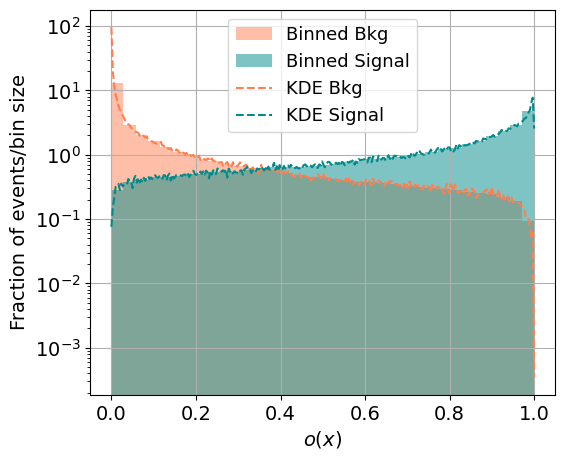

In [65]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,300)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='coral',alpha=0.5, linewidth=2, label=r'Binned Bkg');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='darkcyan',alpha=0.5, linewidth=2, label=r'Binned Signal');

plt.plot(s_vals, dens_bkg, color='coral',label=r'KDE Bkg',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='darkcyan',label=r'KDE Signal',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xlabel("$o(x)$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

plt.savefig('../graph/KDE_fit_ALLBPs_new.pdf', bbox_inches='tight')

In [ ]:
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

In [ ]:
print(np.min(pB_B_data))
pB_B_data[np.where(pB_B_data == 0 )[0]] = np.min(pB_B_data[np.where(pB_B_data > 0 )[0]])
pS_B_data[np.where(pS_B_data == 0 )[0]] = np.min(pS_B_data[np.where(pS_B_data > 0 )[0]])
print(np.min(pB_B_data))

0:10000
3 done
4 done
0.0039003890675552376
0.0039003890675552376
B_expected:  147986
S_expected:  202

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


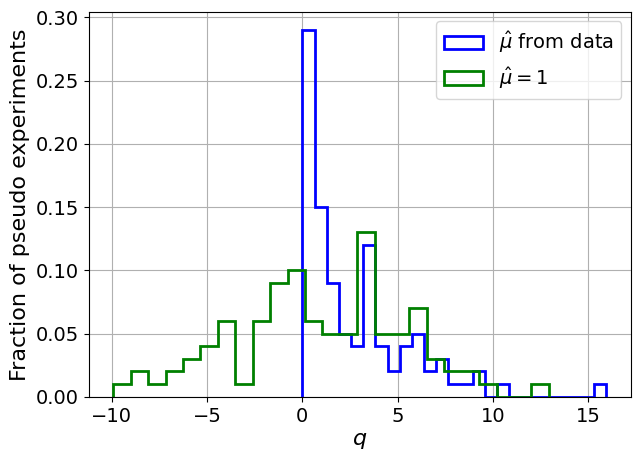

BP1
muhat mean:  0.6240000000000001
Z_MLL:  1.3315932378623323
std Z_MLL:  1.0862708722953127
Z_MLL mu=1:  1.0205751730521242
std Z_MLL mu=1:  2.1972805635222783

--------

1:10000
3 done
4 done
0.003127427206541979
0.003127427206541979
B_expected:  147986
S_expected:  459

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.01


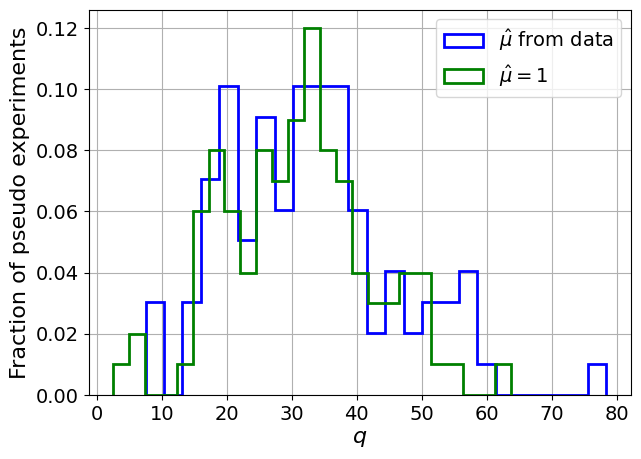

BP2
muhat mean:  1.1676767676767679
Z_MLL:  5.659674818669732
std Z_MLL:  1.1392542734762083
Z_MLL mu=1:  5.610176872073683
std Z_MLL mu=1:  1.004854693663553

--------

2:10000
3 done
4 done
0.0029469523491454995
0.0029469523491454995
B_expected:  147986
S_expected:  636

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


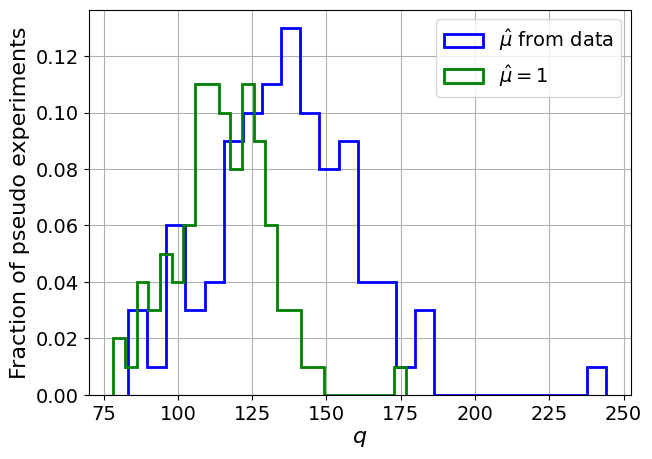

BP3
muhat mean:  1.8034999999999999
Z_MLL:  11.717905851276523
std Z_MLL:  1.0533103172776106
Z_MLL mu=1:  10.739188943937906
std Z_MLL mu=1:  0.7337328638633788

--------

3:10000
3 done
4 done
0.003833059918987476
0.003833059918987476
B_expected:  147986
S_expected:  111

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


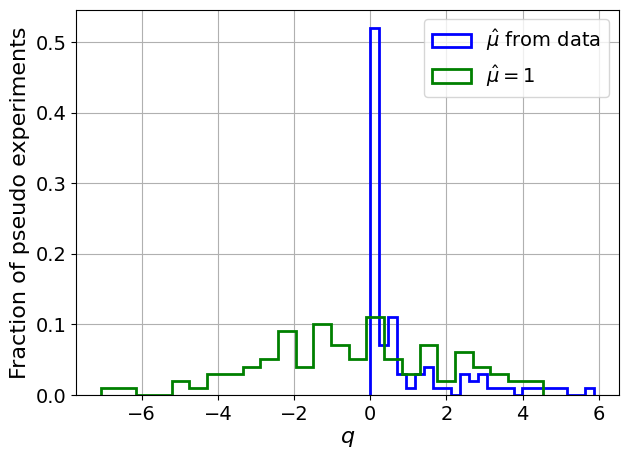

BP4
muhat mean:  0.49650000000000005
Z_MLL:  0.40103826414458743
std Z_MLL:  1.6972218628879923
Z_MLL mu=1:  0.7437287016724186
std Z_MLL mu=1:  1.6088294066539859

--------

4:10000
3 done
4 done
0.0043008951073445064
0.0043008951073445064
B_expected:  147986
S_expected:  235

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


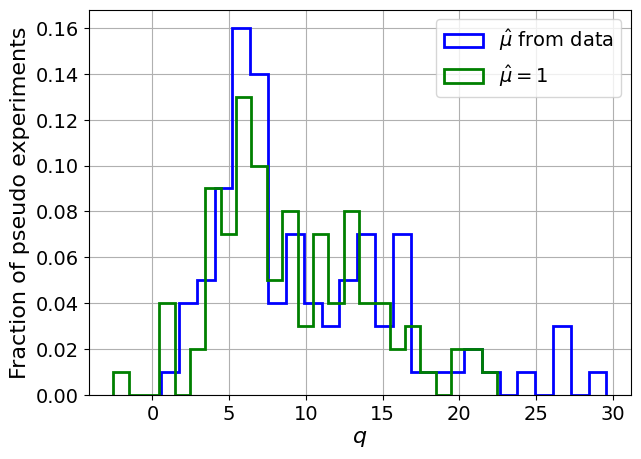

BP5
muhat mean:  1.1945000000000001
Z_MLL:  2.7770891273077942
std Z_MLL:  1.110081689506188
Z_MLL mu=1:  2.776097396485663
std Z_MLL mu=1:  0.8998107854806321

--------

5:10000
3 done
4 done
0.003995918693917679
0.003995918693917679
B_expected:  147986
S_expected:  333

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


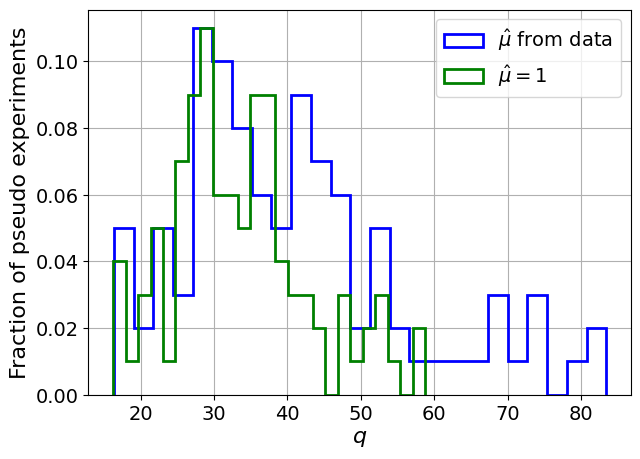

BP6
muhat mean:  1.7169999999999999
Z_MLL:  6.142269677496269
std Z_MLL:  1.2409947858536376
Z_MLL mu=1:  5.716198713304633
std Z_MLL mu=1:  0.821088812245381

--------

6:10000
3 done
4 done
0.0030480045737350772
0.0030480045737350772
B_expected:  147986
S_expected:  66

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


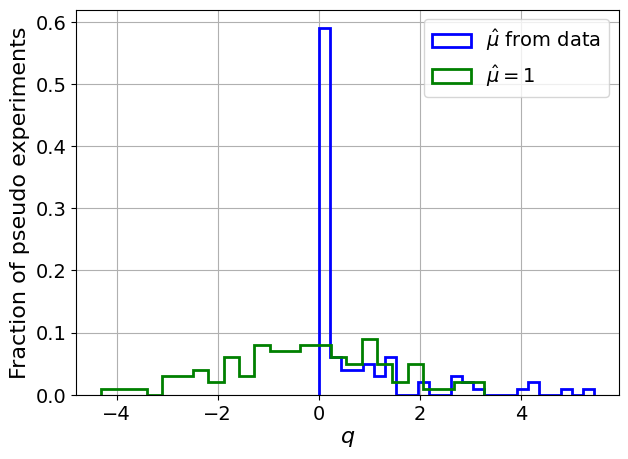

BP7
muhat mean:  0.628
Z_MLL:  0.25791883367012447
std Z_MLL:  2.3206365346922966
Z_MLL mu=1:  0.40719889158255645
std Z_MLL mu=1:  1.924802361723431

--------

7:10000
3 done
4 done
0.003295173477874841
0.003295173477874841
B_expected:  147986
S_expected:  129

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


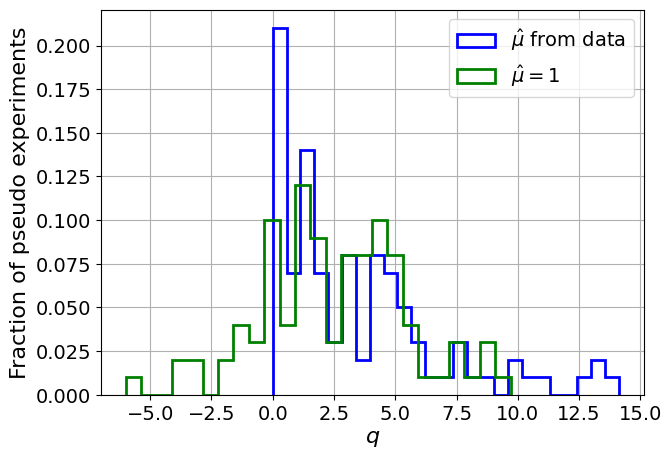

BP8
muhat mean:  1.0905
Z_MLL:  1.6044601248168748
std Z_MLL:  1.04244100286231
Z_MLL mu=1:  1.6001844814188477
std Z_MLL mu=1:  0.9339878175338712

--------

8:10000
3 done
4 done
0.003675420548913113
0.003675420548913113
B_expected:  147986
S_expected:  179

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


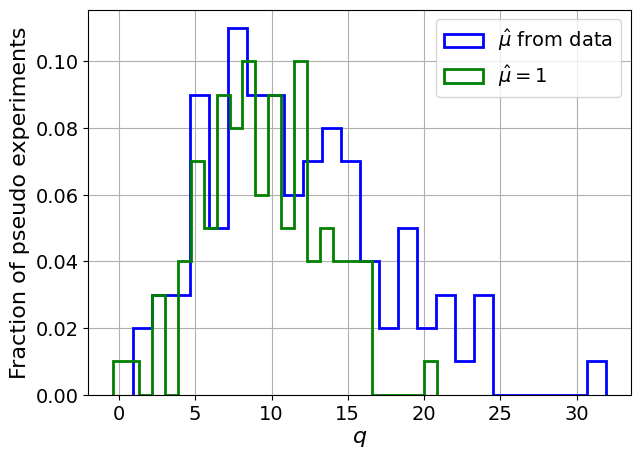

BP9
muhat mean:  1.6300000000000003
Z_MLL:  3.2816769673261588
std Z_MLL:  0.8926693917868858
Z_MLL mu=1:  3.0680916180500604
std Z_MLL mu=1:  0.6222251504993875

--------

9:10000
3 done
4 done
0.002769419122042689
0.002769419122042689
B_expected:  147986
S_expected:  39

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


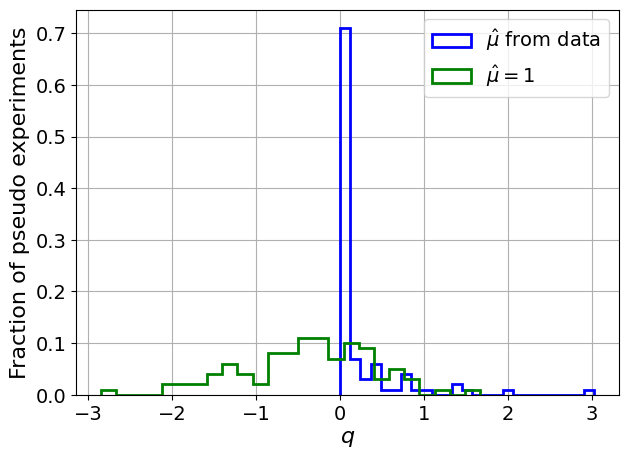

BP10
muhat mean:  0.45150000000000007
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  0.5629710408890343
std Z_MLL mu=1:  0.6974798146171297

--------

10:10000


/home/ernesto/Martin/susyatLHC/codes/AUX_MLL_BL.py:1097: RuntimeWarning: divide by zero encountered in scalar divide
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)


3 done
4 done
0.003226421092441863
0.003226421092441863
B_expected:  147986
S_expected:  73

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


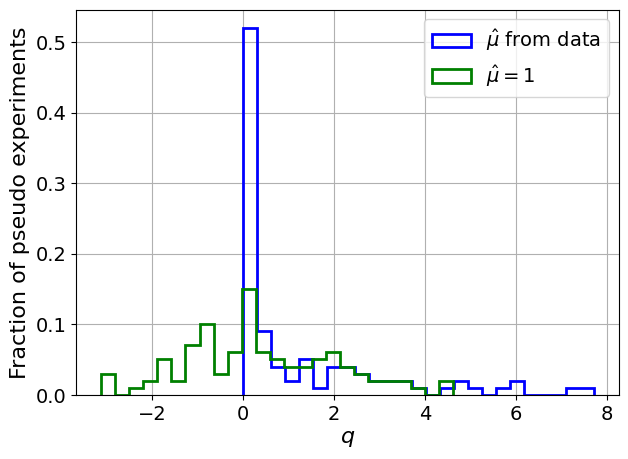

BP11
muhat mean:  0.8465000000000003
Z_MLL:  0.5303216230055312
std Z_MLL:  1.673909644994993
Z_MLL mu=1:  0.4338098272321576
std Z_MLL mu=1:  1.900994327281283

--------

11:10000
3 done
4 done
0.0028631485241391173
0.0028631485241391173
B_expected:  147986
S_expected:  101

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


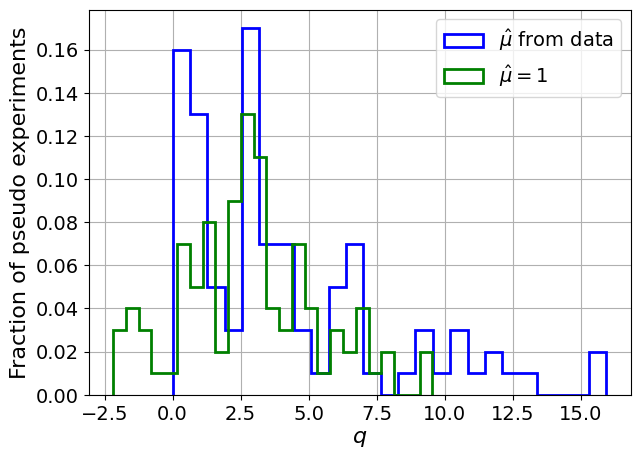

BP12
muhat mean:  1.4069999999999998
Z_MLL:  1.7437236240928515
std Z_MLL:  1.059527329140928
Z_MLL mu=1:  1.6567522159934611
std Z_MLL mu=1:  0.7632391910588332

--------

12:10000
3 done
4 done
0.0033426162597213656
0.0033426162597213656
B_expected:  147986
S_expected:  22

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


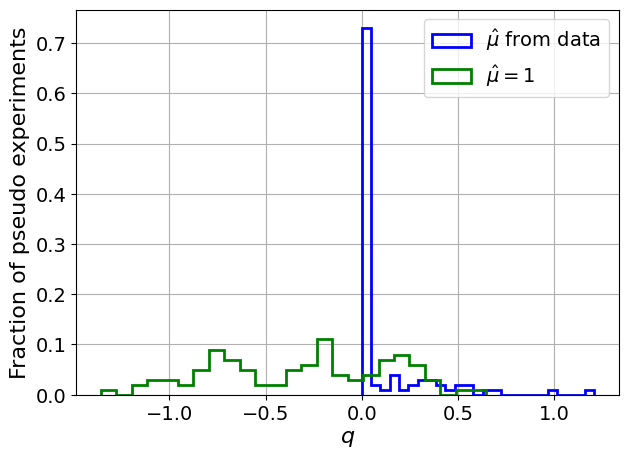

BP13
muhat mean:  0.48650000000000004
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  0.49535039911627193
std Z_MLL mu=1:  0.46194790250755075

--------

13:10000


/home/ernesto/Martin/susyatLHC/codes/AUX_MLL_BL.py:1097: RuntimeWarning: divide by zero encountered in scalar divide
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)


3 done
4 done
0.0029343773330207336
0.0029343773330207336
B_expected:  147986
S_expected:  41

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


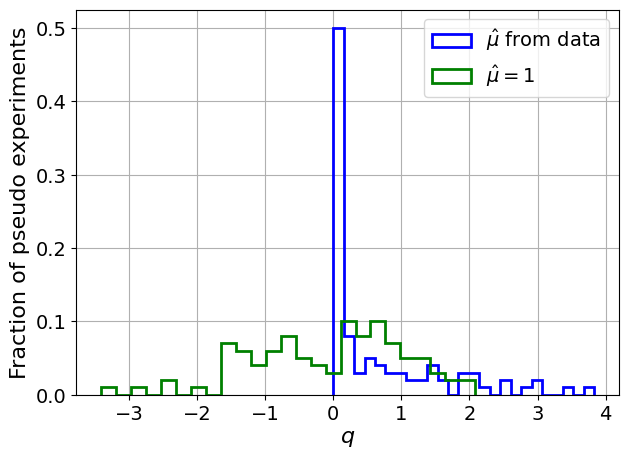

BP14
muhat mean:  0.9079999999999999
Z_MLL:  0.4139410234432453
std Z_MLL:  1.1003185923016265
Z_MLL mu=1:  0.40823943345404484
std Z_MLL mu=1:  1.3581812728102582

--------

14:10000
3 done
4 done
0.003029928577227399
0.003029928577227399
B_expected:  147986
S_expected:  57

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


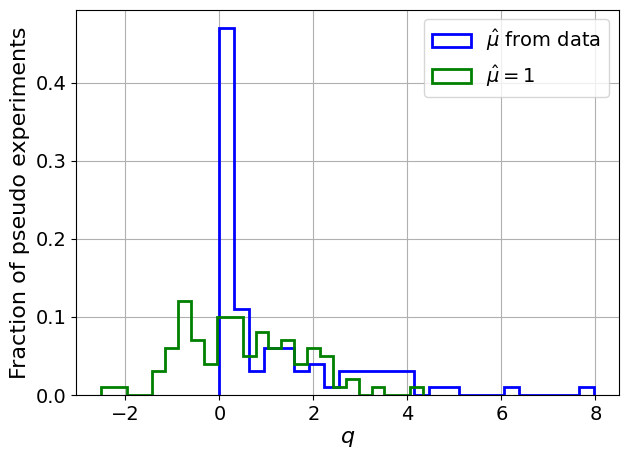

BP15
muhat mean:  1.0020000000000002
Z_MLL:  0.6240704143773281
std Z_MLL:  1.2443240647545795
Z_MLL mu=1:  0.6240704143773281
std Z_MLL mu=1:  0.9887563038657136

--------



In [58]:
D_or_E = "discovery"

Z_MLL_BPs = np.ones(15) * (-99)
Z_MLL_std_BPs = np.ones(15) * (-99)
muhat_MLL = np.ones(15) * (-99)
BPS_analyzed = [0,1,4,7,8,10,11]
for bp in BPS_analyzed:
    pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
    BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
    pred_XG_NP = pred_XG_NP[BP_indices]

    print(str(bp) + ':' + str(len(pred_XG_NP)))
    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    print(np.min(pB_S_data))
    pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
    pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
    print(np.min(pB_S_data))

    print('B_expected: ', int(B_expected))
    print('S_expected: ', int(S_expected[bp]))
    print('')

    Z_MLL = MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = 100)
    #Z_MLL = MLL_test_fsolve(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo, path = '../graph/BP' + str(bp+1) + '/')

    Z_MLL_BPs[bp] = Z_MLL[0]
    Z_MLL_std_BPs[bp] = Z_MLL[1]
    muhat_MLL[bp] = Z_MLL[2]
    
    print('BP' + str(bp+1))
    print('muhat mean: ', Z_MLL[2])
    print('Z_MLL: ', Z_MLL[0])
    print('std Z_MLL: ', Z_MLL[1])
    print('Z_MLL mu=1: ', Z_MLL[3])
    print('std Z_MLL mu=1: ', Z_MLL[4])
    print('')
    print('--------\n')

In [69]:
Z_BL_loops.append( Z_BL_BPs )
Z_BL_std_loops.append( Z_BL_std_BPs )
muhat_BL_loops.append( muhat_BL )

Z_MLL_loops.append( Z_MLL_BPs )
Z_MLL_std_loops.append( Z_MLL_std_BPs )
muhat_MLL_loops.append( muhat_MLL )

In [70]:
Z_BL_loops

[array([1.61742784, 4.91565832, 9.81559275, 1.01938087, 2.77083181,
        5.18535389, 0.68903582, 1.66229492, 2.86751165, 0.44752553,
        1.00442942, 1.64528281, 0.23898325, 0.59479558, 0.92824406]),
 array([1.63939821, 4.93876211, 9.78951277, 1.03879412, 2.70147711,
        5.1881407 , 0.67675746, 1.66848399, 2.8487966 , 0.44534438,
        1.00446409, 1.64746505, 0.2450576 , 0.56420899, 0.89800352]),
 array([1.63298719, 4.94336822, 9.7414877 , 1.0486468 , 2.7212544 ,
        5.18182086, 0.66084886, 1.67370573, 2.85470713, 0.44369918,
        1.02126639, 1.64501824, 0.24646962, 0.56701736, 0.87482832]),
 array([1.62219284, 4.91080195, 9.80677982, 1.0423143 , 2.71581681,
        5.21358426, 0.68550553, 1.68122   , 2.84410208, 0.42751171,
        1.0158027 , 1.63739149, 0.22309389, 0.57799552, 0.91905996]),
 array([1.65243572, 4.98991571, 9.97446616, 1.06225284, 2.73781782,
        5.30121078, 0.67696908, 1.67473994, 2.89160815, 0.44502757,
        1.05223366, 1.65027885, 0.217359

In [71]:
Z_MLL_loops

[array([ 1.89625207,  5.82402461, 12.14807134,  1.33973872,  3.64017683,
         6.78060111,  0.89586163,  2.40534941,  4.14923253,  0.56627527,
         1.50747683,  2.52424797,  0.22293659,  0.92354637,  1.4765148 ]),
 array([ 2.0113726 ,  6.03587633, 11.99260386,  1.31171406,  3.62133909,
         6.76451192,  0.84508333,  2.40634472,  4.11963684,  0.5267313 ,
         1.41294603,  2.40119648,  0.26757174,  0.85396006,  1.38942698]),
 array([ 1.89782102,  6.01927896, 11.84348732,  1.21687036,  3.69722046,
         6.97437653,  0.77234721,  2.3268109 ,  4.03975497,  0.4386778 ,
         1.32692653,  2.35835031,  0.19112112,  0.82328465,  1.33495137]),
 array([ 2.01004437,  6.03070879, 12.06162213,  1.33916315,  3.63776841,
         6.8571966 ,  0.86197175,  2.44978034,  4.1684645 ,  0.52952139,
         1.44929774,  2.43876361,  0.28245145,  0.84535212,  1.42045742]),
 array([ 1.48606577,  5.65690818, 11.88355439,  0.76932348,  3.20275124,
         6.57214642,  0.31036508,  1.986574

In [72]:
Z_BL_loops_ar = np.asarray(Z_BL_loops)
Z_BL_std_loops_ar = np.asarray(Z_BL_std_loops)
muhat_BL_loops_ar = np.asarray(muhat_BL_loops)

Z_MLL_loops_ar = np.asarray(Z_MLL_loops)
Z_MLL_std_loops_ar = np.asarray(Z_MLL_std_loops)
muhat_MLL_loops_ar = np.asarray(muhat_MLL_loops)

In [73]:
np.save('../data/temp_Z_BL_loops_ar.npy', Z_BL_loops_ar)
np.save('../data/temp_Z_BL_std_loops_ar.npy', Z_BL_std_loops_ar)
np.save('../data/temp_muhat_BL_loops_ar.npy', muhat_BL_loops_ar)
np.save('../data/temp_Z_MLL_loops_ar.npy', Z_MLL_loops_ar)
np.save('../data/temp_Z_MLL_std_loops_ar.npy', Z_MLL_std_loops_ar)
np.save('../data/temp_muhat_MLL_loops_ar.npy', muhat_MLL_loops_ar)

In [74]:
for i in range(15):
    print('BP' + str(i+1) + ': Z_BL: ' + str(np.mean(Z_BL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.std(Z_BL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.mean(Z_BL_std_loops_ar, axis = 0)[i]))

BP1: Z_BL: 1.6388802372345428 +/- 0.014135535629295015 +/- 0.8991284454890236
BP2: Z_BL: 4.955444038555751 +/- 0.030100983219725246 +/- 0.8836178695117269
BP3: Z_BL: 9.881463167057458 +/- 0.08563846524613238 +/- 0.8971488075905991
BP4: Z_BL: 1.0483313669905923 +/- 0.013679275966186186 +/- 0.9013557192708006
BP5: Z_BL: 2.7350691795723527 +/- 0.021615307607615524 +/- 0.8765138308168335
BP6: Z_BL: 5.239656287836366 +/- 0.05143642082895909 +/- 0.8625926914177107
BP7: Z_BL: 0.6813970625647656 +/- 0.011345504837109915 +/- 0.9832272593767858
BP8: Z_BL: 1.6749154208744073 +/- 0.008051734979319868 +/- 0.8641969656081402
BP9: Z_BL: 2.867873936928675 +/- 0.020617889098647906 +/- 0.8630156083513704
BP10: Z_BL: 0.4432806749865838 +/- 0.007501989449962005 +/- 0.9777366685340345
BP11: Z_BL: 1.0288108595429066 +/- 0.020861124624452627 +/- 0.9042764872533692
BP12: Z_BL: 1.6515517746102841 +/- 0.011751029292483194 +/- 0.8799873580621668
BP13: Z_BL: 0.22566964432089667 +/- 0.013098728937225811 +/- 1.2043

In [75]:
for i in range(15):
    print('BP' + str(i+1) + ': Z_MLL: ' + str(np.mean(Z_MLL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.std(Z_MLL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.mean(Z_MLL_std_loops_ar, axis = 0)[i]))

BP1: Z_MLL: 1.7130068523100217 +/- 0.25522848317526575 +/- 1.101634827916009
BP2: Z_MLL: 5.802637258140726 +/- 0.2405050835910654 +/- 1.1035782187724572
BP3: Z_MLL: 11.902771805811723 +/- 0.20402709070518332 +/- 1.1145526011768194
BP4: Z_MLL: 1.0268269121460583 +/- 0.2775822887005748 +/- 1.2225166232883768
BP5: Z_MLL: 3.406286791775615 +/- 0.24590486207242204 +/- 1.0435648857184554
BP6: Z_MLL: 6.673496450581922 +/- 0.2063085221594417 +/- 1.045890067721853
BP7: Z_MLL: 0.5710474523260565 +/- 0.26543903622938275 +/- 1.5733923705364732
BP8: Z_MLL: 2.1778098128732255 +/- 0.21862132204188117 +/- 0.9944071835667762
BP9: Z_MLL: 3.9473950593426723 +/- 0.20662774304349213 +/- 0.9842572379242508
BP10: Z_MLL: 0.2538014472605398 +/- 0.25576150236381623 +/- inf
BP11: Z_MLL: 1.1717400750277756 +/- 0.25548387857696875 +/- 1.0068189529465927
BP12: Z_MLL: 2.1996205039441756 +/- 0.2342058173365322 +/- 0.9231690651838861
BP13: Z_MLL: 0.11896993244595314 +/- 0.12122981845608753 +/- inf
BP14: Z_MLL: 0.58971

In [81]:
from scipy.stats import sigmaclip
fact = 2
aux = np.where(Z_MLL_loops_ar[:,10] != 0)[0]
c, low, upp = sigmaclip(Z_MLL_std_loops_ar[aux,10], fact, fact)

In [82]:
for i in range(15):
    aux = np.where(Z_MLL_loops_ar[:,i] != 0)[0]
    print('BP' + str(i+1) + ': Z_BL: ' + str(np.mean(Z_BL_loops_ar[aux,i])) + ' +/- ' + str(np.std(Z_BL_loops_ar[aux,i])) + ' +/- ' + str(np.mean(Z_BL_std_loops_ar[aux,i])))
    #print('BP' + str(i+1) + ': Z_BL: ' + str(np.mean(Z_BL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.std(Z_BL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.mean(Z_BL_std_loops_ar, axis = 0)[i]))

BP1: Z_BL: 1.6388802372345428 +/- 0.014135535629295015 +/- 0.8991284454890236
BP2: Z_BL: 4.955444038555752 +/- 0.030100983219725246 +/- 0.8836178695117269
BP3: Z_BL: 9.881463167057458 +/- 0.08563846524613238 +/- 0.897148807590599
BP4: Z_BL: 1.0483313669905923 +/- 0.013679275966186183 +/- 0.9013557192708006
BP5: Z_BL: 2.7350691795723527 +/- 0.021615307607615524 +/- 0.8765138308168338
BP6: Z_BL: 5.239656287836366 +/- 0.05143642082895909 +/- 0.8625926914177109
BP7: Z_BL: 0.6813970625647656 +/- 0.011345504837109915 +/- 0.9832272593767858
BP8: Z_BL: 1.6749154208744073 +/- 0.008051734979319868 +/- 0.8641969656081404
BP9: Z_BL: 2.867873936928675 +/- 0.020617889098647906 +/- 0.8630156083513704
BP10: Z_BL: 0.44403301639061593 +/- 0.009297473982573443 +/- 0.9670349082177431
BP11: Z_BL: 1.0288108595429066 +/- 0.020861124624452627 +/- 0.9042764872533692
BP12: Z_BL: 1.6515517746102841 +/- 0.011751029292483194 +/- 0.879987358062167
BP13: Z_BL: 0.23167503612201604 +/- 0.015804149438890906 +/- 1.17211

In [83]:
for i in range(15):
    aux = np.where(Z_MLL_loops_ar[:,i] != 0)[0]
    print('BP' + str(i+1) + ': Z_MLL: ' + str(np.mean(Z_MLL_loops_ar[aux,i])) + ' +/- ' + str(np.std(Z_MLL_loops_ar[aux,i])) + ' +/- ' + str(np.mean(sigmaclip(Z_MLL_std_loops_ar[aux,i], 2, 2)[0])))
    #print('BP' + str(i+1) + ': Z_MLL: ' + str(np.mean(Z_MLL_loops_ar[aux,i])) + ' +/- ' + str(np.std(Z_MLL_loops_ar[aux,i])) + ' +/- ' + str(np.mean(Z_MLL_std_loops_ar[aux,i])))
    #print('BP' + str(i+1) + ': Z_MLL: ' + str(np.mean(Z_MLL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.std(Z_MLL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.mean(Z_MLL_std_loops_ar, axis = 0)[i]))

BP1: Z_MLL: 1.7130068523100217 +/- 0.25522848317526575 +/- 1.101634827916009
BP2: Z_MLL: 5.802637258140726 +/- 0.2405050835910654 +/- 1.0993593230805079
BP3: Z_MLL: 11.902771805811721 +/- 0.20402709070518332 +/- 1.1134655952210242
BP4: Z_MLL: 1.026826912146058 +/- 0.2775822887005748 +/- 1.2225166232883766
BP5: Z_MLL: 3.4062867917756146 +/- 0.24590486207242204 +/- 1.0391823485798657
BP6: Z_MLL: 6.67349645058192 +/- 0.2063085221594417 +/- 1.0458900677218528
BP7: Z_MLL: 0.5710474523260565 +/- 0.26543903622938275 +/- 1.5733923705364732
BP8: Z_MLL: 2.177809812873225 +/- 0.21862132204188117 +/- 0.9944071835667762
BP9: Z_MLL: 3.9473950593426728 +/- 0.20662774304349213 +/- 0.984257237924251
BP10: Z_MLL: 0.5076028945210797 +/- 0.0446938801146598 +/- 1.0628203783211727
BP11: Z_MLL: 1.1717400750277756 +/- 0.25548387857696875 +/- 1.0068189529465925
BP12: Z_MLL: 2.1996205039441756 +/- 0.23420581733653223 +/- 0.9231690651838861
BP13: Z_MLL: 0.23793986489190627 +/- 0.03294917469987028 +/- 1.312980836

## loop varying ML

In [27]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       'SM=0 - NP=1']

In [60]:
B_expected

147986

0
AUC:0.93715929030993


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 10115.85188846  9886.26251137  9575.37937767
  9186.25307251  8711.04761588  8130.253545    7438.93835583
  6617.846307    5665.92106767  4547.08249772  3233.38390592
  1696.77511618  -137.42644397 -2323.01197621 -5161.32366699]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
  7616.06865806  7620.40928022  7575.48456663  7474.06254319


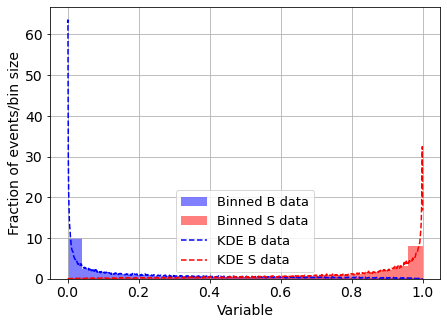

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:20<00:00,  2.09s/it]


Z BP1:6.675841166802846
Z_std BP1:1.0412687201074755
Z_1 BP1:6.571570973561553
Z_std_1 BP1:0.9352794073843657
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Z BP2:11.169257858626018
Z_std BP2:0.9518730281961721
Z_1 BP2:11.17247215789082
Z_std_1 BP2:0.9780465732995738
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


Z BP3:15.635115567228354
Z_std BP3:1.3611527818912537
Z_1 BP3:15.605346144158561
Z_std_1 BP3:1.2773684999222168
3 done
4 done


 40%|██████████████▍                     | 4/10 [00:07<00:10,  1.75s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.372343472149493
<p_{s}(Sdata)> = 6.326279576293694
<p_{b}(Bdata)> = 12.54029515164074
<p_{s}(Bdata)> = 0.2999837194987231


100%|███████████████████████████████████| 10/10 [00:23<00:00,  2.37s/it]


Z BP4:5.378501640320387
Z_std BP4:1.0206205918598317
Z_1 BP4:4.909295855133929
Z_std_1 BP4:0.7842130985041808
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:20<00:00,  2.09s/it]


Z BP5:8.243237469496481
Z_std BP5:0.8531701187825069
Z_1 BP5:8.019927843581673
Z_std_1 BP5:0.772248307141309
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Z BP6:10.972395592807175
Z_std BP6:1.0761789029967148
Z_1 BP6:10.723663882295444
Z_std_1 BP6:0.8537294076405689
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5560947152284402
<p_{s}(Sdata)> = 5.04931710894405
<p_{b}(Bdata)> = 12.584110514063953
<p_{s}(Bdata)> = 0.30063759948182095


 20%|███████▏                            | 2/10 [00:00<00:03,  2.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4157361045805079
<p_{s}(Sdata)> = 3.775354474135197
<p_{b}(Bdata)> = 12.557376713051486
<p_{s}(Bdata)> = 0.3012795807239745


 40%|██████████████▍                     | 4/10 [00:03<00:06,  1.02s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3450430744958761
<p_{s}(Sdata)> = 4.670289152622224
<p_{b}(Bdata)> = 12.607220494629123
<p_{s}(Bdata)> = 0.30037923934336386


 50%|██████████████████                  | 5/10 [00:04<00:04,  1.21it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30760276705666484
<p_{s}(Sdata)> = 4.568194527445336
<p_{b}(Bdata)> = 12.430991284443856
<p_{s}(Bdata)> = 0.30244974367576355


 60%|█████████████████████▌              | 6/10 [00:04<00:02,  1.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3974115690695723
<p_{s}(Sdata)> = 5.164031314980768
<p_{b}(Bdata)> = 12.531338591386982
<p_{s}(Bdata)> = 0.29748904697053347


 80%|████████████████████████████▊       | 8/10 [00:08<00:02,  1.08s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.31999371100631974
<p_{s}(Sdata)> = 4.10851641216
<p_{b}(Bdata)> = 12.527698174526739
<p_{s}(Bdata)> = 0.3008768060491435


100%|███████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3561458056339085
<p_{s}(Sdata)> = 5.502843484926847
<p_{b}(Bdata)> = 12.511530128213263
<p_{s}(Bdata)> = 0.30124208556594967
Z BP7:4.004290507072364
Z_std BP7:0.7917008002872252
Z_1 BP7:3.433647073618899
Z_std_1 BP7:0.5665604749709968
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28027172875950956
<p_{s}(Sdata)> = 5.696277935350573
<p_{b}(Bdata)> = 12.4815010550565
<p_{s}(Bdata)> = 0.3003376521461779


 20%|███████▏                            | 2/10 [00:00<00:03,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.39547049228896775
<p_{s}(Sdata)> = 5.640698686272381
<p_{b}(Bdata)> = 12.481836778338716
<p_{s}(Bdata)> = 0.3002612583363966


 60%|█████████████████████▌              | 6/10 [00:09<00:06,  1.59s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24848306897588696
<p_{s}(Sdata)> = 5.3720053004322175
<p_{b}(Bdata)> = 12.575588009075446
<p_{s}(Bdata)> = 0.3020217527195842


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Z BP8:6.1892947773334335
Z_std BP8:0.7631242432117493
Z_1 BP8:5.690195906127193
Z_std_1 BP8:0.5600034805323334
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21252586271626872
<p_{s}(Sdata)> = 5.960906740108987
<p_{b}(Bdata)> = 12.501160535125969
<p_{s}(Bdata)> = 0.299445773854075


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]


Z BP9:7.191072412667661
Z_std BP9:1.5743256479255148
Z_1 BP9:6.922848544536407
Z_std_1 BP9:1.1868122314413847
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33029480758774293
<p_{s}(Sdata)> = 5.665120228672796
<p_{b}(Bdata)> = 12.590203766349344
<p_{s}(Bdata)> = 0.2980323001672359


 20%|███████▏                            | 2/10 [00:00<00:03,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2603901280076419
<p_{s}(Sdata)> = 5.261111716227772
<p_{b}(Bdata)> = 12.628831563128935
<p_{s}(Bdata)> = 0.2987993781214709


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4090726937483435
<p_{s}(Sdata)> = 7.381643704630184
<p_{b}(Bdata)> = 12.43555153134741
<p_{s}(Bdata)> = 0.29948845158858545


 50%|██████████████████                  | 5/10 [00:04<00:05,  1.00s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3609809503735189
<p_{s}(Sdata)> = 5.668554660142996
<p_{b}(Bdata)> = 12.63170204060731
<p_{s}(Bdata)> = 0.3016877072428474


 60%|█████████████████████▌              | 6/10 [00:04<00:03,  1.21it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.49184415446013646
<p_{s}(Sdata)> = 5.920231510766551
<p_{b}(Bdata)> = 12.640486711003593
<p_{s}(Bdata)> = 0.2973688404513914


 70%|█████████████████████████▏          | 7/10 [00:05<00:02,  1.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.231735248420453
<p_{s}(Sdata)> = 6.572499046443047
<p_{b}(Bdata)> = 12.51978297686595
<p_{s}(Bdata)> = 0.2994313782562732


 80%|████████████████████████████▊       | 8/10 [00:05<00:01,  1.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27021911244467123
<p_{s}(Sdata)> = 7.041089269580683
<p_{b}(Bdata)> = 12.68044313376207
<p_{s}(Bdata)> = 0.2993719739568397


 90%|████████████████████████████████▍   | 9/10 [00:06<00:00,  1.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33273957054890585
<p_{s}(Sdata)> = 6.384559181093798
<p_{b}(Bdata)> = 12.661475325617848
<p_{s}(Bdata)> = 0.29654973021976255


100%|███████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3548702418430682
<p_{s}(Sdata)> = 5.3775890205220644
<p_{b}(Bdata)> = 12.525828557783553
<p_{s}(Bdata)> = 0.29654266866996354
Z BP10:3.0909890381578418
Z_std BP10:0.8529528382441613
Z_1 BP10:2.540250867068805
Z_std_1 BP10:0.5645258215448539
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22713954473888923
<p_{s}(Sdata)> = 7.068962292953781
<p_{b}(Bdata)> = 12.485738025013053
<p_{s}(Bdata)> = 0.29896934908563144


 20%|███████▏                            | 2/10 [00:00<00:03,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20989170540856456
<p_{s}(Sdata)> = 6.395495810324254
<p_{b}(Bdata)> = 12.54460446769667
<p_{s}(Bdata)> = 0.30033239508960985


 40%|██████████████▍                     | 4/10 [00:03<00:05,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2589749235894958
<p_{s}(Sdata)> = 5.095200897605307
<p_{b}(Bdata)> = 12.523252476503936
<p_{s}(Bdata)> = 0.29826460703443386


 50%|██████████████████                  | 5/10 [00:03<00:03,  1.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21859110291101883
<p_{s}(Sdata)> = 6.626212291967375
<p_{b}(Bdata)> = 12.616767977419238
<p_{s}(Bdata)> = 0.29971024571029653


 60%|█████████████████████▌              | 6/10 [00:04<00:02,  1.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28013091571151505
<p_{s}(Sdata)> = 6.681477534653674
<p_{b}(Bdata)> = 12.552738603026471
<p_{s}(Bdata)> = 0.29912262772453063


 70%|█████████████████████████▏          | 7/10 [00:04<00:01,  1.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2574440131753343
<p_{s}(Sdata)> = 4.9075156363932235
<p_{b}(Bdata)> = 12.62144188497255
<p_{s}(Bdata)> = 0.3007959272755352


 90%|████████████████████████████████▍   | 9/10 [00:07<00:00,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29213148858384574
<p_{s}(Sdata)> = 4.885085571199327
<p_{b}(Bdata)> = 12.436004562878018
<p_{s}(Bdata)> = 0.3000191159220098


100%|███████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25853288176073325
<p_{s}(Sdata)> = 5.615052328830243
<p_{b}(Bdata)> = 12.454577845945405
<p_{s}(Bdata)> = 0.2980054060430855
Z BP11:5.062224294596043
Z_std BP11:0.7688305383465408
Z_1 BP11:4.2972470747183
Z_std_1 BP11:0.5328346493981645


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21685190840856092
<p_{s}(Sdata)> = 6.3560409343820545
<p_{b}(Bdata)> = 12.596156393720136
<p_{s}(Bdata)> = 0.2999526410947724


 20%|███████▏                            | 2/10 [00:00<00:03,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23372461044152595
<p_{s}(Sdata)> = 5.571334178271589
<p_{b}(Bdata)> = 12.540835683463554
<p_{s}(Bdata)> = 0.30033032299356593


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2791950346296935
<p_{s}(Sdata)> = 5.350125730544943
<p_{b}(Bdata)> = 12.420321842693516
<p_{s}(Bdata)> = 0.3003048603383427


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25337669296248994
<p_{s}(Sdata)> = 5.5087503026821505
<p_{b}(Bdata)> = 12.591364804133999
<p_{s}(Bdata)> = 0.2991488905299328


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24658875920382853
<p_{s}(Sdata)> = 4.780642293817826
<p_{b}(Bdata)> = 12.678405694235014
<p_{s}(Bdata)> = 0.2983821712923882


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2234194051442986
<p_{s}(Sdata)> = 6.242987789352424
<p_{b}(Bdata)> = 12.539106115227506
<p_{s}(Bdata)> = 0.3024360150575569


 90%|████████████████████████████████▍   | 9/10 [00:09<00:01,  1.36s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2041061239333446
<p_{s}(Sdata)> = 6.275391791539262
<p_{b}(Bdata)> = 12.481097364519556
<p_{s}(Bdata)> = 0.29948452491896443


100%|███████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]


Z BP12:5.749437044042429
Z_std BP12:0.7194005182645787
Z_1 BP12:5.138147932128694
Z_std_1 BP12:0.5043930554713517
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.53554856085687
<p_{s}(Sdata)> = 5.04680068254307
<p_{b}(Bdata)> = 12.517249562261606
<p_{s}(Bdata)> = 0.2978247425018163


 20%|███████▏                            | 2/10 [00:00<00:03,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.47751490294346743
<p_{s}(Sdata)> = 5.446031798564404
<p_{b}(Bdata)> = 12.505067844571132
<p_{s}(Bdata)> = 0.2984487987373142


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.42979384240690516
<p_{s}(Sdata)> = 4.442917646167102
<p_{b}(Bdata)> = 12.481522292727762
<p_{s}(Bdata)> = 0.2994702401746632


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25528971283239954
<p_{s}(Sdata)> = 7.631856730809693
<p_{b}(Bdata)> = 12.471310563921673
<p_{s}(Bdata)> = 0.29865679437322845


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.39047194820459985
<p_{s}(Sdata)> = 9.685759740255563
<p_{b}(Bdata)> = 12.474885027147051
<p_{s}(Bdata)> = 0.29889403237447104


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24410360139232085
<p_{s}(Sdata)> = 7.265612993469337
<p_{b}(Bdata)> = 12.519749639722205
<p_{s}(Bdata)> = 0.30129905862306794


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3459058767509492
<p_{s}(Sdata)> = 3.6718658882023814
<p_{b}(Bdata)> = 12.536442275508445
<p_{s}(Bdata)> = 0.3014675976661928


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.47651859525880796
<p_{s}(Sdata)> = 2.8633906541106913
<p_{b}(Bdata)> = 12.552187998332357
<p_{s}(Bdata)> = 0.2986938005033871


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.35376379487670045
<p_{s}(Sdata)> = 3.017838961883642
<p_{b}(Bdata)> = 12.505949377005427
<p_{s}(Bdata)> = 0.3014608703582556


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2598634570197256
<p_{s}(Sdata)> = 4.421534759395644
<p_{b}(Bdata)> = 12.492439708875983
<p_{s}(Bdata)> = 0.3032566602644002
Z BP13:2.525672813578934
Z_std BP13:0.4396096094852442
Z_1 BP13:1.910462515083672
Z_std_1 BP13:0.29252016496315913
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25152080487700257
<p_{s}(Sdata)> = 5.299549959585817
<p_{b}(Bdata)> = 12.514738477418751
<p_{s}(Bdata)> = 0.29958861714556745


 20%|███████▏                            | 2/10 [00:00<00:03,  2.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32721740600270016
<p_{s}(Sdata)> = 5.283444536285735
<p_{b}(Bdata)> = 12.539954847297508
<p_{s}(Bdata)> = 0.3011378131215259


 40%|██████████████▍                     | 4/10 [00:04<00:06,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2580240355052574
<p_{s}(Sdata)> = 6.296090316783172
<p_{b}(Bdata)> = 12.593385231830867
<p_{s}(Bdata)> = 0.29796612807909906


 50%|██████████████████                  | 5/10 [00:04<00:04,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31122588780767696
<p_{s}(Sdata)> = 6.249319707973886
<p_{b}(Bdata)> = 12.5501603823276
<p_{s}(Bdata)> = 0.30018518472400346


 60%|█████████████████████▌              | 6/10 [00:05<00:02,  1.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2873897529570774
<p_{s}(Sdata)> = 6.924600693852737
<p_{b}(Bdata)> = 12.505559618020685
<p_{s}(Bdata)> = 0.2980657684261051


 70%|█████████████████████████▏          | 7/10 [00:05<00:01,  1.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.208012790107601
<p_{s}(Sdata)> = 5.787131139071775
<p_{b}(Bdata)> = 12.396876370446195
<p_{s}(Bdata)> = 0.3009058174543707


 80%|████████████████████████████▊       | 8/10 [00:06<00:01,  1.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25575206431330977
<p_{s}(Sdata)> = 4.339262466096221
<p_{b}(Bdata)> = 12.586606481271865
<p_{s}(Bdata)> = 0.2988937433743256


 90%|████████████████████████████████▍   | 9/10 [00:06<00:00,  1.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3119306607166663
<p_{s}(Sdata)> = 5.163308981708175
<p_{b}(Bdata)> = 12.576320565531946
<p_{s}(Bdata)> = 0.29854323635951896


100%|███████████████████████████████████| 10/10 [00:06<00:00,  1.43it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23743450659934684
<p_{s}(Sdata)> = 4.820104970734219
<p_{b}(Bdata)> = 12.593848765411188
<p_{s}(Bdata)> = 0.2983757709320704
Z BP14:3.332665131379873
Z_std BP14:0.4866228386463208
Z_1 BP14:2.710179628253853
Z_std_1 BP14:0.33670141763082473
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.216468529030746
<p_{s}(Sdata)> = 5.96381010837706
<p_{b}(Bdata)> = 12.629432241092267
<p_{s}(Bdata)> = 0.2977898918816142


 20%|███████▏                            | 2/10 [00:00<00:03,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24333331373914432
<p_{s}(Sdata)> = 5.074709807938996
<p_{b}(Bdata)> = 12.562870178737223
<p_{s}(Bdata)> = 0.30023341489854444


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24575265251152933
<p_{s}(Sdata)> = 5.254147424381901
<p_{b}(Bdata)> = 12.636739117151608
<p_{s}(Bdata)> = 0.2994986800742677


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24759517476042983
<p_{s}(Sdata)> = 5.8822251744200775
<p_{b}(Bdata)> = 12.61653264700321
<p_{s}(Bdata)> = 0.30043872463076526


 60%|█████████████████████▌              | 6/10 [00:04<00:03,  1.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23188444731753585
<p_{s}(Sdata)> = 6.061218823572074
<p_{b}(Bdata)> = 12.548716331198005
<p_{s}(Bdata)> = 0.3023306263283984


 70%|█████████████████████████▏          | 7/10 [00:05<00:02,  1.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20671065151788656
<p_{s}(Sdata)> = 7.094967186896599
<p_{b}(Bdata)> = 12.518411572614463
<p_{s}(Bdata)> = 0.2976348946625357


 80%|████████████████████████████▊       | 8/10 [00:05<00:01,  1.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24218129913253053
<p_{s}(Sdata)> = 5.034244507017046
<p_{b}(Bdata)> = 12.632152941215654
<p_{s}(Bdata)> = 0.3012654092155615


 90%|████████████████████████████████▍   | 9/10 [00:06<00:00,  1.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2690187427786565
<p_{s}(Sdata)> = 5.466954971479046
<p_{b}(Bdata)> = 12.555035947563386
<p_{s}(Bdata)> = 0.2997738848664458


100%|███████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17396961284009768
<p_{s}(Sdata)> = 7.874756922915863
<p_{b}(Bdata)> = 12.588964484267176
<p_{s}(Bdata)> = 0.2974139406447744
Z BP15:4.350005502818491
Z_std BP15:0.738103432545223
Z_1 BP15:3.640480200037355
Z_std_1 BP15:0.4731082852433577
1


AUC:0.9368395413432902


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 10475.97383575 10293.88687434 10051.90430226  9730.31033233
  9321.68071375  8822.9505226   8214.51005327  7495.15714556
  6663.80244989  5696.54188951  4577.03345418  3282.65301995
  1742.52961736  -100.83437222 -2277.93777725 -5145.63148222]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  7415.08349297


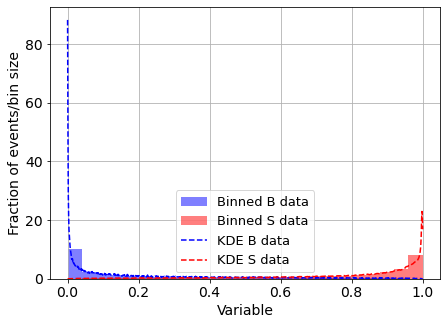

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:23<00:00,  2.37s/it]


Z BP1:8.328917399030994
Z_std BP1:1.778033252393435
Z_1 BP1:7.99129750891139
Z_std_1 BP1:1.7202547218663333
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:20<00:00,  2.10s/it]


Z BP2:14.601903112657784
Z_std BP2:2.224455232287685
Z_1 BP2:14.366627744164417
Z_std_1 BP2:2.1899192295976646
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:24<00:00,  2.40s/it]


Z BP3:19.906616951484942
Z_std BP3:2.579320462569143
Z_1 BP3:19.2744364204182
Z_std_1 BP3:2.5453464981540774
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3417362718393497
<p_{s}(Sdata)> = 4.209258743457994
<p_{b}(Bdata)> = 15.368350038024571
<p_{s}(Bdata)> = 0.3076727166262805


 30%|██████████▊                         | 3/10 [00:03<00:08,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.42152862888242404
<p_{s}(Sdata)> = 3.164467784537412
<p_{b}(Bdata)> = 15.251351540653824
<p_{s}(Bdata)> = 0.31003413590465356


 40%|██████████████▍                     | 4/10 [00:04<00:05,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5195173096865794
<p_{s}(Sdata)> = 3.943977241669031
<p_{b}(Bdata)> = 15.404404476777716
<p_{s}(Bdata)> = 0.3079164724121663


 50%|██████████████████                  | 5/10 [00:04<00:03,  1.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5015214192450769
<p_{s}(Sdata)> = 3.9739053623664184
<p_{b}(Bdata)> = 15.348047980191794
<p_{s}(Bdata)> = 0.30731546927336917


 80%|████████████████████████████▊       | 8/10 [00:10<00:02,  1.44s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3577779743393784
<p_{s}(Sdata)> = 4.103698017599361
<p_{b}(Bdata)> = 15.476483232722769
<p_{s}(Bdata)> = 0.30673054830093005


100%|███████████████████████████████████| 10/10 [00:13<00:00,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.398404899625728
<p_{s}(Sdata)> = 3.6995614378337778
<p_{b}(Bdata)> = 15.286784268200549
<p_{s}(Bdata)> = 0.3096935892988054
Z BP4:5.942370822383766
Z_std BP4:3.672207849981024
Z_1 BP4:5.258498296391831
Z_std_1 BP4:3.7373523469195495


3 done
4 done


 50%|██████████████████                  | 5/10 [00:09<00:08,  1.62s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.30898497372471534
<p_{s}(Sdata)> = 3.926274791037905
<p_{b}(Bdata)> = 15.557281627539037
<p_{s}(Bdata)> = 0.3090670534253784


 60%|█████████████████████▌              | 6/10 [00:10<00:04,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.271209208280548
<p_{s}(Sdata)> = 4.041082405782737
<p_{b}(Bdata)> = 15.412379555197765
<p_{s}(Bdata)> = 0.31102960208981717


 70%|█████████████████████████▏          | 7/10 [00:10<00:02,  1.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27543097190935295
<p_{s}(Sdata)> = 4.326594025762099
<p_{b}(Bdata)> = 15.355756939710192
<p_{s}(Bdata)> = 0.30969432835180705


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]


Z BP5:10.126575854782578
Z_std BP5:2.089866786983535
Z_1 BP5:9.338101464232262
Z_std_1 BP5:2.0051089169709524
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:24<00:00,  2.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21254656160689547
<p_{s}(Sdata)> = 5.02026604009707
<p_{b}(Bdata)> = 15.479895576681377
<p_{s}(Bdata)> = 0.30820410372507406
Z BP6:13.805740774580393
Z_std BP6:1.6623522466008809
Z_1 BP6:13.118163011195914
Z_std_1 BP6:1.44113314604999


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.40884182107666284
<p_{s}(Sdata)> = 4.841379561249254
<p_{b}(Bdata)> = 15.315210935855937
<p_{s}(Bdata)> = 0.30939790299158165


 20%|███████▏                            | 2/10 [00:00<00:03,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.35217452796271087
<p_{s}(Sdata)> = 4.336840240297232
<p_{b}(Bdata)> = 15.376807100929236
<p_{s}(Bdata)> = 0.30785236822359313


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4790709727141816
<p_{s}(Sdata)> = 6.177570586633489
<p_{b}(Bdata)> = 15.236033041185014
<p_{s}(Bdata)> = 0.30803671391594967


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2944208296368089
<p_{s}(Sdata)> = 5.1458319041442655
<p_{b}(Bdata)> = 15.338255361325366
<p_{s}(Bdata)> = 0.307275347895613


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4095436181045153
<p_{s}(Sdata)> = 4.808029675043021
<p_{b}(Bdata)> = 15.39629558253287
<p_{s}(Bdata)> = 0.30691084197500246


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4032720370637822
<p_{s}(Sdata)> = 5.759151092887863
<p_{b}(Bdata)> = 15.432867408420421
<p_{s}(Bdata)> = 0.30666467996268987


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34512089745226626
<p_{s}(Sdata)> = 4.146889485847618
<p_{b}(Bdata)> = 15.273252153592667
<p_{s}(Bdata)> = 0.307976277193831


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.40103986657142177
<p_{s}(Sdata)> = 4.283595200754486
<p_{b}(Bdata)> = 15.421153309208165
<p_{s}(Bdata)> = 0.3089985094882817


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2882501266645987
<p_{s}(Sdata)> = 6.162340172314571
<p_{b}(Bdata)> = 15.412000140229615
<p_{s}(Bdata)> = 0.3089849017013651


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4433716513228605
<p_{s}(Sdata)> = 3.407355691670536
<p_{b}(Bdata)> = 15.540439091786697
<p_{s}(Bdata)> = 0.3066896908457705
Z BP7:5.766648610076124
Z_std BP7:0.8064425646873526
Z_1 BP7:4.7143788857678945
Z_std_1 BP7:0.6432643132446243
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23121451550797664
<p_{s}(Sdata)> = 4.795557895221485
<p_{b}(Bdata)> = 15.458777037734777
<p_{s}(Bdata)> = 0.3047936249568269


 20%|███████▏                            | 2/10 [00:00<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3312914193827253
<p_{s}(Sdata)> = 4.01279899874338
<p_{b}(Bdata)> = 15.446080382750619
<p_{s}(Bdata)> = 0.30747119044388166


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2502009456998127
<p_{s}(Sdata)> = 4.453332072817034
<p_{b}(Bdata)> = 15.359682127210712
<p_{s}(Bdata)> = 0.30665120010287855


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29964275317190714
<p_{s}(Sdata)> = 4.746639140701287
<p_{b}(Bdata)> = 15.294543634046097
<p_{s}(Bdata)> = 0.3081060390310104


 60%|█████████████████████▌              | 6/10 [00:04<00:03,  1.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3070830177638796
<p_{s}(Sdata)> = 3.8691810781552802
<p_{b}(Bdata)> = 15.311604674491322
<p_{s}(Bdata)> = 0.3078880973068232


 70%|█████████████████████████▏          | 7/10 [00:04<00:02,  1.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24700550964131798
<p_{s}(Sdata)> = 4.516694531648377
<p_{b}(Bdata)> = 15.421737822917112
<p_{s}(Bdata)> = 0.3069010706631885


 90%|████████████████████████████████▍   | 9/10 [00:08<00:01,  1.11s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2520405258761867
<p_{s}(Sdata)> = 5.983529233414919
<p_{b}(Bdata)> = 15.252392843545369
<p_{s}(Bdata)> = 0.30891744469361515


100%|███████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


Z BP8:7.348781211972394
Z_std BP8:2.5507277877736465
Z_1 BP8:6.609216852040334
Z_std_1 BP8:2.253554589551119
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2248086228139264
<p_{s}(Sdata)> = 5.181264112294641
<p_{b}(Bdata)> = 15.551433045521833
<p_{s}(Bdata)> = 0.3060476391848189


 20%|███████▏                            | 2/10 [00:00<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37064082875587445
<p_{s}(Sdata)> = 6.076283548762371
<p_{b}(Bdata)> = 15.356509184273923
<p_{s}(Bdata)> = 0.3072181733644631


 40%|██████████████▍                     | 4/10 [00:04<00:06,  1.15s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2360163310600432
<p_{s}(Sdata)> = 4.872707154427444
<p_{b}(Bdata)> = 15.416993057799878
<p_{s}(Bdata)> = 0.30860343594089634


 50%|██████████████████                  | 5/10 [00:04<00:04,  1.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23994404688357057
<p_{s}(Sdata)> = 5.2906866339788685
<p_{b}(Bdata)> = 15.434693482909573
<p_{s}(Bdata)> = 0.30790277793368614


100%|███████████████████████████████████| 10/10 [00:15<00:00,  1.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2491099896318156
<p_{s}(Sdata)> = 4.328774374817465
<p_{b}(Bdata)> = 15.473648395253045
<p_{s}(Bdata)> = 0.30699318029742595
Z BP9:9.487603676201868
Z_std BP9:1.9455133720265234
Z_1 BP9:8.505161800660714
Z_std_1 BP9:1.6440235506729508


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2615049465865863
<p_{s}(Sdata)> = 5.185476987072547
<p_{b}(Bdata)> = 15.393819351574601
<p_{s}(Bdata)> = 0.3075144035664164


 20%|███████▏                            | 2/10 [00:00<00:03,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.564537446220023
<p_{s}(Sdata)> = 3.6020073521002884
<p_{b}(Bdata)> = 15.295239598633948
<p_{s}(Bdata)> = 0.3091853951222822


 40%|██████████████▍                     | 4/10 [00:04<00:06,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2593129421545184
<p_{s}(Sdata)> = 7.966418912816547
<p_{b}(Bdata)> = 15.375853356398586
<p_{s}(Bdata)> = 0.3060895386098131


 50%|██████████████████                  | 5/10 [00:04<00:04,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32283160063594374
<p_{s}(Sdata)> = 5.602628269392933
<p_{b}(Bdata)> = 15.532416021658314
<p_{s}(Bdata)> = 0.30715939992061425


 60%|█████████████████████▌              | 6/10 [00:05<00:02,  1.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24922128354166245
<p_{s}(Sdata)> = 5.7180938200497
<p_{b}(Bdata)> = 15.435560842481502
<p_{s}(Bdata)> = 0.3059641088740742


 70%|█████████████████████████▏          | 7/10 [00:05<00:01,  1.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33350544331827364
<p_{s}(Sdata)> = 4.31420766103574
<p_{b}(Bdata)> = 15.344419629845959
<p_{s}(Bdata)> = 0.3048875083488816


 80%|████████████████████████████▊       | 8/10 [00:06<00:01,  1.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31199999495205066
<p_{s}(Sdata)> = 5.753550762091917
<p_{b}(Bdata)> = 15.400467609205041
<p_{s}(Bdata)> = 0.30466564697911486


 90%|████████████████████████████████▍   | 9/10 [00:06<00:00,  1.75it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26045905825116866
<p_{s}(Sdata)> = 6.546435556518922
<p_{b}(Bdata)> = 15.353790484776852
<p_{s}(Bdata)> = 0.305237423214198


100%|███████████████████████████████████| 10/10 [00:07<00:00,  1.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23034131906520466
<p_{s}(Sdata)> = 6.630329358166138
<p_{b}(Bdata)> = 15.420661176167734
<p_{s}(Bdata)> = 0.30872550612203414
Z BP10:3.852996242178003
Z_std BP10:1.6274352612897887
Z_1 BP10:3.0110337981155366
Z_std_1 BP10:1.4217596770421335
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31006697725550236
<p_{s}(Sdata)> = 4.621659365477932
<p_{b}(Bdata)> = 15.493673771594265
<p_{s}(Bdata)> = 0.3051383364895547


 20%|███████▏                            | 2/10 [00:00<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3274946444150669
<p_{s}(Sdata)> = 5.17533247709957
<p_{b}(Bdata)> = 15.408678371687545
<p_{s}(Bdata)> = 0.3053822391342406


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24313420640048364
<p_{s}(Sdata)> = 4.698252767978839
<p_{b}(Bdata)> = 15.425812090984568
<p_{s}(Bdata)> = 0.30976239904338243


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24144596788310468
<p_{s}(Sdata)> = 4.337423100881936
<p_{b}(Bdata)> = 15.493721912635298
<p_{s}(Bdata)> = 0.30853200005434733


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2754896206382928
<p_{s}(Sdata)> = 4.668177587361061
<p_{b}(Bdata)> = 15.556740412282743
<p_{s}(Bdata)> = 0.30628991010363105


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29170188482701775
<p_{s}(Sdata)> = 4.89353007552706
<p_{b}(Bdata)> = 15.311637391535418
<p_{s}(Bdata)> = 0.30819020243207973


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3331804616282663
<p_{s}(Sdata)> = 4.7772560420864405
<p_{b}(Bdata)> = 15.48448838375378
<p_{s}(Bdata)> = 0.3107649824458013


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2518392631544419
<p_{s}(Sdata)> = 4.832379777997093
<p_{b}(Bdata)> = 15.3641605515404
<p_{s}(Bdata)> = 0.30627347895614926


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29851069790144175
<p_{s}(Sdata)> = 3.9805517766533325
<p_{b}(Bdata)> = 15.223730829868142
<p_{s}(Bdata)> = 0.3092796803338436


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21951753275726635
<p_{s}(Sdata)> = 5.899505255031607
<p_{b}(Bdata)> = 15.350427008624958
<p_{s}(Bdata)> = 0.30730611841545424
Z BP11:5.269186490394888
Z_std BP11:3.8358950384149417
Z_1 BP11:4.410829816734219
Z_std_1 BP11:4.033808475516186
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21903181956592
<p_{s}(Sdata)> = 4.33663051260639
<p_{b}(Bdata)> = 15.313685226876501
<p_{s}(Bdata)> = 0.30590096872900474


 20%|███████▏                            | 2/10 [00:00<00:03,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21708131768806396
<p_{s}(Sdata)> = 5.441206954045218
<p_{b}(Bdata)> = 15.415954988270322
<p_{s}(Bdata)> = 0.307706154492521


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22168691986330294
<p_{s}(Sdata)> = 4.632902112772999
<p_{b}(Bdata)> = 15.397924055965886
<p_{s}(Bdata)> = 0.3065466726279808


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26217958401761615
<p_{s}(Sdata)> = 5.201853984343105
<p_{b}(Bdata)> = 15.3586193841621
<p_{s}(Bdata)> = 0.3074621973662447


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20541623259442904
<p_{s}(Sdata)> = 5.280050504662443
<p_{b}(Bdata)> = 15.374234982784584
<p_{s}(Bdata)> = 0.3064143290497627


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2510705835231537
<p_{s}(Sdata)> = 4.820974742055252
<p_{b}(Bdata)> = 15.415512951198693
<p_{s}(Bdata)> = 0.30665636742790725


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22995038571125684
<p_{s}(Sdata)> = 4.939805699587621
<p_{b}(Bdata)> = 15.40110386413677
<p_{s}(Bdata)> = 0.30907714195453667


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21169952304675707
<p_{s}(Sdata)> = 4.732015724467454
<p_{b}(Bdata)> = 15.339455666310661
<p_{s}(Bdata)> = 0.3091039708219344


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2558670147346903
<p_{s}(Sdata)> = 4.291249218703008
<p_{b}(Bdata)> = 15.523390673107189
<p_{s}(Bdata)> = 0.3075792101048728


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2482126489074684
<p_{s}(Sdata)> = 5.172238204349785
<p_{b}(Bdata)> = 15.373970112648983
<p_{s}(Bdata)> = 0.3073575794175712
Z BP12:6.331451131956027
Z_std BP12:1.2277308603897947
Z_1 BP12:5.3778272929192115
Z_std_1 BP12:1.0634771899670723


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3284653151938725
<p_{s}(Sdata)> = 5.2282746207173005
<p_{b}(Bdata)> = 15.38182688453746
<p_{s}(Bdata)> = 0.3078515411104955


 20%|███████▏                            | 2/10 [00:00<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21424843967313928
<p_{s}(Sdata)> = 6.5425633289683605
<p_{b}(Bdata)> = 15.493788893866915
<p_{s}(Bdata)> = 0.3066252308114471


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.35494421798629855
<p_{s}(Sdata)> = 7.921109817923761
<p_{b}(Bdata)> = 15.405170139835342
<p_{s}(Bdata)> = 0.3053176520379075


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3225976494703409
<p_{s}(Sdata)> = 4.205406617600472
<p_{b}(Bdata)> = 15.461726416474342
<p_{s}(Bdata)> = 0.304374120894373


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.46032099601176907
<p_{s}(Sdata)> = 4.898450018248887
<p_{b}(Bdata)> = 15.349253745285242
<p_{s}(Bdata)> = 0.30588090954159797


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29020325909406847
<p_{s}(Sdata)> = 6.489295892205575
<p_{b}(Bdata)> = 15.563419547125413
<p_{s}(Bdata)> = 0.30662668444071084


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.346406202136663
<p_{s}(Sdata)> = 5.010640581575113
<p_{b}(Bdata)> = 15.492101653346625
<p_{s}(Bdata)> = 0.3075124844828443


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4227581912012435
<p_{s}(Sdata)> = 2.4923196908740777
<p_{b}(Bdata)> = 15.388825811606972
<p_{s}(Bdata)> = 0.3052333395580008


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3480268194392833
<p_{s}(Sdata)> = 5.759771071312488
<p_{b}(Bdata)> = 15.282360835885095
<p_{s}(Bdata)> = 0.30689915713557664


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1758961366789541
<p_{s}(Sdata)> = 5.403098695580177
<p_{b}(Bdata)> = 15.435729811743965
<p_{s}(Bdata)> = 0.30555383004628117
Z BP13:2.860233223293766
Z_std BP13:0.8463214145187938
Z_1 BP13:2.165545035161697
Z_std_1 BP13:0.6988847804570353
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2393807024848317
<p_{s}(Sdata)> = 4.319098714607922
<p_{b}(Bdata)> = 15.495329197246479
<p_{s}(Bdata)> = 0.3069251975233194


 20%|███████▏                            | 2/10 [00:00<00:03,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21250145088555722
<p_{s}(Sdata)> = 5.518731000919371
<p_{b}(Bdata)> = 15.338130343175743
<p_{s}(Bdata)> = 0.30603205551301266


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23477559738068962
<p_{s}(Sdata)> = 7.610307226518443
<p_{b}(Bdata)> = 15.471023032198755
<p_{s}(Bdata)> = 0.30719119496040964


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27076453132003997
<p_{s}(Sdata)> = 4.164802946721808
<p_{b}(Bdata)> = 15.469235274661907
<p_{s}(Bdata)> = 0.3057316186698939


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19196134319741986
<p_{s}(Sdata)> = 5.9575590058704995
<p_{b}(Bdata)> = 15.393957691609788
<p_{s}(Bdata)> = 0.3039322721757334


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21776154909662013
<p_{s}(Sdata)> = 7.550374441795854
<p_{b}(Bdata)> = 15.385057260315355
<p_{s}(Bdata)> = 0.3069907275928848


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23473818264365864
<p_{s}(Sdata)> = 6.808696546315635
<p_{b}(Bdata)> = 15.452539627225201
<p_{s}(Bdata)> = 0.30445543459914726


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23999253186541908
<p_{s}(Sdata)> = 5.293034899126287
<p_{b}(Bdata)> = 15.370592717551194
<p_{s}(Bdata)> = 0.30561997049827166


100%|███████████████████████████████████| 10/10 [00:06<00:00,  1.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2557294566351603
<p_{s}(Sdata)> = 4.702348189569595
<p_{b}(Bdata)> = 15.347704831505194
<p_{s}(Bdata)> = 0.3093308514517318
Z BP14:4.0108693841799585
Z_std BP14:0.9724379191748346
Z_1 BP14:3.2029174414954578
Z_std_1 BP14:0.740650347970554
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20400112784954627
<p_{s}(Sdata)> = 5.978964242087415
<p_{b}(Bdata)> = 15.358335780438518
<p_{s}(Bdata)> = 0.3036661290200715


 20%|███████▏                            | 2/10 [00:00<00:03,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18821428647921565
<p_{s}(Sdata)> = 6.571841109042799
<p_{b}(Bdata)> = 15.417864688274577
<p_{s}(Bdata)> = 0.3065851453532654


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2012034479792644
<p_{s}(Sdata)> = 6.499817518755443
<p_{b}(Bdata)> = 15.600631251490665
<p_{s}(Bdata)> = 0.30466419728987476


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22630932506889087
<p_{s}(Sdata)> = 5.012436696556562
<p_{b}(Bdata)> = 15.336764574435222
<p_{s}(Bdata)> = 0.3097041864117671


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26061401925425737
<p_{s}(Sdata)> = 5.539056069328256
<p_{b}(Bdata)> = 15.459508225898087
<p_{s}(Bdata)> = 0.30674585032188584


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18483339087487885
<p_{s}(Sdata)> = 5.816344632798054
<p_{b}(Bdata)> = 15.439533324896683
<p_{s}(Bdata)> = 0.3084674013065899


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2665058216309149
<p_{s}(Sdata)> = 5.70706338925119
<p_{b}(Bdata)> = 15.414958217451568
<p_{s}(Bdata)> = 0.3059051844582717


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23438591520078805
<p_{s}(Sdata)> = 6.490566640060262
<p_{b}(Bdata)> = 15.314122212116798
<p_{s}(Bdata)> = 0.3092003484687359


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33974258576548705
<p_{s}(Sdata)> = 4.44419014921449
<p_{b}(Bdata)> = 15.31752514146656
<p_{s}(Bdata)> = 0.3059894565407409


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2441098381830135
<p_{s}(Sdata)> = 5.282831970925745
<p_{b}(Bdata)> = 15.431156341842664
<p_{s}(Bdata)> = 0.30752154696370726
Z BP15:5.036695792233879
Z_std BP15:1.1770528642448166
Z_1 BP15:4.028961199548176
Z_std_1 BP15:1.0287314122386837
2


AUC:0.9371753915178455


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 10032.2421646   9701.35593407
  9288.44840996  8793.37309647  8190.66116298  7479.40213493
  6651.89018577  5669.26721715  4528.85398703  3232.28577635
  1691.4797128   -145.83858056 -2320.90018693 -5159.86555019]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7778.87955543  7708.88344336  7582.56854386


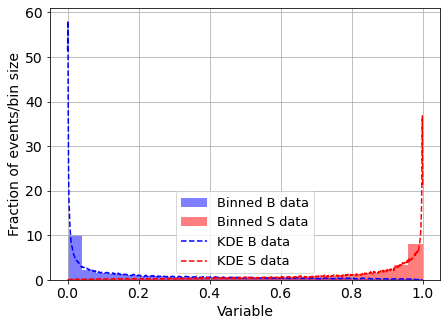

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Z BP1:7.15206658972925
Z_std BP1:0.9129633148875247
Z_1 BP1:7.128261163396344
Z_std_1 BP1:0.9528199095031258
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Z BP2:12.587169621005538
Z_std BP2:0.8442635131857172
Z_1 BP2:12.587053024318182
Z_std_1 BP2:0.876019195820009
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


Z BP3:18.719525988849398
Z_std BP3:0.9343816184900825
Z_1 BP3:18.633234435790545
Z_std_1 BP3:0.8979713755586033
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  1.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.36854343367867887
<p_{s}(Sdata)> = 3.7841534283306744
<p_{b}(Bdata)> = 11.598166210156664
<p_{s}(Bdata)> = 0.30480140984504783


 20%|███████▏                            | 2/10 [00:01<00:04,  2.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.35741130812407057
<p_{s}(Sdata)> = 3.9594805075798645
<p_{b}(Bdata)> = 11.59970724115632
<p_{s}(Bdata)> = 0.3044937761799493


 90%|████████████████████████████████▍   | 9/10 [00:16<00:01,  1.66s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4250311938469367
<p_{s}(Sdata)> = 4.313651757562739
<p_{b}(Bdata)> = 11.58004828749735
<p_{s}(Bdata)> = 0.3061910918069109


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Z BP4:6.3514334390742135
Z_std BP4:1.1375794950736966
Z_1 BP4:5.969923431868155
Z_std_1 BP4:0.8926642412856819
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.18s/it]


Z BP5:9.848639885249176
Z_std BP5:0.9234183782770088
Z_1 BP5:9.608469768864786
Z_std_1 BP5:0.844356334759532
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:22<00:00,  2.21s/it]


Z BP6:11.712073961787054
Z_std BP6:1.8227940644626082
Z_1 BP6:11.57453752824213
Z_std_1 BP6:1.5238547470390447
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37590574423962214
<p_{s}(Sdata)> = 5.870573845433023
<p_{b}(Bdata)> = 11.545909544219139
<p_{s}(Bdata)> = 0.3036762967772131


 20%|███████▏                            | 2/10 [00:00<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3667953605611415
<p_{s}(Sdata)> = 5.2820375628935174
<p_{b}(Bdata)> = 11.72332245538222
<p_{s}(Bdata)> = 0.30356753313994234


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5125441654329869
<p_{s}(Sdata)> = 4.3883202184156
<p_{b}(Bdata)> = 11.671815445195431
<p_{s}(Bdata)> = 0.30397573234586417


 60%|█████████████████████▌              | 6/10 [00:07<00:05,  1.42s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3447226015029147
<p_{s}(Sdata)> = 6.151673076479405
<p_{b}(Bdata)> = 11.65729263165162
<p_{s}(Bdata)> = 0.3004390245372159


 70%|█████████████████████████▏          | 7/10 [00:08<00:03,  1.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3341570789160881
<p_{s}(Sdata)> = 6.471770412084828
<p_{b}(Bdata)> = 11.644549463280722
<p_{s}(Bdata)> = 0.30144845661910313


 80%|████████████████████████████▊       | 8/10 [00:08<00:01,  1.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3565414650343372
<p_{s}(Sdata)> = 3.735830566916351
<p_{b}(Bdata)> = 11.664603145006517
<p_{s}(Bdata)> = 0.30579738535394624


 90%|████████████████████████████████▍   | 9/10 [00:09<00:00,  1.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33440029871544014
<p_{s}(Sdata)> = 5.427245020935838
<p_{b}(Bdata)> = 11.630406789180793
<p_{s}(Bdata)> = 0.30348951768643034


100%|███████████████████████████████████| 10/10 [00:09<00:00,  1.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5807826815918579
<p_{s}(Sdata)> = 3.7891325229672947
<p_{b}(Bdata)> = 11.662834566621036
<p_{s}(Bdata)> = 0.3020571165611044
Z BP7:5.6056921037742145
Z_std BP7:0.6957586323745751
Z_1 BP7:4.795320272885384
Z_std_1 BP7:0.49492297816919106


3 done
4 done


 70%|█████████████████████████▏          | 7/10 [00:13<00:05,  1.69s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2558063967016299
<p_{s}(Sdata)> = 5.093726895810901
<p_{b}(Bdata)> = 11.715209867389198
<p_{s}(Bdata)> = 0.3044804212617326


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.16s/it]


Z BP8:6.2541887255017095
Z_std BP8:1.1922320120063759
Z_1 BP8:6.006248086038294
Z_std_1 BP8:0.9348265989300582
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  1.98it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21913145262477546
<p_{s}(Sdata)> = 5.5662322608961805
<p_{b}(Bdata)> = 11.558374384455622
<p_{s}(Bdata)> = 0.30575126560392196


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21605022109833863
<p_{s}(Sdata)> = 6.050522268502511
<p_{b}(Bdata)> = 11.709223856872454
<p_{s}(Bdata)> = 0.30388636674625413
Z BP9:9.474193887268882
Z_std BP9:1.1976709237809244
Z_1 BP9:9.047260203237045
Z_std_1 BP9:0.9794935654181245


3 done
4 done


 20%|███████▏                            | 2/10 [00:02<00:08,  1.03s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.27345145850552177
<p_{s}(Sdata)> = 6.632528863098325
<p_{b}(Bdata)> = 11.533065356076818
<p_{s}(Bdata)> = 0.3015103768484518


 30%|██████████▊                         | 3/10 [00:02<00:05,  1.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.7342272794995147
<p_{s}(Sdata)> = 3.6789410177142012
<p_{b}(Bdata)> = 11.558998286414518
<p_{s}(Bdata)> = 0.30429238350591137


 40%|██████████████▍                     | 4/10 [00:03<00:04,  1.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3468522076991829
<p_{s}(Sdata)> = 6.793681683513455
<p_{b}(Bdata)> = 11.679072028035597
<p_{s}(Bdata)> = 0.30091298775857767


 50%|██████████████████                  | 5/10 [00:03<00:03,  1.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2482316032331323
<p_{s}(Sdata)> = 5.61877504542607
<p_{b}(Bdata)> = 11.622148461339153
<p_{s}(Bdata)> = 0.30314343916796843


 60%|█████████████████████▌              | 6/10 [00:04<00:02,  1.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26882992982989845
<p_{s}(Sdata)> = 6.28602776243722
<p_{b}(Bdata)> = 11.652945276837261
<p_{s}(Bdata)> = 0.30292599477214843


 70%|█████████████████████████▏          | 7/10 [00:04<00:01,  1.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31592073557501593
<p_{s}(Sdata)> = 4.478402786802839
<p_{b}(Bdata)> = 11.547851453913678
<p_{s}(Bdata)> = 0.3035589217611994


 80%|████████████████████████████▊       | 8/10 [00:05<00:01,  1.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2523220979846229
<p_{s}(Sdata)> = 6.909236889911509
<p_{b}(Bdata)> = 11.665756157769964
<p_{s}(Bdata)> = 0.3013697615221083


 90%|████████████████████████████████▍   | 9/10 [00:05<00:00,  1.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4148530089540237
<p_{s}(Sdata)> = 6.012116744048953
<p_{b}(Bdata)> = 11.710560442995506
<p_{s}(Bdata)> = 0.3012032056846257


100%|███████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3668642354143834
<p_{s}(Sdata)> = 6.675708857730551
<p_{b}(Bdata)> = 11.57980144872578
<p_{s}(Bdata)> = 0.30388534510478976
Z BP10:4.549052964812064
Z_std BP10:0.7331539611717561
Z_1 BP10:3.784879072844321
Z_std_1 BP10:0.5626863315098604


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22429044196944498
<p_{s}(Sdata)> = 6.284542270651177
<p_{b}(Bdata)> = 11.584789426387701
<p_{s}(Bdata)> = 0.30512650238403916


 20%|███████▏                            | 2/10 [00:00<00:03,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2786999925420638
<p_{s}(Sdata)> = 6.319778299054347
<p_{b}(Bdata)> = 11.632478979375586
<p_{s}(Bdata)> = 0.30215463320507374


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21929045052541746
<p_{s}(Sdata)> = 6.405007357263545
<p_{b}(Bdata)> = 11.632187933319534
<p_{s}(Bdata)> = 0.30216822887975414


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2683394099307795
<p_{s}(Sdata)> = 6.180527706056462
<p_{b}(Bdata)> = 11.56018931621375
<p_{s}(Bdata)> = 0.30200914886420777


 80%|████████████████████████████▊       | 8/10 [00:10<00:03,  1.58s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.253368653596254
<p_{s}(Sdata)> = 5.888837306900389
<p_{b}(Bdata)> = 11.73892351835852
<p_{s}(Bdata)> = 0.303110180425886


 90%|████████████████████████████████▍   | 9/10 [00:11<00:01,  1.24s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2611723717001466
<p_{s}(Sdata)> = 6.502915467843059
<p_{b}(Bdata)> = 11.668917561079306
<p_{s}(Bdata)> = 0.30239026282204357


100%|███████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25232868867974445
<p_{s}(Sdata)> = 5.419772344775148
<p_{b}(Bdata)> = 11.579473545398693
<p_{s}(Bdata)> = 0.3021606275899662
Z BP11:5.3664944363096305
Z_std BP11:0.956753396004573
Z_1 BP11:4.904080762051087
Z_std_1 BP11:0.662839827722716


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28187176723164226
<p_{s}(Sdata)> = 5.674436526110338
<p_{b}(Bdata)> = 11.702142985514184
<p_{s}(Bdata)> = 0.3030577913724345


 30%|██████████▊                         | 3/10 [00:03<00:08,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22475261560578969
<p_{s}(Sdata)> = 5.057005312438979
<p_{b}(Bdata)> = 11.619314820618808
<p_{s}(Bdata)> = 0.30659602535455677


 60%|█████████████████████▌              | 6/10 [00:10<00:06,  1.65s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2087820027553107
<p_{s}(Sdata)> = 7.8901614567742735
<p_{b}(Bdata)> = 11.616608636885042
<p_{s}(Bdata)> = 0.30378924992920986


 70%|█████████████████████████▏          | 7/10 [00:10<00:03,  1.27s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3049246430930637
<p_{s}(Sdata)> = 6.575065032308705
<p_{b}(Bdata)> = 11.508748113053585
<p_{s}(Bdata)> = 0.30377233615528415


 90%|████████████████████████████████▍   | 9/10 [00:13<00:01,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21521269899406412
<p_{s}(Sdata)> = 6.305097472334459
<p_{b}(Bdata)> = 11.544923096110114
<p_{s}(Bdata)> = 0.3055857753928837


100%|███████████████████████████████████| 10/10 [00:14<00:00,  1.44s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21154830049876022
<p_{s}(Sdata)> = 6.680981481360114
<p_{b}(Bdata)> = 11.546032061015975
<p_{s}(Bdata)> = 0.30395755198598373
Z BP12:7.278898579700821
Z_std BP12:1.2115138720964014
Z_1 BP12:6.619587418207645
Z_std_1 BP12:0.8887063386014913


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.35056836649529904
<p_{s}(Sdata)> = 6.852524012234349
<p_{b}(Bdata)> = 11.674264387866165
<p_{s}(Bdata)> = 0.30025048699505474


 20%|███████▏                            | 2/10 [00:00<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.309476794399666
<p_{s}(Sdata)> = 7.435879480110495
<p_{b}(Bdata)> = 11.60810407615762
<p_{s}(Bdata)> = 0.30104024095681614


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24949259453301628
<p_{s}(Sdata)> = 7.103217507287097
<p_{b}(Bdata)> = 11.641851497917274
<p_{s}(Bdata)> = 0.30325262913156964


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33651597755446616
<p_{s}(Sdata)> = 6.659159134393015
<p_{b}(Bdata)> = 11.556708103062507
<p_{s}(Bdata)> = 0.3033858945120076


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3139862954549524
<p_{s}(Sdata)> = 5.3366770045931755
<p_{b}(Bdata)> = 11.596242927111085
<p_{s}(Bdata)> = 0.30380241192289653


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3840008903120142
<p_{s}(Sdata)> = 10.905988113958866
<p_{b}(Bdata)> = 11.601039456792272
<p_{s}(Bdata)> = 0.3057542230624847


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3624417954862231
<p_{s}(Sdata)> = 6.9396470957601535
<p_{b}(Bdata)> = 11.644492823295268
<p_{s}(Bdata)> = 0.3053544730756806


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25877850920956136
<p_{s}(Sdata)> = 8.968243123203816
<p_{b}(Bdata)> = 11.556029014529368
<p_{s}(Bdata)> = 0.3024648876333994


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31406561850404113
<p_{s}(Sdata)> = 4.326378738873841
<p_{b}(Bdata)> = 11.628073456319507
<p_{s}(Bdata)> = 0.30280288772138353


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30234971240507674
<p_{s}(Sdata)> = 10.289353386273755
<p_{b}(Bdata)> = 11.589349366813249
<p_{s}(Bdata)> = 0.3008756151715698
Z BP13:4.026165092279988
Z_std BP13:0.6247658759978975
Z_1 BP13:3.114417717238735
Z_std_1 BP13:0.46229468545131375


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3121801700490078
<p_{s}(Sdata)> = 4.254567280733209
<p_{b}(Bdata)> = 11.738858533728214
<p_{s}(Bdata)> = 0.30423541293642564


 20%|███████▏                            | 2/10 [00:00<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2660495731732536
<p_{s}(Sdata)> = 7.128653281920874
<p_{b}(Bdata)> = 11.680919725262942
<p_{s}(Bdata)> = 0.3045697646023853


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23320383895422175
<p_{s}(Sdata)> = 7.583167442403066
<p_{b}(Bdata)> = 11.648812798009912
<p_{s}(Bdata)> = 0.3029196608875018


 50%|██████████████████                  | 5/10 [00:04<00:05,  1.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23373511758103888
<p_{s}(Sdata)> = 5.87813038965602
<p_{b}(Bdata)> = 11.632466226774081
<p_{s}(Bdata)> = 0.3028388272996571


 60%|█████████████████████▌              | 6/10 [00:05<00:03,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3102138543775207
<p_{s}(Sdata)> = 5.547490616893965
<p_{b}(Bdata)> = 11.675602111171077
<p_{s}(Bdata)> = 0.30192585808941624


 70%|█████████████████████████▏          | 7/10 [00:05<00:02,  1.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.323909724041805
<p_{s}(Sdata)> = 7.044489126998076
<p_{b}(Bdata)> = 11.581482977354652
<p_{s}(Bdata)> = 0.30356583028413636


 80%|████████████████████████████▊       | 8/10 [00:06<00:01,  1.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2337318047096641
<p_{s}(Sdata)> = 7.4859200222819435
<p_{b}(Bdata)> = 11.685066883303072
<p_{s}(Bdata)> = 0.3019630049969718


 90%|████████████████████████████████▍   | 9/10 [00:06<00:00,  1.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2652896486478678
<p_{s}(Sdata)> = 6.941637078565264
<p_{b}(Bdata)> = 11.602912219016613
<p_{s}(Bdata)> = 0.302039274706794


100%|███████████████████████████████████| 10/10 [00:07<00:00,  1.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2790995402145178
<p_{s}(Sdata)> = 5.449944376522023
<p_{b}(Bdata)> = 11.649188886989723
<p_{s}(Bdata)> = 0.3037094494689973
Z BP14:4.9181667935146
Z_std BP14:0.6184216679289963
Z_1 BP14:3.9982866830398742
Z_std_1 BP14:0.4407612402107657


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21387158946430046
<p_{s}(Sdata)> = 8.700118938387725
<p_{b}(Bdata)> = 11.602187457259095
<p_{s}(Bdata)> = 0.3057670418865492


 20%|███████▏                            | 2/10 [00:00<00:03,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23711030029232857
<p_{s}(Sdata)> = 4.752225672667238
<p_{b}(Bdata)> = 11.57758061246448
<p_{s}(Bdata)> = 0.3015586153429671


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18974844463704976
<p_{s}(Sdata)> = 6.805505902755569
<p_{b}(Bdata)> = 11.568483129850865
<p_{s}(Bdata)> = 0.30640419451102374


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24278050169385043
<p_{s}(Sdata)> = 5.700072916141259
<p_{b}(Bdata)> = 11.664341143164542
<p_{s}(Bdata)> = 0.30495221762443575


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2649850019207157
<p_{s}(Sdata)> = 6.4287697570045506
<p_{b}(Bdata)> = 11.689794316129886
<p_{s}(Bdata)> = 0.3045909341552448


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23148277990515934
<p_{s}(Sdata)> = 4.653333464935332
<p_{b}(Bdata)> = 11.673490476071958
<p_{s}(Bdata)> = 0.3027855708588097


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22817782409106102
<p_{s}(Sdata)> = 6.663112462450573
<p_{b}(Bdata)> = 11.6110811447521
<p_{s}(Bdata)> = 0.3041215902028521


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2317008695062332
<p_{s}(Sdata)> = 6.391620705331578
<p_{b}(Bdata)> = 11.65984041732211
<p_{s}(Bdata)> = 0.3015414196750791


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21997609708859978
<p_{s}(Sdata)> = 6.961109611375801
<p_{b}(Bdata)> = 11.605393980443063
<p_{s}(Bdata)> = 0.30024703539365666


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20538778903022145
<p_{s}(Sdata)> = 8.00095459192353
<p_{b}(Bdata)> = 11.566352814257153
<p_{s}(Bdata)> = 0.30526300010759605
Z BP15:5.528297210249329
Z_std BP15:1.267948376651056
Z_1 BP15:4.69324282083455
Z_std_1 BP15:0.9011237085516236
3


AUC:0.9375756490094797


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 10465.19365791 10214.51156269  9883.45280312
  9457.23647978  8932.13379874  8304.31534728  7569.93040665
  6710.22566416  5721.72353041  4578.80369684  3263.37802004
  1709.54389965  -151.51425904 -2341.01864254 -5168.37784861]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
  7775.53141429  7759.83753614  7687.58012781  7559.69509812


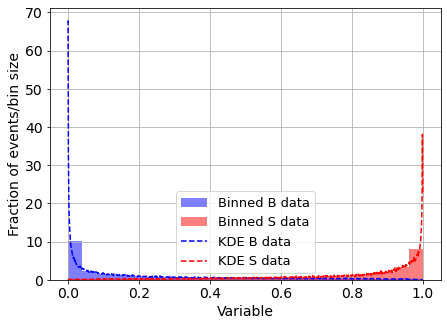

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0007122485584859914
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


Z BP1:5.060006724028662
Z_std BP1:1.1551778020620251
Z_1 BP1:5.050414921442424
Z_std_1 BP1:1.4731512903698034
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Z BP2:10.169938231220634
Z_std BP2:0.7514242231905619
Z_1 BP2:10.11358558239487
Z_std_1 BP2:0.8197333416044209
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Z BP3:15.914786393416549
Z_std BP3:1.835396550217512
Z_1 BP3:15.881466345121005
Z_std_1 BP3:1.7448760723572214
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


Z BP4:4.147965810581303
Z_std BP4:0.9414059580702515
Z_1 BP4:4.054688181000283
Z_std_1 BP4:0.9921560620539249
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


Z BP5:8.126825005749467
Z_std BP5:0.8220279401520351
Z_1 BP5:8.011967160844842
Z_std_1 BP5:0.7686737718249519
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


Z BP6:10.79607211125652
Z_std BP6:1.0948935839459641
Z_1 BP6:10.674952844787418
Z_std_1 BP6:1.023866048424505
3 done
4 done


 30%|██████████▊                         | 3/10 [00:05<00:10,  1.51s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.31682815154358784
<p_{s}(Sdata)> = 5.401985689955473
<p_{b}(Bdata)> = 14.090693978668419
<p_{s}(Bdata)> = 0.29928049327930806


 90%|████████████████████████████████▍   | 9/10 [00:13<00:01,  1.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.6743177968953284
<p_{s}(Sdata)> = 6.170586778321616
<p_{b}(Bdata)> = 14.12547847329982
<p_{s}(Bdata)> = 0.3004474496217568


100%|███████████████████████████████████| 10/10 [00:15<00:00,  1.55s/it]


Z BP7:2.3950820474738115
Z_std BP7:1.1998796473267255
Z_1 BP7:2.388674482081185
Z_std_1 BP7:0.9576925141837469
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.12s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2677120856939129
<p_{s}(Sdata)> = 5.76572462511462
<p_{b}(Bdata)> = 14.036868895563241
<p_{s}(Bdata)> = 0.302217208354457
Z BP8:5.523821904637156
Z_std BP8:1.2108140580548648
Z_1 BP8:5.3563971513394275
Z_std_1 BP8:0.948551882250213


3 done
4 done


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]


Z BP9:6.914839402892156
Z_std BP9:1.160764448854508
Z_1 BP9:6.789514079832308
Z_std_1 BP9:0.994626256743763
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.276813340604973
<p_{s}(Sdata)> = 8.602942691744921
<p_{b}(Bdata)> = 14.047958407560674
<p_{s}(Bdata)> = 0.3003375905640774


 20%|███████▏                            | 2/10 [00:00<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27550431984096263
<p_{s}(Sdata)> = 7.369409810184874
<p_{b}(Bdata)> = 13.869450294965821
<p_{s}(Bdata)> = 0.301863227782326


 30%|██████████▊                         | 3/10 [00:02<00:07,  1.07s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.39657381489193677
<p_{s}(Sdata)> = 7.525949862163136
<p_{b}(Bdata)> = 14.09063883954818
<p_{s}(Bdata)> = 0.3020147440373312


 40%|██████████████▍                     | 4/10 [00:03<00:05,  1.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3911738763294889
<p_{s}(Sdata)> = 7.461015308026025
<p_{b}(Bdata)> = 14.036035426035108
<p_{s}(Bdata)> = 0.2991259741832993


 50%|██████████████████                  | 5/10 [00:04<00:04,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3245325169542844
<p_{s}(Sdata)> = 5.142174552254321
<p_{b}(Bdata)> = 14.055061875442435
<p_{s}(Bdata)> = 0.30068341537255194


 60%|█████████████████████▌              | 6/10 [00:05<00:03,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3809085179770196
<p_{s}(Sdata)> = 5.120443161567109
<p_{b}(Bdata)> = 14.103667383499003
<p_{s}(Bdata)> = 0.3026694684711116


 70%|█████████████████████████▏          | 7/10 [00:06<00:02,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29416160351952647
<p_{s}(Sdata)> = 6.056614139556053
<p_{b}(Bdata)> = 14.090099574171068
<p_{s}(Bdata)> = 0.29940878744362476


 90%|████████████████████████████████▍   | 9/10 [00:09<00:01,  1.29s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25401880885697636
<p_{s}(Sdata)> = 7.12109832747292
<p_{b}(Bdata)> = 13.952899062791202
<p_{s}(Bdata)> = 0.30087730841192234


100%|███████████████████████████████████| 10/10 [00:10<00:00,  1.00s/it]


Z BP10:3.3614966992035877
Z_std BP10:0.8746476201051494
Z_1 BP10:2.715487629068413
Z_std_1 BP10:0.6596446137510766
3 done
4 done


 30%|██████████▊                         | 3/10 [00:11<00:27,  3.93s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25834643772999794
<p_{s}(Sdata)> = 7.14877964979547
<p_{b}(Bdata)> = 13.993597808891842
<p_{s}(Bdata)> = 0.30155069605826534


100%|███████████████████████████████████| 10/10 [00:35<00:00,  3.51s/it]


Z BP11:3.2996309444957865
Z_std BP11:0.7562211487788718
Z_1 BP11:3.164002504585246
Z_std_1 BP11:0.5438160735086143
3 done
4 done


 10%|███▌                                | 1/10 [00:04<00:36,  4.02s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.33238395764113454
<p_{s}(Sdata)> = 7.916918232788958
<p_{b}(Bdata)> = 14.115903398261867
<p_{s}(Bdata)> = 0.30069073998837365


 50%|██████████████████                  | 5/10 [00:15<00:16,  3.36s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19960912243385018
<p_{s}(Sdata)> = 6.66980153721086
<p_{b}(Bdata)> = 14.066675497457473
<p_{s}(Bdata)> = 0.300228559492681


100%|███████████████████████████████████| 10/10 [00:32<00:00,  3.23s/it]


Z BP12:4.890057600783427
Z_std BP12:1.393974354918349
Z_1 BP12:4.6642886257292
Z_std_1 BP12:0.997792892111543
3 done
4 done


 10%|███▌                                | 1/10 [00:04<00:39,  4.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20791620101389588
<p_{s}(Sdata)> = 6.766107732869183
<p_{b}(Bdata)> = 14.033757858334816
<p_{s}(Bdata)> = 0.29995518698956214


 20%|███████▏                            | 2/10 [00:05<00:18,  2.31s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24281381026095747
<p_{s}(Sdata)> = 7.9785430684037415
<p_{b}(Bdata)> = 14.219643824960764
<p_{s}(Bdata)> = 0.29760867101453187


 30%|██████████▊                         | 3/10 [00:06<00:11,  1.66s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24815265001854275
<p_{s}(Sdata)> = 7.813444716101806
<p_{b}(Bdata)> = 14.017365544643837
<p_{s}(Bdata)> = 0.30045956959423803


 40%|██████████████▍                     | 4/10 [00:07<00:08,  1.36s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22916077821390032
<p_{s}(Sdata)> = 11.164964808519617
<p_{b}(Bdata)> = 13.965060724631785
<p_{s}(Bdata)> = 0.30005879339013597


 50%|██████████████████                  | 5/10 [00:07<00:05,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.5361854639018596
<p_{s}(Sdata)> = 4.146401203899165
<p_{b}(Bdata)> = 14.033511353100941
<p_{s}(Bdata)> = 0.3006060974273825


 60%|█████████████████████▌              | 6/10 [00:08<00:04,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.48339450640386994
<p_{s}(Sdata)> = 5.824189662337913
<p_{b}(Bdata)> = 14.135063237073114
<p_{s}(Bdata)> = 0.29917392511987084


 70%|█████████████████████████▏          | 7/10 [00:09<00:03,  1.04s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.28035581480161487
<p_{s}(Sdata)> = 7.478683350584715
<p_{b}(Bdata)> = 14.070041175459185
<p_{s}(Bdata)> = 0.297881315074742


 80%|████████████████████████████▊       | 8/10 [00:10<00:01,  1.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4858371520058038
<p_{s}(Sdata)> = 5.663024763260571
<p_{b}(Bdata)> = 14.045192800921637
<p_{s}(Bdata)> = 0.29819908815247026


100%|███████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


Z BP13:2.2894438366211354
Z_std BP13:0.3989986368903808
Z_1 BP13:1.8188481360897577
Z_std_1 BP13:0.27306898392919016
3 done
4 done


  0%|                                            | 0/10 [00:00<?, ?it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25597315021683487
<p_{s}(Sdata)> = 6.5672740962942715
<p_{b}(Bdata)> = 14.077754930072071
<p_{s}(Bdata)> = 0.2991641633226528


 10%|███▌                                | 1/10 [00:00<00:08,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24849411595107962
<p_{s}(Sdata)> = 6.194455332021884
<p_{b}(Bdata)> = 14.095881651780957
<p_{s}(Bdata)> = 0.29878975708420835


 20%|███████▏                            | 2/10 [00:01<00:07,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3788903949915169
<p_{s}(Sdata)> = 6.033588215848428
<p_{b}(Bdata)> = 13.992314394947028
<p_{s}(Bdata)> = 0.2984407943378523


 40%|██████████████▍                     | 4/10 [00:07<00:13,  2.26s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.265041601548766
<p_{s}(Sdata)> = 6.990762939013079
<p_{b}(Bdata)> = 14.09135727375303
<p_{s}(Bdata)> = 0.29997014424962487


 50%|██████████████████                  | 5/10 [00:07<00:08,  1.77s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23836590584332623
<p_{s}(Sdata)> = 6.144539904036397
<p_{b}(Bdata)> = 14.083058713938051
<p_{s}(Bdata)> = 0.29840528525853904


 60%|█████████████████████▌              | 6/10 [00:08<00:05,  1.47s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24838352568882358
<p_{s}(Sdata)> = 9.208046160096503
<p_{b}(Bdata)> = 14.069904549878098
<p_{s}(Bdata)> = 0.30156981791281995


 80%|████████████████████████████▊       | 8/10 [00:13<00:04,  2.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.242855183821677
<p_{s}(Sdata)> = 8.497186064680577
<p_{b}(Bdata)> = 14.085753521523593
<p_{s}(Bdata)> = 0.2980272607635951


100%|███████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Z BP14:3.2157949358685562
Z_std BP14:0.7769882164970474
Z_1 BP14:2.7030328312452894
Z_std_1 BP14:0.5333692720306691
3 done
4 done


 30%|██████████▊                         | 3/10 [00:12<00:28,  4.01s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2348906259857807
<p_{s}(Sdata)> = 5.623304480172244
<p_{b}(Bdata)> = 14.02427407248658
<p_{s}(Bdata)> = 0.29958045496936486


 50%|██████████████████                  | 5/10 [00:17<00:15,  3.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25399261480329727
<p_{s}(Sdata)> = 7.192812922544073
<p_{b}(Bdata)> = 14.052557155633998
<p_{s}(Bdata)> = 0.29986028347933336


 60%|█████████████████████▌              | 6/10 [00:17<00:09,  2.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19357950145761524
<p_{s}(Sdata)> = 6.010487683985576
<p_{b}(Bdata)> = 14.10034912535086
<p_{s}(Bdata)> = 0.30087171335628654


 90%|████████████████████████████████▍   | 9/10 [00:28<00:03,  3.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2346605639718035
<p_{s}(Sdata)> = 7.7032737572324015
<p_{b}(Bdata)> = 13.949841276017263
<p_{s}(Bdata)> = 0.3017043259062509


100%|███████████████████████████████████| 10/10 [00:29<00:00,  2.90s/it]


Z BP15:3.4965346523475453
Z_std BP15:0.7172595879568707
Z_1 BP15:3.1756262853246446
Z_std_1 BP15:0.4683055875407576
4
AUC:0.9377579304651729


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 10189.97508604  9848.74621369
  9426.5477952   8918.0057498   8314.25135671  7592.15696372
  6748.8072242   5766.61476927  4627.39204206  3295.93231193
  1726.96646478  -132.36051264 -2324.79583999 -5162.04120608]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7634.19722847  7566.317022    7438.64813895


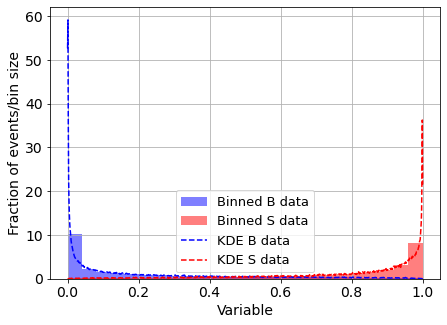

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


Z BP1:4.028207397489465
Z_std BP1:1.5597053642889176
Z_1 BP1:3.283419509080472
Z_std_1 BP1:2.85918497502651
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:13<00:00,  1.34s/it]


Z BP2:8.614763630720038
Z_std BP2:1.999843913392728
Z_1 BP2:7.74230657091391
Z_std_1 BP2:2.7096655534700416
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


Z BP3:15.381014987258936
Z_std BP3:1.4013255282557433
Z_1 BP3:15.363349058043784
Z_std_1 BP3:1.4274733659096388
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:15<00:00,  1.57s/it]


Z BP4:3.759948812365527
Z_std BP4:1.2393046518651205
Z_1 BP4:3.6509365716459623
Z_std_1 BP4:1.2987064213757964
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:14<00:00,  1.50s/it]


Z BP5:6.244838901864637
Z_std BP5:1.0612457289954653
Z_1 BP5:6.115961253742427
Z_std_1 BP5:1.2659094629137595
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:15<00:00,  1.53s/it]


Z BP6:8.708695669025724
Z_std BP6:0.6875113984361301
Z_1 BP6:8.495550346196872
Z_std_1 BP6:0.8036826889992679
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


Z BP7:3.4881363907483407
Z_std BP7:1.054332229761203
Z_1 BP7:3.446626464277228
Z_std_1 BP7:1.0742021984645576
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]


Z BP8:4.884937309398903
Z_std BP8:1.5524308278472054
Z_1 BP8:4.880075242658162
Z_std_1 BP8:1.5965348869082838
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Z BP9:6.508400188361455
Z_std BP9:1.7233628399120844
Z_1 BP9:6.443149680097676
Z_std_1 BP9:1.8573802199787104
3 done
4 done


 30%|██████████▊                         | 3/10 [00:04<00:08,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3767160874313174
<p_{s}(Sdata)> = 6.3018491215475345
<p_{b}(Bdata)> = 11.92423156466852
<p_{s}(Bdata)> = 0.3024906049753043


 60%|█████████████████████▌              | 6/10 [00:07<00:04,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3790989109535095
<p_{s}(Sdata)> = 2.547743713892771
<p_{b}(Bdata)> = 11.846333595078384
<p_{s}(Bdata)> = 0.29954351212765346


100%|███████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


Z BP10:2.2301609234599784
Z_std BP10:1.1240300626326447
Z_1 BP10:2.1862232250487126
Z_std_1 BP10:1.2488916156476422
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


Z BP11:3.36920766700851
Z_std BP11:1.1436798916299897
Z_1 BP11:3.368442834897421
Z_std_1 BP11:0.9973067894740425
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


Z BP12:4.109879636838937
Z_std BP12:1.321818891141221
Z_1 BP12:4.108288627544742
Z_std_1 BP12:1.333335974467735
3 done
4 done


 40%|██████████████▍                     | 4/10 [00:06<00:08,  1.40s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3193309648620505
<p_{s}(Sdata)> = 4.911938732667111
<p_{b}(Bdata)> = 11.921065536710927
<p_{s}(Bdata)> = 0.30327410250192177


 80%|████████████████████████████▊       | 8/10 [00:11<00:02,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.20370789908038714
<p_{s}(Sdata)> = 5.265423994710164
<p_{b}(Bdata)> = 11.787231524429469
<p_{s}(Bdata)> = 0.30145854505126196


100%|███████████████████████████████████| 10/10 [00:14<00:00,  1.44s/it]


Z BP13:1.1767548635673644
Z_std BP13:0.7283478197833446
Z_1 BP13:1.1717066072000284
Z_std_1 BP13:0.8013560147028963
3 done
4 done


 20%|███████▏                            | 2/10 [00:02<00:09,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.25031977339734013
<p_{s}(Sdata)> = 3.8941930202024437
<p_{b}(Bdata)> = 11.91498761588415
<p_{s}(Bdata)> = 0.2983556776733781


 30%|██████████▊                         | 3/10 [00:02<00:05,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2829845744977919
<p_{s}(Sdata)> = 3.9305161949602216
<p_{b}(Bdata)> = 11.884451513886761
<p_{s}(Bdata)> = 0.29984061279719376


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Z BP14:2.4091998719045766
Z_std BP14:0.8396251374072163
Z_1 BP14:2.360109912094558
Z_std_1 BP14:1.0766408842362514
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:22<00:00,  2.29s/it]


Z BP15:3.6636142266027623
Z_std BP15:0.677969562397731
Z_1 BP15:3.5935198066054537
Z_std_1 BP15:0.5645995293744754
5
AUC:0.9377707325989748


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 10219.06728505  9899.45757689
  9490.53022668  8988.14231411  8385.07092566  7668.91376134
  6828.96672095  5850.80178188  4710.20581106  3367.13859559
  1768.31388968  -108.05632881 -2312.40797388 -5158.55925811]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  7720.92731056  7592.48473654


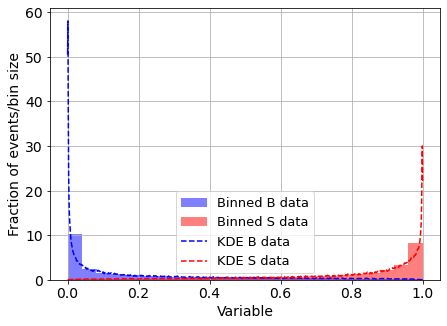

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


Z BP1:6.002384841068397
Z_std BP1:0.6058756203559061
Z_1 BP1:5.993717847583938
Z_std_1 BP1:0.6198484939908715
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:15<00:00,  1.58s/it]


Z BP2:10.283061081231082
Z_std BP2:1.6235618252583326
Z_1 BP2:10.140906119583171
Z_std_1 BP2:1.754578240569658
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Z BP3:17.022523928964603
Z_std BP3:1.3921909480049082
Z_1 BP3:16.987821489562986
Z_std_1 BP3:1.3355744530585623
3 done
4 done


 80%|████████████████████████████▊       | 8/10 [00:14<00:02,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.41236878115143766
<p_{s}(Sdata)> = 4.497650326787792
<p_{b}(Bdata)> = 11.629437439435735
<p_{s}(Bdata)> = 0.3035484551695558


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


Z BP4:4.331217639633698
Z_std BP4:1.496705770571389
Z_1 BP4:4.318632627330647
Z_std_1 BP4:1.1340846699442286
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:19<00:00,  1.93s/it]


Z BP5:7.856125408078339
Z_std BP5:0.9336312914252894
Z_1 BP5:7.82966408455269
Z_std_1 BP5:0.9091028077121805
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:20<00:00,  2.07s/it]


Z BP6:11.719012116538734
Z_std BP6:0.8960818698744277
Z_1 BP6:11.642165549152393
Z_std_1 BP6:0.8288027866725279
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.39631641763048436
<p_{s}(Sdata)> = 4.8748275712674864
<p_{b}(Bdata)> = 11.639715208383826
<p_{s}(Bdata)> = 0.30246524408350617


 20%|███████▏                            | 2/10 [00:00<00:03,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3403237024872533
<p_{s}(Sdata)> = 4.6417322750336725
<p_{b}(Bdata)> = 11.596048527654856
<p_{s}(Bdata)> = 0.30333222117931874


 30%|██████████▊                         | 3/10 [00:01<00:03,  1.98it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5329932077171701
<p_{s}(Sdata)> = 5.050150434982246
<p_{b}(Bdata)> = 11.614310008338435
<p_{s}(Bdata)> = 0.3027507503879169


 60%|█████████████████████▌              | 6/10 [00:07<00:05,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3129858480335738
<p_{s}(Sdata)> = 8.19746763012484
<p_{b}(Bdata)> = 11.584700175917366
<p_{s}(Bdata)> = 0.3015326355938355


 80%|████████████████████████████▊       | 8/10 [00:10<00:02,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3567056899130751
<p_{s}(Sdata)> = 5.403523097899572
<p_{b}(Bdata)> = 11.652752803988939
<p_{s}(Bdata)> = 0.30125913111835656


100%|███████████████████████████████████| 10/10 [00:13<00:00,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.34050279509835674
<p_{s}(Sdata)> = 6.2453967732251465
<p_{b}(Bdata)> = 11.646863906022151
<p_{s}(Bdata)> = 0.3001869774194902
Z BP7:4.564010608944141
Z_std BP7:1.0373378787200191
Z_1 BP7:4.135345232204272
Z_std_1 BP7:0.7712131842561395


3 done
4 done


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.18s/it]


Z BP8:5.230969112621085
Z_std BP8:1.2689552654885374
Z_1 BP8:5.2011732486449
Z_std_1 BP8:1.0747080474745887
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.13s/it]


Z BP9:7.77781725613616
Z_std BP9:0.9622317431695853
Z_1 BP9:7.601991724419948
Z_std_1 BP9:0.8889016068731093
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24502719500514977
<p_{s}(Sdata)> = 7.498058190671865
<p_{b}(Bdata)> = 11.693978246939855
<p_{s}(Bdata)> = 0.30011574617344017


 20%|███████▏                            | 2/10 [00:00<00:03,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21346985337433133
<p_{s}(Sdata)> = 6.431845235002045
<p_{b}(Bdata)> = 11.612496697066035
<p_{s}(Bdata)> = 0.30396061608337505


 40%|██████████████▍                     | 4/10 [00:04<00:07,  1.18s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3930227032860869
<p_{s}(Sdata)> = 4.970942548831672
<p_{b}(Bdata)> = 11.648923315448311
<p_{s}(Bdata)> = 0.2989362767918857


 60%|█████████████████████▌              | 6/10 [00:07<00:04,  1.22s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24234934224229424
<p_{s}(Sdata)> = 5.645979768757284
<p_{b}(Bdata)> = 11.731112919672967
<p_{s}(Bdata)> = 0.3004429746477445


100%|███████████████████████████████████| 10/10 [00:14<00:00,  1.46s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.5260547312957282
<p_{s}(Sdata)> = 4.6460925141488785
<p_{b}(Bdata)> = 11.62341569331924
<p_{s}(Bdata)> = 0.3004275260264009
Z BP10:2.7991123445851276
Z_std BP10:0.9428393776322034
Z_1 BP10:2.4616280302248694
Z_std_1 BP10:0.7229118837276137


3 done
4 done


 20%|███████▏                            | 2/10 [00:03<00:11,  1.44s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24526398432841726
<p_{s}(Sdata)> = 6.216576979564689
<p_{b}(Bdata)> = 11.486736793142361
<p_{s}(Bdata)> = 0.30266113096188935


 50%|██████████████████                  | 5/10 [00:08<00:07,  1.56s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2567486474400254
<p_{s}(Sdata)> = 4.635880822239398
<p_{b}(Bdata)> = 11.64598222133095
<p_{s}(Bdata)> = 0.30210779664601667


 80%|████████████████████████████▊       | 8/10 [00:14<00:03,  1.64s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22729671458348547
<p_{s}(Sdata)> = 6.337157455059646
<p_{b}(Bdata)> = 11.589164853094717
<p_{s}(Bdata)> = 0.3033139860015227


 90%|████████████████████████████████▍   | 9/10 [00:15<00:01,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2511527361528284
<p_{s}(Sdata)> = 5.528285488517075
<p_{b}(Bdata)> = 11.654431724919151
<p_{s}(Bdata)> = 0.3013917681184793


100%|███████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


Z BP11:4.817884819913977
Z_std BP11:0.9031611939603216
Z_1 BP11:4.434216845092873
Z_std_1 BP11:0.6414654601370926
3 done
4 done


 20%|███████▏                            | 2/10 [00:03<00:10,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22569156205999874
<p_{s}(Sdata)> = 6.457976592622437
<p_{b}(Bdata)> = 11.640780405970416
<p_{s}(Bdata)> = 0.3032638199854134


 30%|██████████▊                         | 3/10 [00:03<00:06,  1.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22319292948766148
<p_{s}(Sdata)> = 5.438514721929793
<p_{b}(Bdata)> = 11.672727158844172
<p_{s}(Bdata)> = 0.3028115007757594


 60%|█████████████████████▌              | 6/10 [00:09<00:05,  1.47s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20837434085991693
<p_{s}(Sdata)> = 5.798470661816167
<p_{b}(Bdata)> = 11.594661595498625
<p_{s}(Bdata)> = 0.3046980502926091


 70%|█████████████████████████▏          | 7/10 [00:09<00:03,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24591839911499336
<p_{s}(Sdata)> = 5.279057023212589
<p_{b}(Bdata)> = 11.608575031364465
<p_{s}(Bdata)> = 0.3030417146934767


 80%|████████████████████████████▊       | 8/10 [00:10<00:01,  1.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21204300786144364
<p_{s}(Sdata)> = 6.433636531779599
<p_{b}(Bdata)> = 11.568214530222072
<p_{s}(Bdata)> = 0.303023112550317


100%|███████████████████████████████████| 10/10 [00:13<00:00,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17898537227107608
<p_{s}(Sdata)> = 7.109924761711483
<p_{b}(Bdata)> = 11.553935386455333
<p_{s}(Bdata)> = 0.30379548637662296
Z BP12:6.394123025482038
Z_std BP12:0.7910206074980474
Z_1 BP12:5.808852930288507
Z_std_1 BP12:0.6002902542144942


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.39950080668831434
<p_{s}(Sdata)> = 4.547450508750369
<p_{b}(Bdata)> = 11.571096730944108
<p_{s}(Bdata)> = 0.30306314132838763


 20%|███████▏                            | 2/10 [00:00<00:03,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2599139977032643
<p_{s}(Sdata)> = 5.6214250356386355
<p_{b}(Bdata)> = 11.548083756746992
<p_{s}(Bdata)> = 0.30088116954021144


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37911035070756344
<p_{s}(Sdata)> = 7.297670026949319
<p_{b}(Bdata)> = 11.551851782756293
<p_{s}(Bdata)> = 0.3063304449558127


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3785619193798209
<p_{s}(Sdata)> = 4.945101060509989
<p_{b}(Bdata)> = 11.627203093025097
<p_{s}(Bdata)> = 0.3039541536101718


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20539942307755701
<p_{s}(Sdata)> = 7.993483387160353
<p_{b}(Bdata)> = 11.555114093688813
<p_{s}(Bdata)> = 0.30009375000134836


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2658446479795912
<p_{s}(Sdata)> = 8.646888643553359
<p_{b}(Bdata)> = 11.652186008927295
<p_{s}(Bdata)> = 0.3016235341087243


 90%|████████████████████████████████▍   | 9/10 [00:08<00:01,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3604302612357841
<p_{s}(Sdata)> = 3.353516294885766
<p_{b}(Bdata)> = 11.687810362922747
<p_{s}(Bdata)> = 0.29916234558092436


100%|███████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.331726178936728
<p_{s}(Sdata)> = 4.697646792745922
<p_{b}(Bdata)> = 11.581074156040463
<p_{s}(Bdata)> = 0.30342116165202265
Z BP13:2.5587925927894277
Z_std BP13:1.188087083082242
Z_1 BP13:2.051890370033318
Z_std_1 BP13:0.8714578998202736


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  1.98it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.38844398842953576
<p_{s}(Sdata)> = 6.215340722061046
<p_{b}(Bdata)> = 11.641258804660806
<p_{s}(Bdata)> = 0.3004175044410493


 20%|███████▏                            | 2/10 [00:01<00:04,  1.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2169952977721672
<p_{s}(Sdata)> = 5.904300672115561
<p_{b}(Bdata)> = 11.650452686562003
<p_{s}(Bdata)> = 0.3006859494587848


 30%|██████████▊                         | 3/10 [00:01<00:03,  1.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23288709592908624
<p_{s}(Sdata)> = 6.760037125043129
<p_{b}(Bdata)> = 11.743809064385655
<p_{s}(Bdata)> = 0.2993222165212668


 40%|██████████████▍                     | 4/10 [00:02<00:02,  2.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19345551888908294
<p_{s}(Sdata)> = 6.633819748819447
<p_{b}(Bdata)> = 11.63985754681937
<p_{s}(Bdata)> = 0.30008615737173516


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2464865931446274
<p_{s}(Sdata)> = 8.80294714818279
<p_{b}(Bdata)> = 11.572102357876876
<p_{s}(Bdata)> = 0.3001670477951287


 60%|█████████████████████▌              | 6/10 [00:03<00:01,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23015090425097243
<p_{s}(Sdata)> = 5.411955795622353
<p_{b}(Bdata)> = 11.6450328231662
<p_{s}(Bdata)> = 0.3041248461181437


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22654396506966717
<p_{s}(Sdata)> = 8.915616351989
<p_{b}(Bdata)> = 11.638139361300494
<p_{s}(Bdata)> = 0.3004255980915753


 90%|████████████████████████████████▍   | 9/10 [00:06<00:00,  1.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2914229657774189
<p_{s}(Sdata)> = 5.61344389202446
<p_{b}(Bdata)> = 11.714992312162341
<p_{s}(Bdata)> = 0.30125265208460916


100%|███████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]


Z BP14:4.133374018424518
Z_std BP14:0.6588580543158005
Z_1 BP14:3.48667306580584
Z_std_1 BP14:0.49416222074457683
3 done
4 done


 30%|██████████▊                         | 3/10 [00:05<00:10,  1.55s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2520766775308055
<p_{s}(Sdata)> = 7.52263637719903
<p_{b}(Bdata)> = 11.662620908213592
<p_{s}(Bdata)> = 0.3026895334648208


 40%|██████████████▍                     | 4/10 [00:06<00:06,  1.14s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23786354295161943
<p_{s}(Sdata)> = 4.500416769106972
<p_{b}(Bdata)> = 11.60181103757683
<p_{s}(Bdata)> = 0.30179356605677515


 50%|██████████████████                  | 5/10 [00:06<00:04,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22075535672836374
<p_{s}(Sdata)> = 6.502411693157545
<p_{b}(Bdata)> = 11.613841068657234
<p_{s}(Bdata)> = 0.30101910664244796


 70%|█████████████████████████▏          | 7/10 [00:09<00:03,  1.21s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17788809321599125
<p_{s}(Sdata)> = 6.386312835892895
<p_{b}(Bdata)> = 11.528366071173778
<p_{s}(Bdata)> = 0.3028167468793003


 90%|████████████████████████████████▍   | 9/10 [00:12<00:01,  1.28s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2090672677224567
<p_{s}(Sdata)> = 7.052476050632783
<p_{b}(Bdata)> = 11.703152569868529
<p_{s}(Bdata)> = 0.3022616534774273


100%|███████████████████████████████████| 10/10 [00:13<00:00,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2106410274794864
<p_{s}(Sdata)> = 6.0874294444900805
<p_{b}(Bdata)> = 11.63984627969634
<p_{s}(Bdata)> = 0.3023469171003271
Z BP15:4.261145027851626
Z_std BP15:1.0973689688772406
Z_1 BP15:3.8361552606024865
Z_std_1 BP15:0.7633866053506777
6


AUC:0.9368684697444182


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  9766.09890242
  9370.62865583  8882.3564073   8287.00176598  7572.43409572
  6731.49769684  5759.78681547  4631.11079929  3311.15141479
  1744.62020563  -111.34712365 -2302.29553637 -5152.38198685]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  7624.97960727  7493.70781476


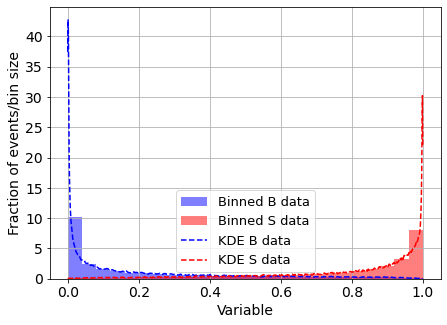

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


Z BP1:6.602855949098047
Z_std BP1:1.8230709042421545
Z_1 BP1:6.563811305928159
Z_std_1 BP1:1.601054770962898
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.82s/it]


Z BP2:12.377573001527496
Z_std BP2:0.8056738436015247
Z_1 BP2:12.376115867966615
Z_std_1 BP2:0.8024804889183063
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]


Z BP3:19.04142454917575
Z_std BP3:0.8934128846199986
Z_1 BP3:18.82511884407832
Z_std_1 BP3:0.8347615467874656
3 done
4 done


 40%|██████████████▍                     | 4/10 [00:08<00:10,  1.73s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3688655254267331
<p_{s}(Sdata)> = 5.545730376005275
<p_{b}(Bdata)> = 9.796989650011394
<p_{s}(Bdata)> = 0.3101819134145546


 60%|█████████████████████▌              | 6/10 [00:11<00:05,  1.45s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3248942757112149
<p_{s}(Sdata)> = 5.670801384791761
<p_{b}(Bdata)> = 9.822721834173409
<p_{s}(Bdata)> = 0.31100790443137805


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]


Z BP4:5.088981309074114
Z_std BP4:1.577546932112278
Z_1 BP4:4.942143256658579
Z_std_1 BP4:1.1795657707790606
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:20<00:00,  2.05s/it]


Z BP5:8.335018471027675
Z_std BP5:1.1371388680099943
Z_1 BP5:8.302033530153412
Z_std_1 BP5:0.9969653498991652
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.16s/it]


Z BP6:11.80164770832517
Z_std BP6:1.5067571173017704
Z_1 BP6:11.708782636548621
Z_std_1 BP6:1.3758422941256863
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.35532650357057977
<p_{s}(Sdata)> = 5.197096190116753
<p_{b}(Bdata)> = 9.760520470535203
<p_{s}(Bdata)> = 0.30964587205641536


 30%|██████████▊                         | 3/10 [00:03<00:08,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3415666672824754
<p_{s}(Sdata)> = 3.9425983078631175
<p_{b}(Bdata)> = 9.79055670259953
<p_{s}(Bdata)> = 0.31215924265234213


 40%|██████████████▍                     | 4/10 [00:04<00:05,  1.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.582076631589809
<p_{s}(Sdata)> = 5.74534945626077
<p_{b}(Bdata)> = 9.786767797869675
<p_{s}(Bdata)> = 0.3085508339995933


 60%|█████████████████████▌              | 6/10 [00:07<00:04,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4212147511994774
<p_{s}(Sdata)> = 5.245059301341046
<p_{b}(Bdata)> = 9.849729706468713
<p_{s}(Bdata)> = 0.30998870249630206


100%|███████████████████████████████████| 10/10 [00:14<00:00,  1.44s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3596701106832432
<p_{s}(Sdata)> = 4.807585666296154
<p_{b}(Bdata)> = 9.802455250270592
<p_{s}(Bdata)> = 0.30949609851538745
Z BP7:4.389100299865412
Z_std BP7:1.0068621952288939
Z_1 BP7:3.929297186304555
Z_std_1 BP7:0.754704348334131


3 done
4 done


100%|███████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]


Z BP8:6.874631454727897
Z_std BP8:0.9079239661788838
Z_1 BP8:6.481881028860457
Z_std_1 BP8:0.8026434966079792
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:23<00:00,  2.39s/it]


Z BP9:7.819778564534889
Z_std BP9:0.5323041643615266
Z_1 BP9:7.570094762814468
Z_std_1 BP9:0.4181617696841215
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3479054548782689
<p_{s}(Sdata)> = 4.722001227317774
<p_{b}(Bdata)> = 9.778882641689686
<p_{s}(Bdata)> = 0.3113234883865124


 20%|███████▏                            | 2/10 [00:00<00:03,  2.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3149925972278197
<p_{s}(Sdata)> = 6.855260639634939
<p_{b}(Bdata)> = 9.857686072084382
<p_{s}(Bdata)> = 0.30891287552016977


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.7203167090291752
<p_{s}(Sdata)> = 6.822965498991294
<p_{b}(Bdata)> = 9.810203651715657
<p_{s}(Bdata)> = 0.309789012295521


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3787214648011606
<p_{s}(Sdata)> = 6.068017519098273
<p_{b}(Bdata)> = 9.847025660300076
<p_{s}(Bdata)> = 0.30908171652381683


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.40284584588547867
<p_{s}(Sdata)> = 4.07531936021373
<p_{b}(Bdata)> = 9.856157452371905
<p_{s}(Bdata)> = 0.30670363567343967


 70%|█████████████████████████▏          | 7/10 [00:05<00:03,  1.04s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3613603530527959
<p_{s}(Sdata)> = 4.394821215668373
<p_{b}(Bdata)> = 9.85819423492272
<p_{s}(Bdata)> = 0.30853440791319253


 80%|████████████████████████████▊       | 8/10 [00:06<00:01,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3023967842496916
<p_{s}(Sdata)> = 4.813157721565002
<p_{b}(Bdata)> = 9.81455557717785
<p_{s}(Bdata)> = 0.30853416856059945


 90%|████████████████████████████████▍   | 9/10 [00:06<00:00,  1.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3345122757339763
<p_{s}(Sdata)> = 3.4055320436562746
<p_{b}(Bdata)> = 9.788479656802135
<p_{s}(Bdata)> = 0.31069459140728223


100%|███████████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28142615439799734
<p_{s}(Sdata)> = 8.604622392607219
<p_{b}(Bdata)> = 9.883200394691467
<p_{s}(Bdata)> = 0.30888545780348586
Z BP10:3.8477376590873806
Z_std BP10:0.6576475647982377
Z_1 BP10:3.1760842582623217
Z_std_1 BP10:0.46806971691262866


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28861933671201506
<p_{s}(Sdata)> = 6.422138684996624
<p_{b}(Bdata)> = 9.674144649539643
<p_{s}(Bdata)> = 0.3094728549315563


 20%|███████▏                            | 2/10 [00:00<00:03,  2.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2948847908948107
<p_{s}(Sdata)> = 5.94340403516236
<p_{b}(Bdata)> = 9.74053870710134
<p_{s}(Bdata)> = 0.30804686724887126


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22515951956613448
<p_{s}(Sdata)> = 6.877695758546902
<p_{b}(Bdata)> = 9.799522670044272
<p_{s}(Bdata)> = 0.30935862857301627


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.253453987113135
<p_{s}(Sdata)> = 5.796230799255291
<p_{b}(Bdata)> = 9.802124481754682
<p_{s}(Bdata)> = 0.3081351194254274


 70%|█████████████████████████▏          | 7/10 [00:07<00:03,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2943033163734661
<p_{s}(Sdata)> = 5.585200319174355
<p_{b}(Bdata)> = 9.866622273271435
<p_{s}(Bdata)> = 0.3088113063485406


 80%|████████████████████████████▊       | 8/10 [00:08<00:02,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.27842197047860695
<p_{s}(Sdata)> = 4.888708329972813
<p_{b}(Bdata)> = 9.748844483342387
<p_{s}(Bdata)> = 0.3094421971234184


 90%|████████████████████████████████▍   | 9/10 [00:08<00:00,  1.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27279484975315377
<p_{s}(Sdata)> = 5.460443113755219
<p_{b}(Bdata)> = 9.826717489281085
<p_{s}(Bdata)> = 0.31088221733413046


100%|███████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


Z BP11:5.277915685906989
Z_std BP11:0.803058958310628
Z_1 BP11:4.758228283217677
Z_std_1 BP11:0.5675517160081106
3 done
4 done


 20%|███████▏                            | 2/10 [00:03<00:11,  1.43s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21426907019214664
<p_{s}(Sdata)> = 5.770154564527448
<p_{b}(Bdata)> = 9.84053762628504
<p_{s}(Bdata)> = 0.3107705596177847


 30%|██████████▊                         | 3/10 [00:03<00:07,  1.01s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.21828670420993784
<p_{s}(Sdata)> = 6.019648198685378
<p_{b}(Bdata)> = 9.768761771522696
<p_{s}(Bdata)> = 0.3090573367979694


 90%|████████████████████████████████▍   | 9/10 [00:16<00:01,  1.65s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20746137904938716
<p_{s}(Sdata)> = 6.5123042130201725
<p_{b}(Bdata)> = 9.79773473667913
<p_{s}(Bdata)> = 0.30953008868460663


100%|███████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20974025184750367
<p_{s}(Sdata)> = 6.763220773785459
<p_{b}(Bdata)> = 9.83475757952846
<p_{s}(Bdata)> = 0.31207231374295735
Z BP12:6.162190486976499
Z_std BP12:1.9792961886515268
Z_1 BP12:5.671379346987195
Z_std_1 BP12:1.4755056142434368


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29242920709220055
<p_{s}(Sdata)> = 5.23832978416885
<p_{b}(Bdata)> = 9.79586210827091
<p_{s}(Bdata)> = 0.3073967061378366


 20%|███████▏                            | 2/10 [00:00<00:03,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31146587441177453
<p_{s}(Sdata)> = 5.152609457622636
<p_{b}(Bdata)> = 9.88702114859446
<p_{s}(Bdata)> = 0.3071288756295556


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4498031004148601
<p_{s}(Sdata)> = 4.023977430253083
<p_{b}(Bdata)> = 9.764096395637466
<p_{s}(Bdata)> = 0.3087978457725316


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5025410006816181
<p_{s}(Sdata)> = 4.227703482950391
<p_{b}(Bdata)> = 9.816027452478465
<p_{s}(Bdata)> = 0.3083811140797318


 60%|█████████████████████▌              | 6/10 [00:05<00:04,  1.06s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22389530622590845
<p_{s}(Sdata)> = 4.679104808462061
<p_{b}(Bdata)> = 9.80333119285365
<p_{s}(Bdata)> = 0.3080241493598219


 70%|█████████████████████████▏          | 7/10 [00:05<00:02,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4912510962070642
<p_{s}(Sdata)> = 7.159718283881953
<p_{b}(Bdata)> = 9.739977208969917
<p_{s}(Bdata)> = 0.3095515173707958


 80%|████████████████████████████▊       | 8/10 [00:06<00:01,  1.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.40257641881388057
<p_{s}(Sdata)> = 4.270611510158834
<p_{b}(Bdata)> = 9.776301581050628
<p_{s}(Bdata)> = 0.31084373782009006


 90%|████████████████████████████████▍   | 9/10 [00:06<00:00,  1.50it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.8686729963161747
<p_{s}(Sdata)> = 4.593466711610305
<p_{b}(Bdata)> = 9.904637161113227
<p_{s}(Bdata)> = 0.30829212920670634


100%|███████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.258310463349618
<p_{s}(Sdata)> = 5.464042441196162
<p_{b}(Bdata)> = 9.834027925960653
<p_{s}(Bdata)> = 0.30742126587164625
Z BP13:2.325674809554863
Z_std BP13:0.6457164386255247
Z_1 BP13:1.8477306190645908
Z_std_1 BP13:0.4409195641054725


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2784902950460689
<p_{s}(Sdata)> = 5.72025370947109
<p_{b}(Bdata)> = 9.789749243831018
<p_{s}(Bdata)> = 0.3101787573810529


 20%|███████▏                            | 2/10 [00:00<00:03,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26156868524763915
<p_{s}(Sdata)> = 4.223576318037863
<p_{b}(Bdata)> = 9.841416003755405
<p_{s}(Bdata)> = 0.308559576246013


 40%|██████████████▍                     | 4/10 [00:03<00:05,  1.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3430001478715375
<p_{s}(Sdata)> = 4.279813298375067
<p_{b}(Bdata)> = 9.844658746098927
<p_{s}(Bdata)> = 0.3081133433090187


 60%|█████████████████████▌              | 6/10 [00:07<00:05,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.33650124621361305
<p_{s}(Sdata)> = 5.852714882070271
<p_{b}(Bdata)> = 9.834249128229375
<p_{s}(Bdata)> = 0.307754930882152


 70%|█████████████████████████▏          | 7/10 [00:07<00:03,  1.00s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22759074151988315
<p_{s}(Sdata)> = 6.221878202656655
<p_{b}(Bdata)> = 9.787406260258308
<p_{s}(Bdata)> = 0.31379767024006483


 80%|████████████████████████████▊       | 8/10 [00:07<00:01,  1.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23443073298559694
<p_{s}(Sdata)> = 5.563158917034739
<p_{b}(Bdata)> = 9.822019303090434
<p_{s}(Bdata)> = 0.30841149124281847


 90%|████████████████████████████████▍   | 9/10 [00:08<00:00,  1.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2869168367313719
<p_{s}(Sdata)> = 5.6636769823285125
<p_{b}(Bdata)> = 9.81211341591891
<p_{s}(Bdata)> = 0.3106115538756961


100%|███████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2486669538204944
<p_{s}(Sdata)> = 6.958640726587524
<p_{b}(Bdata)> = 9.816216944820827
<p_{s}(Bdata)> = 0.30511828027741605
Z BP14:3.657165780821523
Z_std BP14:1.1020596255586663
Z_1 BP14:3.131714861826772
Z_std_1 BP14:0.7273647140370091


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  1.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27357738805054377
<p_{s}(Sdata)> = 5.282744376344398
<p_{b}(Bdata)> = 9.799357128500766
<p_{s}(Bdata)> = 0.3130324391141975


 40%|██████████████▍                     | 4/10 [00:05<00:07,  1.30s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22222614823828066
<p_{s}(Sdata)> = 6.862791583256408
<p_{b}(Bdata)> = 9.79916328017404
<p_{s}(Bdata)> = 0.30661686201868055


 50%|██████████████████                  | 5/10 [00:05<00:05,  1.01s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22900109621039952
<p_{s}(Sdata)> = 4.624206840526245
<p_{b}(Bdata)> = 9.830009108062598
<p_{s}(Bdata)> = 0.3106219147224715


 80%|████████████████████████████▊       | 8/10 [00:11<00:02,  1.37s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.17442934802398632
<p_{s}(Sdata)> = 8.659918782930388
<p_{b}(Bdata)> = 9.829223606859378
<p_{s}(Bdata)> = 0.30737069709112513


 90%|████████████████████████████████▍   | 9/10 [00:11<00:01,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22045898356914934
<p_{s}(Sdata)> = 6.4083012463630356
<p_{b}(Bdata)> = 9.86817507600653
<p_{s}(Bdata)> = 0.30987321322219025


100%|███████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20538848430895348
<p_{s}(Sdata)> = 5.135152171881459
<p_{b}(Bdata)> = 9.820917657067763
<p_{s}(Bdata)> = 0.30945589731350526
Z BP15:4.597305142919398
Z_std BP15:1.1085374735167406
Z_1 BP15:4.067095591832121
Z_std_1 BP15:0.7638399423071893
7


AUC:0.9375124578119557


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 10172.12988862 10044.82998488  9834.76162941  9552.10665375
  9180.20995277  8708.79497773  8128.70417956  7432.77461959
  6613.94945994  5658.55054995  4549.31775347  3244.84367867
  1707.92866323  -131.64794888 -2326.95042283 -5162.6647877 ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  7569.990132    7441.54966992


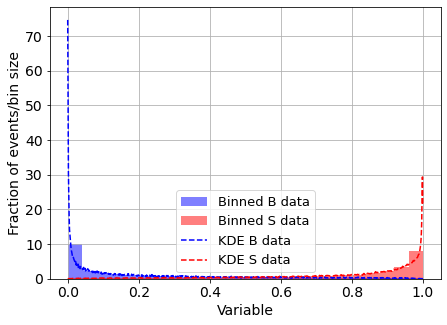

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Z BP1:5.9121649570862616
Z_std BP1:0.9462130989347409
Z_1 BP1:5.810323598478213
Z_std_1 BP1:0.7630247700073925
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Z BP2:10.734318713925106
Z_std BP2:0.9809928841294658
Z_1 BP2:10.677264423412375
Z_std_1 BP2:0.9741230610082562
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:22<00:00,  2.20s/it]


Z BP3:17.05169256977517
Z_std BP3:1.1101779454050191
Z_1 BP3:16.507767267306534
Z_std_1 BP3:0.9266934373968057
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5766752842135954
<p_{s}(Sdata)> = 4.342332167503675
<p_{b}(Bdata)> = 13.658047845290973
<p_{s}(Bdata)> = 0.30613794921339144


 20%|███████▏                            | 2/10 [00:00<00:03,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5502999740587885
<p_{s}(Sdata)> = 2.4656094077890374
<p_{b}(Bdata)> = 13.744074875361077
<p_{s}(Bdata)> = 0.3092596881044686


 50%|██████████████████                  | 5/10 [00:06<00:06,  1.35s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.38393473972006603
<p_{s}(Sdata)> = 5.839794954723089
<p_{b}(Bdata)> = 13.7797447520209
<p_{s}(Bdata)> = 0.3064029194127205


 70%|█████████████████████████▏          | 7/10 [00:09<00:04,  1.38s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.5224896760277934
<p_{s}(Sdata)> = 4.58835435451574
<p_{b}(Bdata)> = 13.66447929329979
<p_{s}(Bdata)> = 0.3062155787074172


 80%|████████████████████████████▊       | 8/10 [00:10<00:02,  1.09s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.36398305818288157
<p_{s}(Sdata)> = 3.2313902975671804
<p_{b}(Bdata)> = 13.546574861356415
<p_{s}(Bdata)> = 0.30959856497743193


 90%|████████████████████████████████▍   | 9/10 [00:10<00:00,  1.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4538544953970312
<p_{s}(Sdata)> = 3.512905954863749
<p_{b}(Bdata)> = 13.601223776546535
<p_{s}(Bdata)> = 0.309070247711188


100%|███████████████████████████████████| 10/10 [00:11<00:00,  1.10s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4798536226979935
<p_{s}(Sdata)> = 3.7433831735356584
<p_{b}(Bdata)> = 13.578018868013489
<p_{s}(Bdata)> = 0.3078541823015031
Z BP4:6.065362929644229
Z_std BP4:0.6937664959554284
Z_1 BP4:5.225590279975057
Z_std_1 BP4:0.5007988546348399
3 done


4 done


100%|███████████████████████████████████| 10/10 [00:24<00:00,  2.43s/it]


Z BP5:8.205935875384245
Z_std BP5:0.9365462065370207
Z_1 BP5:7.785113381745935
Z_std_1 BP5:0.758129967088417
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:24<00:00,  2.45s/it]


Z BP6:10.994301454793314
Z_std BP6:1.129507119899647
Z_1 BP6:10.374686691046984
Z_std_1 BP6:0.8814307170792546
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 1.0632499777714335
<p_{s}(Sdata)> = 5.216322485290785
<p_{b}(Bdata)> = 13.526117033176265
<p_{s}(Bdata)> = 0.3085077306930323


 20%|███████▏                            | 2/10 [00:00<00:03,  2.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2999741690296496
<p_{s}(Sdata)> = 6.582486762340399
<p_{b}(Bdata)> = 13.674513791675091
<p_{s}(Bdata)> = 0.3064816594062895


 40%|██████████████▍                     | 4/10 [00:03<00:05,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3463000065459936
<p_{s}(Sdata)> = 6.120316874025852
<p_{b}(Bdata)> = 13.52952227916568
<p_{s}(Bdata)> = 0.3067826042797744


 50%|██████████████████                  | 5/10 [00:04<00:04,  1.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32910608797415447
<p_{s}(Sdata)> = 3.885978579642898
<p_{b}(Bdata)> = 13.654527184833716
<p_{s}(Bdata)> = 0.3079816069847264


 60%|█████████████████████▌              | 6/10 [00:04<00:02,  1.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.39051220236302764
<p_{s}(Sdata)> = 5.303757959393854
<p_{b}(Bdata)> = 13.729689677505831
<p_{s}(Bdata)> = 0.309340254798822


 70%|█████████████████████████▏          | 7/10 [00:05<00:01,  1.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3098743345285452
<p_{s}(Sdata)> = 4.051147864642267
<p_{b}(Bdata)> = 13.666925667044062
<p_{s}(Bdata)> = 0.3083340421941087


 80%|████████████████████████████▊       | 8/10 [00:05<00:01,  1.74it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2744452349930777
<p_{s}(Sdata)> = 6.504372966871388
<p_{b}(Bdata)> = 13.644270255281935
<p_{s}(Bdata)> = 0.304900545619589


 90%|████████████████████████████████▍   | 9/10 [00:06<00:00,  1.83it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2929530953139726
<p_{s}(Sdata)> = 6.8568525977666575
<p_{b}(Bdata)> = 13.515442341037021
<p_{s}(Bdata)> = 0.30586462434224426


100%|███████████████████████████████████| 10/10 [00:06<00:00,  1.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4906720160771864
<p_{s}(Sdata)> = 4.137673550066014
<p_{b}(Bdata)> = 13.742815261594584
<p_{s}(Bdata)> = 0.3101961554898975
Z BP7:4.587276096664762
Z_std BP7:0.6638124350168279
Z_1 BP7:3.756175997474389
Z_std_1 BP7:0.4880338940049696
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2535785054749853
<p_{s}(Sdata)> = 5.419916594736995
<p_{b}(Bdata)> = 13.726939667355044
<p_{s}(Bdata)> = 0.3080128647532094


 20%|███████▏                            | 2/10 [00:00<00:03,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3149776765019241
<p_{s}(Sdata)> = 5.033058561231706
<p_{b}(Bdata)> = 13.595631857497235
<p_{s}(Bdata)> = 0.3102828656567412


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2754876704263318
<p_{s}(Sdata)> = 5.59575195465469
<p_{b}(Bdata)> = 13.629012086470114
<p_{s}(Bdata)> = 0.3080797547187355


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2300484920472397
<p_{s}(Sdata)> = 5.87631983962383
<p_{b}(Bdata)> = 13.720478550250908
<p_{s}(Bdata)> = 0.3071567704772169


 60%|█████████████████████▌              | 6/10 [00:05<00:04,  1.02s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2649013381484199
<p_{s}(Sdata)> = 4.3864705173220875
<p_{b}(Bdata)> = 13.689364976298897
<p_{s}(Bdata)> = 0.30758606890122636


 70%|█████████████████████████▏          | 7/10 [00:05<00:02,  1.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.269317245276898
<p_{s}(Sdata)> = 5.168995984462756
<p_{b}(Bdata)> = 13.610135846504228
<p_{s}(Bdata)> = 0.3102156922140763


 80%|████████████████████████████▊       | 8/10 [00:06<00:01,  1.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2746097047687424
<p_{s}(Sdata)> = 4.470206393374578
<p_{b}(Bdata)> = 13.68171579928045
<p_{s}(Bdata)> = 0.3099293597309996


100%|███████████████████████████████████| 10/10 [00:09<00:00,  1.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2750534526940307
<p_{s}(Sdata)> = 5.75673001614612
<p_{b}(Bdata)> = 13.57920456055838
<p_{s}(Bdata)> = 0.31151915752859777
Z BP8:6.784496784838772
Z_std BP8:1.099275366924416
Z_1 BP8:5.828126003044953
Z_std_1 BP8:0.7804454204285145
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22472848936272555
<p_{s}(Sdata)> = 5.259324190469372
<p_{b}(Bdata)> = 13.705166801299647
<p_{s}(Bdata)> = 0.311766843798667


 20%|███████▏                            | 2/10 [00:00<00:03,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23437966610616812
<p_{s}(Sdata)> = 5.306600119913674
<p_{b}(Bdata)> = 13.594979317117065
<p_{s}(Bdata)> = 0.30840544486905863


 40%|██████████████▍                     | 4/10 [00:03<00:05,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2180573490349952
<p_{s}(Sdata)> = 4.652479137314535
<p_{b}(Bdata)> = 13.718182488186267
<p_{s}(Bdata)> = 0.3093851748461293


 50%|██████████████████                  | 5/10 [00:04<00:03,  1.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25569556518924125
<p_{s}(Sdata)> = 4.635324603176372
<p_{b}(Bdata)> = 13.664400209757746
<p_{s}(Bdata)> = 0.3061168589452991


 70%|█████████████████████████▏          | 7/10 [00:07<00:03,  1.16s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.20240117387810191
<p_{s}(Sdata)> = 5.846227626267681
<p_{b}(Bdata)> = 13.634203639189396
<p_{s}(Bdata)> = 0.30633878388933805


100%|███████████████████████████████████| 10/10 [00:15<00:00,  1.51s/it]


Z BP9:7.828462345140205
Z_std BP9:1.163296042689148
Z_1 BP9:7.052981492928137
Z_std_1 BP9:0.7608697685037776
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.43154627936568685
<p_{s}(Sdata)> = 4.382727088700123
<p_{b}(Bdata)> = 13.605753679752773
<p_{s}(Bdata)> = 0.306904389543325


 20%|███████▏                            | 2/10 [00:00<00:03,  2.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3318867144259292
<p_{s}(Sdata)> = 5.247522277644352
<p_{b}(Bdata)> = 13.584664122070414
<p_{s}(Bdata)> = 0.30930471733438614


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.40070034649239294
<p_{s}(Sdata)> = 5.066079050939051
<p_{b}(Bdata)> = 13.666638849191207
<p_{s}(Bdata)> = 0.3058380099091435


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29461529910400414
<p_{s}(Sdata)> = 3.051264406594581
<p_{b}(Bdata)> = 13.689624932870668
<p_{s}(Bdata)> = 0.3057672489181086


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25785753770025294
<p_{s}(Sdata)> = 6.6430562866734215
<p_{b}(Bdata)> = 13.557306352715154
<p_{s}(Bdata)> = 0.31086138722670426


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31563504150555244
<p_{s}(Sdata)> = 4.811272166412301
<p_{b}(Bdata)> = 13.707621014407403
<p_{s}(Bdata)> = 0.3046700007397232


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32335459588122434
<p_{s}(Sdata)> = 5.17040036959064
<p_{b}(Bdata)> = 13.618015399327067
<p_{s}(Bdata)> = 0.3042805007047475


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28528013998848095
<p_{s}(Sdata)> = 5.94129971218014
<p_{b}(Bdata)> = 13.661338283394509
<p_{s}(Bdata)> = 0.30875265410872255


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.36146401274150974
<p_{s}(Sdata)> = 4.187585352607559
<p_{b}(Bdata)> = 13.75438274019541
<p_{s}(Bdata)> = 0.3088938656034609


100%|███████████████████████████████████| 10/10 [00:06<00:00,  1.53it/s]


Z BP10:3.861560425801409
Z_std BP10:0.9033166661028129
Z_1 BP10:3.029439553255901
Z_std_1 BP10:0.6488734168676181
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28555692297279284
<p_{s}(Sdata)> = 5.838944344686127
<p_{b}(Bdata)> = 13.62132999612668
<p_{s}(Bdata)> = 0.3081863539499375


 20%|███████▏                            | 2/10 [00:00<00:03,  2.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21536218781420727
<p_{s}(Sdata)> = 5.72701227440938
<p_{b}(Bdata)> = 13.764501239487302
<p_{s}(Bdata)> = 0.3077797779281627


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23925099045647705
<p_{s}(Sdata)> = 5.349271629307079
<p_{b}(Bdata)> = 13.699556076411296
<p_{s}(Bdata)> = 0.3090838550085032


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2709718814273284
<p_{s}(Sdata)> = 5.6983289792501095
<p_{b}(Bdata)> = 13.745700228286609
<p_{s}(Bdata)> = 0.3073721500095307


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2528442589690721
<p_{s}(Sdata)> = 5.569875132433597
<p_{b}(Bdata)> = 13.676564655929907
<p_{s}(Bdata)> = 0.3087053323795696


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.271878805640705
<p_{s}(Sdata)> = 4.794247202121313
<p_{b}(Bdata)> = 13.715915898642928
<p_{s}(Bdata)> = 0.30388604682822157


 80%|████████████████████████████▊       | 8/10 [00:05<00:01,  1.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2909753882362527
<p_{s}(Sdata)> = 4.144543545723776
<p_{b}(Bdata)> = 13.683275004343336
<p_{s}(Bdata)> = 0.3083406942849038


 90%|████████████████████████████████▍   | 9/10 [00:06<00:00,  1.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.273806772517177
<p_{s}(Sdata)> = 5.925709220777265
<p_{b}(Bdata)> = 13.819498606019028
<p_{s}(Bdata)> = 0.3057781086102695


100%|███████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23881335026922168
<p_{s}(Sdata)> = 7.0613886816584115
<p_{b}(Bdata)> = 13.613365491413886
<p_{s}(Bdata)> = 0.30976529691049925
Z BP11:5.366495488330786
Z_std BP11:0.788743654710962
Z_1 BP11:4.208093371453092
Z_std_1 BP11:0.5627991980508763
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2604389399756373
<p_{s}(Sdata)> = 4.990576096096814
<p_{b}(Bdata)> = 13.656979433096993
<p_{s}(Bdata)> = 0.3069053643824307


 20%|███████▏                            | 2/10 [00:00<00:03,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24393226083805222
<p_{s}(Sdata)> = 4.1908027021235705
<p_{b}(Bdata)> = 13.76370365543269
<p_{s}(Bdata)> = 0.30723773254333864


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21112863076749758
<p_{s}(Sdata)> = 5.8027224930598855
<p_{b}(Bdata)> = 13.75029429590298
<p_{s}(Bdata)> = 0.3028365957974343


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22676399239530934
<p_{s}(Sdata)> = 6.2286001412996
<p_{b}(Bdata)> = 13.632327144913537
<p_{s}(Bdata)> = 0.3059626139738883


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20960527389617914
<p_{s}(Sdata)> = 5.742357256250571
<p_{b}(Bdata)> = 13.676357425352759
<p_{s}(Bdata)> = 0.3065559234692443


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21141134925503074
<p_{s}(Sdata)> = 7.223465263974081
<p_{b}(Bdata)> = 13.618458929139404
<p_{s}(Bdata)> = 0.30967832685710744


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2231241574530415
<p_{s}(Sdata)> = 5.834721869298432
<p_{b}(Bdata)> = 13.569610999099076
<p_{s}(Bdata)> = 0.305038084869303


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20719721218851664
<p_{s}(Sdata)> = 6.693827182559356
<p_{b}(Bdata)> = 13.556252062568102
<p_{s}(Bdata)> = 0.30988652855343307


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22694000720990162
<p_{s}(Sdata)> = 4.955203013348586
<p_{b}(Bdata)> = 13.602705710729147
<p_{s}(Bdata)> = 0.306255459899516


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2516594171244841
<p_{s}(Sdata)> = 6.5860015468158055
<p_{b}(Bdata)> = 13.682347879559435
<p_{s}(Bdata)> = 0.3075718709124335
Z BP12:5.5842133255640505
Z_std BP12:1.1915942035542932
Z_1 BP12:4.8188252029102
Z_std_1 BP12:0.8012012648247012
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4673783120488673
<p_{s}(Sdata)> = 6.2303409067157585
<p_{b}(Bdata)> = 13.667212559766519
<p_{s}(Bdata)> = 0.3075658658330846


 20%|███████▏                            | 2/10 [00:00<00:03,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2971032241391391
<p_{s}(Sdata)> = 7.361530261107583
<p_{b}(Bdata)> = 13.830222535712622
<p_{s}(Bdata)> = 0.30463827547395406


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4922858195766557
<p_{s}(Sdata)> = 7.962262419896664
<p_{b}(Bdata)> = 13.601603302978505
<p_{s}(Bdata)> = 0.31134352380894964


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28225501971313627
<p_{s}(Sdata)> = 3.8656614254929265
<p_{b}(Bdata)> = 13.691362620226416
<p_{s}(Bdata)> = 0.3080624684516654


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.49526922874556534
<p_{s}(Sdata)> = 3.659161324574567
<p_{b}(Bdata)> = 13.675111106203772
<p_{s}(Bdata)> = 0.3073052929175151


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3133466397065666
<p_{s}(Sdata)> = 5.2877478704642185
<p_{b}(Bdata)> = 13.645365283380002
<p_{s}(Bdata)> = 0.31103382223896786


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24655620257833094
<p_{s}(Sdata)> = 4.918155153412241
<p_{b}(Bdata)> = 13.699890964969216
<p_{s}(Bdata)> = 0.30366470540112034


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2740949784014868
<p_{s}(Sdata)> = 6.49146151612013
<p_{b}(Bdata)> = 13.698256355228814
<p_{s}(Bdata)> = 0.3087171686075476


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30123221196999606
<p_{s}(Sdata)> = 7.632205048855746
<p_{b}(Bdata)> = 13.64627087343242
<p_{s}(Bdata)> = 0.3095470704787076


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4153133681043922
<p_{s}(Sdata)> = 4.656488552346025
<p_{b}(Bdata)> = 13.672631272626619
<p_{s}(Bdata)> = 0.30532374930063033
Z BP13:3.1236517825583427
Z_std BP13:0.772298301747569
Z_1 BP13:2.3147249237902097
Z_std_1 BP13:0.5706454203347359
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2582087777787531
<p_{s}(Sdata)> = 6.788209289517711
<p_{b}(Bdata)> = 13.652324560143011
<p_{s}(Bdata)> = 0.30771673192225407


 20%|███████▏                            | 2/10 [00:00<00:03,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26296726033551693
<p_{s}(Sdata)> = 6.27868796081844
<p_{b}(Bdata)> = 13.703965145677136
<p_{s}(Bdata)> = 0.3048535855141522


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23706701023922133
<p_{s}(Sdata)> = 5.165093911849678
<p_{b}(Bdata)> = 13.773271102296473
<p_{s}(Bdata)> = 0.3075063355307344


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.45060189753531216
<p_{s}(Sdata)> = 5.667357402813023
<p_{b}(Bdata)> = 13.578571080072496
<p_{s}(Bdata)> = 0.30550609775565707


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28499945760492174
<p_{s}(Sdata)> = 6.3616742608392745
<p_{b}(Bdata)> = 13.71222738062301
<p_{s}(Bdata)> = 0.30921158218144457


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28433157754110144
<p_{s}(Sdata)> = 5.912720467669318
<p_{b}(Bdata)> = 13.766617725690702
<p_{s}(Bdata)> = 0.305255041744387


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2928104106938987
<p_{s}(Sdata)> = 5.970837431212767
<p_{b}(Bdata)> = 13.759428431448132
<p_{s}(Bdata)> = 0.30533459561862347


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26839486855810196
<p_{s}(Sdata)> = 7.53740248072821
<p_{b}(Bdata)> = 13.669844209215716
<p_{s}(Bdata)> = 0.3084018761508882


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.256628111542615
<p_{s}(Sdata)> = 5.693025878450129
<p_{b}(Bdata)> = 13.547315860936134
<p_{s}(Bdata)> = 0.30770373465918754


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18630814919084632
<p_{s}(Sdata)> = 7.263899976968761
<p_{b}(Bdata)> = 13.665207195811522
<p_{s}(Bdata)> = 0.3042007309554064
Z BP14:4.042297642151408
Z_std BP14:0.4413306844851518
Z_1 BP14:3.1471841295462473
Z_std_1 BP14:0.33149627079962957
3 done


4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2559693698270954
<p_{s}(Sdata)> = 5.664805433401556
<p_{b}(Bdata)> = 13.590058389985458
<p_{s}(Bdata)> = 0.3114060947417923


 20%|███████▏                            | 2/10 [00:00<00:03,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23556254072412178
<p_{s}(Sdata)> = 5.159843988383944
<p_{b}(Bdata)> = 13.753620187234976
<p_{s}(Bdata)> = 0.3083577777170445


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23323953443732873
<p_{s}(Sdata)> = 5.679699300581372
<p_{b}(Bdata)> = 13.69907289357482
<p_{s}(Bdata)> = 0.3067036930915614


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28683686992929314
<p_{s}(Sdata)> = 5.679730855965806
<p_{b}(Bdata)> = 13.713047566826454
<p_{s}(Bdata)> = 0.3081258813311346


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25524065245067645
<p_{s}(Sdata)> = 5.649481994276674
<p_{b}(Bdata)> = 13.735637320770996
<p_{s}(Bdata)> = 0.3075234639766185


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2310562861612902
<p_{s}(Sdata)> = 5.267421564274112
<p_{b}(Bdata)> = 13.67391568807128
<p_{s}(Bdata)> = 0.30784963636721274


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2603322379903896
<p_{s}(Sdata)> = 3.250721014114765
<p_{b}(Bdata)> = 13.638649768076595
<p_{s}(Bdata)> = 0.3067517741264611


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24501754468397619
<p_{s}(Sdata)> = 4.566745273489447
<p_{b}(Bdata)> = 13.641083503515237
<p_{s}(Bdata)> = 0.307824643090463


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.263240818293127
<p_{s}(Sdata)> = 7.244963688001914
<p_{b}(Bdata)> = 13.79414866277751
<p_{s}(Bdata)> = 0.3054669663634748


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2073695926507415
<p_{s}(Sdata)> = 6.261081881958089
<p_{b}(Bdata)> = 13.653656151010143
<p_{s}(Bdata)> = 0.30801995594116494
Z BP15:5.029130861811353
Z_std BP15:0.6798111405831427
Z_1 BP15:4.0154107271516235
Z_std_1 BP15:0.4933854691227182
8


AUC:0.9367840508658455


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  9998.36305579  9670.11145527
  9263.52819175  8758.22025928  8158.60603853  7437.11101076
  6598.99058462  5630.94383291  4519.56733607  3218.5714223
  1680.29920375  -138.0681948  -2313.18483089 -5157.98621529]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
  7780.84952676  7750.51279822  7666.83251569  7527.01839137
 

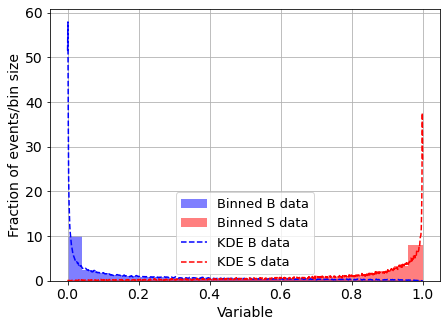

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0007122485584859914
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:15<00:00,  1.51s/it]


Z BP1:4.964980879127724
Z_std BP1:1.454873565111692
Z_1 BP1:4.749463875706077
Z_std_1 BP1:1.7889914270244769
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:15<00:00,  1.50s/it]


Z BP2:10.227068844689029
Z_std BP2:0.9472256164544135
Z_1 BP2:9.963347643657888
Z_std_1 BP2:1.0495072232696148
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Z BP3:16.50511685461733
Z_std BP3:0.9081741097489953
Z_1 BP3:16.499621146703376
Z_std_1 BP3:0.8931112961210539
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Z BP4:3.8943448912502396
Z_std BP4:1.0034059999967202
Z_1 BP4:3.874693099041082
Z_std_1 BP4:0.8672282796210756
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]


Z BP5:7.502632878647219
Z_std BP5:1.1902369570258184
Z_1 BP5:7.490343930587826
Z_std_1 BP5:1.1516717313136906
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.88s/it]


Z BP6:10.782143964454734
Z_std BP6:1.057286496129409
Z_1 BP6:10.775715915788092
Z_std_1 BP6:1.0163410365543772
3 done
4 done


 40%|██████████████▍                     | 4/10 [00:07<00:10,  1.69s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.480173521059728
<p_{s}(Sdata)> = 5.767797395859153
<p_{b}(Bdata)> = 11.464320931811052
<p_{s}(Bdata)> = 0.30789365407820446


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.10s/it]


Z BP7:3.820987778358804
Z_std BP7:0.8504112493157283
Z_1 BP7:3.5814434979301817
Z_std_1 BP7:0.7331218234866981
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]


Z BP8:5.352964675963898
Z_std BP8:1.0106618213901224
Z_1 BP8:5.299643465114713
Z_std_1 BP8:0.8516794875945813
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:22<00:00,  2.20s/it]


Z BP9:7.79064903979279
Z_std BP9:0.9363955437002288
Z_1 BP9:7.589239446851526
Z_std_1 BP9:0.7998046309889602
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4466870831382563
<p_{s}(Sdata)> = 5.818176920874382
<p_{b}(Bdata)> = 11.552135623520895
<p_{s}(Bdata)> = 0.3063998567628825


 20%|███████▏                            | 2/10 [00:00<00:03,  2.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2831850751592214
<p_{s}(Sdata)> = 7.228836683737172
<p_{b}(Bdata)> = 11.460289456454058
<p_{s}(Bdata)> = 0.3062167574398073


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.6235880697948729
<p_{s}(Sdata)> = 3.4191568162073165
<p_{b}(Bdata)> = 11.500949282528326
<p_{s}(Bdata)> = 0.30774993898512193


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25043587978048126
<p_{s}(Sdata)> = 6.793441498390282
<p_{b}(Bdata)> = 11.529263480339422
<p_{s}(Bdata)> = 0.30927187871293277


 70%|█████████████████████████▏          | 7/10 [00:05<00:02,  1.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2503427411877692
<p_{s}(Sdata)> = 8.581525436222181
<p_{b}(Bdata)> = 11.535619646854565
<p_{s}(Bdata)> = 0.30919864503133715


 80%|████████████████████████████▊       | 8/10 [00:06<00:01,  1.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 1.8029207956847075
<p_{s}(Sdata)> = 9.37793120185301
<p_{b}(Bdata)> = 11.57885116450398
<p_{s}(Bdata)> = 0.30679385765720196


 90%|████████████████████████████████▍   | 9/10 [00:06<00:00,  1.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27843042227119685
<p_{s}(Sdata)> = 7.812616542782906
<p_{b}(Bdata)> = 11.48129190863913
<p_{s}(Bdata)> = 0.3071665806646964


100%|███████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


Z BP10:3.750703929778834
Z_std BP10:0.9410297632918314
Z_1 BP10:3.1930468428297365
Z_std_1 BP10:0.7470222426105539
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2630388901680724
<p_{s}(Sdata)> = 7.340044712455139
<p_{b}(Bdata)> = 11.517762638267579
<p_{s}(Bdata)> = 0.3067508945724362
Z BP11:4.3097482972884595
Z_std BP11:0.9117769781452111
Z_1 BP11:4.0964034689593545
Z_std_1 BP11:0.699532941740666


3 done
4 done


 70%|█████████████████████████▏          | 7/10 [00:15<00:05,  1.91s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2351863676292275
<p_{s}(Sdata)> = 5.719950751031061
<p_{b}(Bdata)> = 11.504173943563071
<p_{s}(Bdata)> = 0.3085350624540141


100%|███████████████████████████████████| 10/10 [00:22<00:00,  2.30s/it]


Z BP12:5.906974238533193
Z_std BP12:0.8483474333391691
Z_1 BP12:5.597628431517165
Z_std_1 BP12:0.699643703451176
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2691448190739478
<p_{s}(Sdata)> = 7.098160336034193
<p_{b}(Bdata)> = 11.427634434221567
<p_{s}(Bdata)> = 0.30741110948715866


 20%|███████▏                            | 2/10 [00:00<00:03,  2.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32074276651982286
<p_{s}(Sdata)> = 9.188535844738253
<p_{b}(Bdata)> = 11.526119360552247
<p_{s}(Bdata)> = 0.30393771014062176


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3003298485213222
<p_{s}(Sdata)> = 8.697626314055967
<p_{b}(Bdata)> = 11.414428674666235
<p_{s}(Bdata)> = 0.30727356128196626


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2821431006684136
<p_{s}(Sdata)> = 8.402176820648357
<p_{b}(Bdata)> = 11.543016581510244
<p_{s}(Bdata)> = 0.30678220902753633


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3085172740563183
<p_{s}(Sdata)> = 10.911641500329722
<p_{b}(Bdata)> = 11.525751598319252
<p_{s}(Bdata)> = 0.3063126717930785


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2645019524122477
<p_{s}(Sdata)> = 6.814184513043219
<p_{b}(Bdata)> = 11.411986208794689
<p_{s}(Bdata)> = 0.3111494549344163


 80%|████████████████████████████▊       | 8/10 [00:05<00:01,  1.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2726731824900458
<p_{s}(Sdata)> = 7.887889936212681
<p_{b}(Bdata)> = 11.574829740282421
<p_{s}(Bdata)> = 0.30469043131420726


 90%|████████████████████████████████▍   | 9/10 [00:06<00:00,  1.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.363478193220356
<p_{s}(Sdata)> = 3.9111218265369287
<p_{b}(Bdata)> = 11.54664471081936
<p_{s}(Bdata)> = 0.30608780416115583


100%|███████████████████████████████████| 10/10 [00:06<00:00,  1.47it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2913541613920715
<p_{s}(Sdata)> = 7.375857012852265
<p_{b}(Bdata)> = 11.53722124498784
<p_{s}(Bdata)> = 0.3068559685769071
Z BP13:2.9206190366272304
Z_std BP13:0.6129830171352154
Z_1 BP13:2.3530275823377886
Z_std_1 BP13:0.41656859758683834


3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22905580063510808
<p_{s}(Sdata)> = 12.118288789915049
<p_{b}(Bdata)> = 11.543117734469645
<p_{s}(Bdata)> = 0.30854119470964503


 30%|██████████▊                         | 3/10 [00:03<00:07,  1.07s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.26424352241965593
<p_{s}(Sdata)> = 4.745802891948105
<p_{b}(Bdata)> = 11.468651094114447
<p_{s}(Bdata)> = 0.30855307483606986


 40%|██████████████▍                     | 4/10 [00:03<00:05,  1.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2411566373402248
<p_{s}(Sdata)> = 7.306887857152693
<p_{b}(Bdata)> = 11.427702200645328
<p_{s}(Bdata)> = 0.307961078609643


 70%|█████████████████████████▏          | 7/10 [00:10<00:04,  1.53s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.23174194810400828
<p_{s}(Sdata)> = 6.487787492250265
<p_{b}(Bdata)> = 11.478224294486575
<p_{s}(Bdata)> = 0.3078810606022534


 80%|████████████████████████████▊       | 8/10 [00:10<00:02,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.22230584761991992
<p_{s}(Sdata)> = 6.584003340785167
<p_{b}(Bdata)> = 11.55065326417593
<p_{s}(Bdata)> = 0.30572699728014513


100%|███████████████████████████████████| 10/10 [00:13<00:00,  1.32s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.25049417007555075
<p_{s}(Sdata)> = 8.725864478931964
<p_{b}(Bdata)> = 11.506691147306428
<p_{s}(Bdata)> = 0.30620001231364546
Z BP14:3.181453870853432
Z_std BP14:1.2331443620963656
Z_1 BP14:2.7376563051379144
Z_std_1 BP14:0.9081890786459254


3 done
4 done


 20%|███████▏                            | 2/10 [00:02<00:08,  1.08s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24449809148789084
<p_{s}(Sdata)> = 5.744885211618181
<p_{b}(Bdata)> = 11.49841582419797
<p_{s}(Bdata)> = 0.3094544329965282


 60%|█████████████████████▌              | 6/10 [00:10<00:06,  1.63s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2968186684224543
<p_{s}(Sdata)> = 8.890549418227659
<p_{b}(Bdata)> = 11.530791492545339
<p_{s}(Bdata)> = 0.30568303450089046


 70%|█████████████████████████▏          | 7/10 [00:11<00:03,  1.26s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2695751388129226
<p_{s}(Sdata)> = 8.566040813965587
<p_{b}(Bdata)> = 11.584176961161987
<p_{s}(Bdata)> = 0.30634445757999945


 90%|████████████████████████████████▍   | 9/10 [00:14<00:01,  1.25s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2010852235095043
<p_{s}(Sdata)> = 8.147385726341453
<p_{b}(Bdata)> = 11.586362875790398
<p_{s}(Bdata)> = 0.3058767103279174


100%|███████████████████████████████████| 10/10 [00:15<00:00,  1.55s/it]


Z BP15:4.134613253960752
Z_std BP15:1.1751730879747893
Z_1 BP15:3.793724223601711
Z_std_1 BP15:0.8814834033017604
9
AUC:0.9367776741737595


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  9929.52156129  9604.57971964
  9196.62139757  8694.82608308  8103.59257418  7398.98629124
  6571.22579459  5611.71861794  4494.76190549  3195.08851941
  1676.43076475  -149.47331807 -2334.27696253 -5166.43386446]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  7603.79135437  7550.13655224  7438.24608614


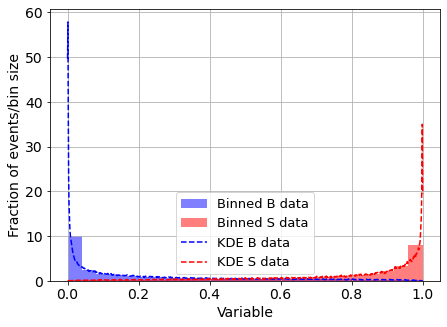

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:16<00:00,  1.60s/it]


Z BP1:5.769720890983704
Z_std BP1:2.14481263880084
Z_1 BP1:5.614801327694672
Z_std_1 BP1:2.275297577499324
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:15<00:00,  1.53s/it]


Z BP2:12.175514957391096
Z_std BP2:0.9517534111763953
Z_1 BP2:11.964889642051915
Z_std_1 BP2:1.0613715794960317
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]


Z BP3:18.042804906133657
Z_std BP3:1.60086637461639
Z_1 BP3:18.0431930774901
Z_std_1 BP3:1.5959489410917878
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:20<00:00,  2.04s/it]


Z BP4:5.416854183245364
Z_std BP4:0.8025500370207644
Z_1 BP4:5.387425750463081
Z_std_1 BP4:0.7918048195549502
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Z BP5:9.545992480533096
Z_std BP5:0.9309752985069897
Z_1 BP5:9.518148744304339
Z_std_1 BP5:0.9208800743475626
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


Z BP6:12.725715382143074
Z_std BP6:1.1218090917080579
Z_1 BP6:12.706803612915591
Z_std_1 BP6:1.0762838095901786
3 done
4 done


 50%|██████████████████                  | 5/10 [00:10<00:09,  1.85s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.4413242500814964
<p_{s}(Sdata)> = 5.838167068517512
<p_{b}(Bdata)> = 11.398029921496159
<p_{s}(Bdata)> = 0.30338315309910263


 90%|████████████████████████████████▍   | 9/10 [00:19<00:01,  1.84s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.33586229890535063
<p_{s}(Sdata)> = 5.224482436159873
<p_{b}(Bdata)> = 11.356161396650188
<p_{s}(Bdata)> = 0.29911662028514485


100%|███████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]

muhat = 2.1
<p_{b}(Sdata)> = 1.0168987946019026
<p_{s}(Sdata)> = 5.783821826375595
<p_{b}(Bdata)> = 11.256183713792371
<p_{s}(Bdata)> = 0.3018431814535366
Z BP7:5.32643773261358
Z_std BP7:1.0410710471634437
Z_1 BP7:5.035469880046238
Z_std_1 BP7:0.7733969918334826


3 done
4 done


100%|███████████████████████████████████| 10/10 [00:22<00:00,  2.28s/it]


Z BP8:6.997830676026651
Z_std BP8:1.2711293793245964
Z_1 BP8:6.880530179481862
Z_std_1 BP8:1.1564335708876656
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:23<00:00,  2.33s/it]


Z BP9:9.58714498371672
Z_std BP9:1.3986081431353905
Z_1 BP9:9.391705942259371
Z_std_1 BP9:1.2202447596482369
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4137101042108165
<p_{s}(Sdata)> = 4.034375313020186
<p_{b}(Bdata)> = 11.463259298160121
<p_{s}(Bdata)> = 0.30202514429677646


 20%|███████▏                            | 2/10 [00:00<00:03,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2782384194564337
<p_{s}(Sdata)> = 5.966825298777018
<p_{b}(Bdata)> = 11.389707011692835
<p_{s}(Bdata)> = 0.2987554725750263


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34100414609104246
<p_{s}(Sdata)> = 5.395190474087069
<p_{b}(Bdata)> = 11.39138852878498
<p_{s}(Bdata)> = 0.30190830656782586


 60%|█████████████████████▌              | 6/10 [00:07<00:05,  1.41s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.3387358729103864
<p_{s}(Sdata)> = 5.804397298506423
<p_{b}(Bdata)> = 11.444740590675657
<p_{s}(Bdata)> = 0.2987851273738311


 70%|█████████████████████████▏          | 7/10 [00:08<00:03,  1.11s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2628168081236223
<p_{s}(Sdata)> = 9.170094780635706
<p_{b}(Bdata)> = 11.457741561139716
<p_{s}(Bdata)> = 0.2991465485513715


 80%|████████████████████████████▊       | 8/10 [00:08<00:01,  1.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31278715836883697
<p_{s}(Sdata)> = 5.7718511139251785
<p_{b}(Bdata)> = 11.486979036649522
<p_{s}(Bdata)> = 0.2974031030219359


 90%|████████████████████████████████▍   | 9/10 [00:08<00:00,  1.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28131461410063696
<p_{s}(Sdata)> = 8.289616118857694
<p_{b}(Bdata)> = 11.439227263321687
<p_{s}(Bdata)> = 0.30032355546058453


100%|███████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]


Z BP10:4.560690595158266
Z_std BP10:1.0096971503784529
Z_1 BP10:3.9077476176353505
Z_std_1 BP10:0.8001183825279522
3 done
4 done


 30%|██████████▊                         | 3/10 [00:05<00:11,  1.64s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2894619585021699
<p_{s}(Sdata)> = 5.084004834161608
<p_{b}(Bdata)> = 11.32341629355098
<p_{s}(Bdata)> = 0.30227438939561024


 40%|██████████████▍                     | 4/10 [00:06<00:07,  1.19s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24524847900835764
<p_{s}(Sdata)> = 5.783238835730955
<p_{b}(Bdata)> = 11.395563492803694
<p_{s}(Bdata)> = 0.301022629417355


 50%|██████████████████                  | 5/10 [00:06<00:04,  1.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2818925846990089
<p_{s}(Sdata)> = 5.6205336159487285
<p_{b}(Bdata)> = 11.414380063003183
<p_{s}(Bdata)> = 0.3004228138421503


100%|███████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


Z BP11:5.970952348306713
Z_std BP11:1.0183940004158973
Z_1 BP11:5.533293291882163
Z_std_1 BP11:0.869328528847984
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:24<00:00,  2.41s/it]


Z BP12:6.864961051661043
Z_std BP12:0.8873110893523665
Z_1 BP12:6.597438837390807
Z_std_1 BP12:0.7989657030048023
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5158065760429761
<p_{s}(Sdata)> = 4.605747359115883
<p_{b}(Bdata)> = 11.435481685257107
<p_{s}(Bdata)> = 0.3005466650421296


 20%|███████▏                            | 2/10 [00:00<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23284826391106037
<p_{s}(Sdata)> = 6.568821989963637
<p_{b}(Bdata)> = 11.450949090171834
<p_{s}(Bdata)> = 0.2979950682516166


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.6277837954398848
<p_{s}(Sdata)> = 6.914112887666092
<p_{b}(Bdata)> = 11.484230476415986
<p_{s}(Bdata)> = 0.30063414665892435


 40%|██████████████▍                     | 4/10 [00:01<00:02,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4753290295654037
<p_{s}(Sdata)> = 5.934980901554804
<p_{b}(Bdata)> = 11.410088236615552
<p_{s}(Bdata)> = 0.29995569693945623


 50%|██████████████████                  | 5/10 [00:02<00:02,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30519344313241714
<p_{s}(Sdata)> = 5.74584656181523
<p_{b}(Bdata)> = 11.426554895012
<p_{s}(Bdata)> = 0.3018331214567337


 60%|█████████████████████▌              | 6/10 [00:02<00:01,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21171183368157206
<p_{s}(Sdata)> = 6.2145621103337385
<p_{b}(Bdata)> = 11.344994114577121
<p_{s}(Bdata)> = 0.30265238421156354


 70%|█████████████████████████▏          | 7/10 [00:03<00:01,  2.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3786808142040921
<p_{s}(Sdata)> = 4.872759540459977
<p_{b}(Bdata)> = 11.441308987631439
<p_{s}(Bdata)> = 0.3020217698584434


 80%|████████████████████████████▊       | 8/10 [00:03<00:00,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.40085486265597403
<p_{s}(Sdata)> = 4.5339681583779665
<p_{b}(Bdata)> = 11.39545311537861
<p_{s}(Bdata)> = 0.29906062289177415


 90%|████████████████████████████████▍   | 9/10 [00:04<00:00,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24178045362477674
<p_{s}(Sdata)> = 6.327341485111427
<p_{b}(Bdata)> = 11.406150741995006
<p_{s}(Bdata)> = 0.3021054101442784


100%|███████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2909037454298832
<p_{s}(Sdata)> = 7.864141815749252
<p_{b}(Bdata)> = 11.332922694587873
<p_{s}(Bdata)> = 0.301636545878401
Z BP13:3.9970513539993866
Z_std BP13:0.5597652937424847
Z_1 BP13:3.2517172052918437
Z_std_1 BP13:0.4180617496763417


3 done
4 done


 20%|███████▏                            | 2/10 [00:02<00:10,  1.26s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.2984367326056241
<p_{s}(Sdata)> = 3.9965083007979167
<p_{b}(Bdata)> = 11.268773876563664
<p_{s}(Bdata)> = 0.30291639471847004


 40%|██████████████▍                     | 4/10 [00:05<00:08,  1.34s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.19236079188671204
<p_{s}(Sdata)> = 7.470364280494429
<p_{b}(Bdata)> = 11.398257252803868
<p_{s}(Bdata)> = 0.3033140313292239


 50%|██████████████████                  | 5/10 [00:06<00:05,  1.03s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.28254560317857247
<p_{s}(Sdata)> = 5.206421844601022
<p_{b}(Bdata)> = 11.327065446737247
<p_{s}(Bdata)> = 0.30217659136918484


 60%|█████████████████████▌              | 6/10 [00:06<00:03,  1.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24879879245015918
<p_{s}(Sdata)> = 3.952261979534679
<p_{b}(Bdata)> = 11.357593915342946
<p_{s}(Bdata)> = 0.302123283177676


 70%|█████████████████████████▏          | 7/10 [00:07<00:02,  1.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2739604205792161
<p_{s}(Sdata)> = 6.1146148100944355
<p_{b}(Bdata)> = 11.41819310300864
<p_{s}(Bdata)> = 0.3019095047404285


 80%|████████████████████████████▊       | 8/10 [00:07<00:01,  1.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2540966936722786
<p_{s}(Sdata)> = 7.359313639945622
<p_{b}(Bdata)> = 11.373015491135858
<p_{s}(Bdata)> = 0.3024281323711354


 90%|████████████████████████████████▍   | 9/10 [00:08<00:00,  1.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27862095124254405
<p_{s}(Sdata)> = 5.615336325902301
<p_{b}(Bdata)> = 11.370623136354377
<p_{s}(Bdata)> = 0.302566209673809


100%|███████████████████████████████████| 10/10 [00:11<00:00,  1.13s/it]


Z BP14:4.983410534327918
Z_std BP14:1.1245380892931118
Z_1 BP14:4.2720187390172555
Z_std_1 BP14:0.8433864989344948
3 done
4 done


 10%|███▌                                | 1/10 [00:00<00:04,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2622609421052797
<p_{s}(Sdata)> = 5.955593778468616
<p_{b}(Bdata)> = 11.326450364966155
<p_{s}(Bdata)> = 0.3023314611859343


 20%|███████▏                            | 2/10 [00:00<00:03,  2.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24983342252083612
<p_{s}(Sdata)> = 7.810250061783658
<p_{b}(Bdata)> = 11.408060395502165
<p_{s}(Bdata)> = 0.29924274783194016


 30%|██████████▊                         | 3/10 [00:01<00:03,  2.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18465805180501896
<p_{s}(Sdata)> = 8.841587301313686
<p_{b}(Bdata)> = 11.317596606855258
<p_{s}(Bdata)> = 0.30066613388156127


 50%|██████████████████                  | 5/10 [00:04<00:05,  1.07s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.18356609046249336
<p_{s}(Sdata)> = 7.96654349013621
<p_{b}(Bdata)> = 11.463705321587039
<p_{s}(Bdata)> = 0.2995732855608115


 60%|█████████████████████▌              | 6/10 [00:05<00:03,  1.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2131981020179372
<p_{s}(Sdata)> = 6.250748890235611
<p_{b}(Bdata)> = 11.370832439286945
<p_{s}(Bdata)> = 0.29957459552388993


 70%|█████████████████████████▏          | 7/10 [00:05<00:02,  1.34it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22449962786180142
<p_{s}(Sdata)> = 5.433050136892055
<p_{b}(Bdata)> = 11.293085297301865
<p_{s}(Bdata)> = 0.2989201821542973


 90%|████████████████████████████████▍   | 9/10 [00:08<00:01,  1.04s/it]

muhat = 2.1
<p_{b}(Sdata)> = 0.24755895108601803
<p_{s}(Sdata)> = 5.262964436431476
<p_{b}(Bdata)> = 11.352520337274015
<p_{s}(Bdata)> = 0.30184242977150205


100%|███████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21836562612320393
<p_{s}(Sdata)> = 6.139333052125164
<p_{b}(Bdata)> = 11.392220220631081
<p_{s}(Bdata)> = 0.3006757553591356
Z BP15:5.969671747184792
Z_std BP15:0.8984461602670033
Z_1 BP15:5.3754921912587905
Z_std_1 BP15:0.7656200643057878


In [369]:
nloops = 10
Z_MLL        = np.zeros((15, nloops))
Z_MLL_std    = np.zeros((15, nloops))
Z_MLL_mu     = np.zeros((15, nloops))
Z_MLL_std_mu = np.zeros((15, nloops))

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []

BPS_analyzed = np.arange(15)

np.random.seed(28890)

for iloop in range(nloops):
    
    print(iloop)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    nobs_bp = round(nobs / len(BPS_analyzed))
    
    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df = pd.DataFrame()

    mask_list = []
    for bp in BPS_analyzed:
        BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = nobs_bp, replace = False)
        mask = np.ones(len(photon_NP[bp]), dtype=bool)
        mask[BP_indices] = False
        mask_list.append( mask )
        if bp == 0:

            df[lst[0]] = np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][BP_indices,0]])
            df[lst[1]] = np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][BP_indices,1]])
            df[lst[2]] = np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][BP_indices,2]])
            df[lst[3]] = np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][BP_indices,3]])

            df[lst[4]] = np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][BP_indices,0]])
            df[lst[5]] = np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][BP_indices,1]])
            df[lst[6]] = np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][BP_indices,2]])

            df[lst[7]] = np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][BP_indices,0]])
            df[lst[8]] = np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][BP_indices,1]])
            df[lst[9]] = np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][BP_indices,2]])
            df[lst[10]] = np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][BP_indices,3]])
            df[lst[11]] = np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][BP_indices,4]])

            df[lst[12]] = np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][BP_indices,0]])
            df[lst[13]] = np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][BP_indices,2]])

            df[lst[14]] = np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][BP_indices,0]])
            df[lst[15]] = np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][BP_indices,1]])
            df[lst[16]] = np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][BP_indices,2]])

            df[lst[17]] = np.concatenate([ST_SM[SM_indices], ST_NP[bp][BP_indices]])
            df[lst[18]] = np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][BP_indices]])

            df[lst[19]] = np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][BP_indices]])
            df[lst[20]] = np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][BP_indices]])
            df[lst[21]] = np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][BP_indices]])


            df['bkg_flag'] = np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][BP_indices]))) )

            df[lst[22]] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices]))])

            df['bp_flag'] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) ])
        else:
            df_aux = pd.DataFrame()

            df_aux[lst[0]] = photon_NP[bp][BP_indices,0] 
            df_aux[lst[1]] = photon_NP[bp][BP_indices,1] 
            df_aux[lst[2]] = photon_NP[bp][BP_indices,2] 
            df_aux[lst[3]] = photon_NP[bp][BP_indices,3] 

            df_aux[lst[4]] = jet_NP[bp][BP_indices,0] 
            df_aux[lst[5]] = jet_NP[bp][BP_indices,1] 
            df_aux[lst[6]] = jet_NP[bp][BP_indices,2] 

            df_aux[lst[7]] = lepton_NP[bp][BP_indices,0] 
            df_aux[lst[8]] = lepton_NP[bp][BP_indices,1] 
            df_aux[lst[9]] = lepton_NP[bp][BP_indices,2] 
            df_aux[lst[10]] = lepton_NP[bp][BP_indices,3] 
            df_aux[lst[11]] = lepton_NP[bp][BP_indices,4] 

            df_aux[lst[12]] = MET_NP[bp][BP_indices,0] 
            df_aux[lst[13]] = MET_NP[bp][BP_indices,2] 

            df_aux[lst[14]] = hadinfo_NP[bp][BP_indices,0] 
            df_aux[lst[15]] = hadinfo_NP[bp][BP_indices,1] 
            df_aux[lst[16]] = hadinfo_NP[bp][BP_indices,2] 

            df_aux[lst[17]] = ST_NP[bp][BP_indices] 
            df_aux[lst[18]] = MET_sig_NP[bp][BP_indices] 

            df_aux[lst[19]] = mT_photon_NP[bp][BP_indices] 
            df_aux[lst[20]] = mT_jet_NP[bp][BP_indices] 
            df_aux[lst[21]] = mT_lepton_NP[bp][BP_indices] 


            df_aux['bkg_flag'] = np.zeros(len(photon_NP[bp][BP_indices]))

            df_aux[lst[22]] = np.ones(len(photon_NP[bp][BP_indices]))
            df_aux['bp_flag'] = np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) 

            df = pd.concat((df, df_aux))
    df_array = np.asarray(df)
    
    
    SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

    df_test = pd.DataFrame()

    for bp in BPS_analyzed:
        mask = mask_list[bp]
        mask[np.random.choice(np.arange(len(mask)), (len(mask) - 15_000), replace = False)] = False # Set to false everything but 15000
        
        if bp == 0:

            df_test[lst[0]] = np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][mask,0]])
            df_test[lst[1]] = np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][mask,1]])
            df_test[lst[2]] = np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][mask,2]])
            df_test[lst[3]] = np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][mask,3]])

            df_test[lst[4]] = np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][mask,0]])
            df_test[lst[5]] = np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][mask,1]])
            df_test[lst[6]] = np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][mask,2]])

            df_test[lst[7]] = np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][mask,0]])
            df_test[lst[8]] = np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][mask,1]])
            df_test[lst[9]] = np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][mask,2]])
            df_test[lst[10]] = np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][mask,3]])
            df_test[lst[11]] = np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][mask,4]])

            df_test[lst[12]] = np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][mask,0]])
            df_test[lst[13]] = np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][mask,2]])

            df_test[lst[14]] = np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][mask,0]])
            df_test[lst[15]] = np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][mask,1]])
            df_test[lst[16]] = np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][mask,2]])

            df_test[lst[17]] = np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][mask]])
            df_test[lst[18]] = np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][mask]])

            df_test[lst[19]] = np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][mask]])
            df_test[lst[20]] = np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][mask]])
            df_test[lst[21]] = np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][mask]])


            df_test['bkg_flag_pool'] = np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][mask]))) )

            df_test[lst[22]] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask]))])

            df_test['bp_flag'] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask])) * (bp+1) ])

        else:
            df_aux = pd.DataFrame()

            df_aux[lst[0]] = photon_NP[bp][mask,0] 
            df_aux[lst[1]] = photon_NP[bp][mask,1] 
            df_aux[lst[2]] = photon_NP[bp][mask,2] 
            df_aux[lst[3]] = photon_NP[bp][mask,3] 

            df_aux[lst[4]] = jet_NP[bp][mask,0] 
            df_aux[lst[5]] = jet_NP[bp][mask,1] 
            df_aux[lst[6]] = jet_NP[bp][mask,2] 

            df_aux[lst[7]] = lepton_NP[bp][mask,0] 
            df_aux[lst[8]] = lepton_NP[bp][mask,1] 
            df_aux[lst[9]] = lepton_NP[bp][mask,2] 
            df_aux[lst[10]] = lepton_NP[bp][mask,3] 
            df_aux[lst[11]] = lepton_NP[bp][mask,4] 

            df_aux[lst[12]] = MET_NP[bp][mask,0] 
            df_aux[lst[13]] = MET_NP[bp][mask,2] 

            df_aux[lst[14]] = hadinfo_NP[bp][mask,0] 
            df_aux[lst[15]] = hadinfo_NP[bp][mask,1] 
            df_aux[lst[16]] = hadinfo_NP[bp][mask,2] 

            df_aux[lst[17]] = ST_NP[bp][mask] 
            df_aux[lst[18]] = MET_sig_NP[bp][mask] 

            df_aux[lst[19]] = mT_photon_NP[bp][mask] 
            df_aux[lst[20]] = mT_jet_NP[bp][mask] 
            df_aux[lst[21]] = mT_lepton_NP[bp][mask] 


            df_aux['bkg_flag_pool'] = np.zeros(len(photon_NP[bp][mask]))

            df_aux[lst[22]] = np.ones(len(photon_NP[bp][mask]))

            df_aux['bp_flag'] = np.ones(len(photon_NP[bp][mask])) * (bp+1)

            df_test = pd.concat((df_test, df_aux))
    df_test_array = np.asarray(df_test)
    
    nobs = len(df_array)

    train_size = int(0.80 * nobs)
    val_size   = nobs - train_size #%- test_size 

    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    val_indices   = random_indices[train_size:]    
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -2]

    X_test        = df_test_array[:, :22]
    bkg_flag_test = df_test_array[:, 22]
    y_mon_test    = df_test_array[:, -2]

    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -2]
    
    # to normalize
    x_scaler = preprocessing.MinMaxScaler()
    x_scaler = x_scaler.fit(X_train)

    X_mon_train = x_scaler.transform(X_train)
    X_mon_test  = x_scaler.transform(X_test)
    X_mon_val   = x_scaler.transform(X_val)
    
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators  = 500,
        learning_rate = 0.1,
        reg_lambda    = 0.0, reg_alpha = 0.0,
        early_stopping_rounds = 50,#early stopping
        eval_metric = 'logloss',
        gamma = 0.0, objective = 'binary:logistic',
        max_depth = 5)

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  = False)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
    auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
    auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
    auc_total.append( auc(fpr_total, tpr_total) )
    
    
    print('AUC:' + str(auc_total[iloop]))
    
    NP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 50_000, replace = False)
    SM_indices = np.random.choice(np.arange(len(pred_XG_SM)), size = 50_000, replace = False)
    
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM[SM_indices], pred_XG_NP[NP_indices], 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    mask = np.ones(len(pred_XG_SM), dtype=bool)
    mask[SM_indices] = False
    pred_XG_SM = pred_XG_SM[mask]
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP

    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    for bp in BPS_analyzed:
        pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
        pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
        print('3 done')
        pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
        print('4 done')

        # Normalize
        pB_S_data = pB_S_data / norm_factor_SM
        pS_S_data = pS_S_data / norm_factor_NP
        indices_S = [i for i in range(len(pS_S_data))]
        
        muhat_selected_MLL_list = []
        q_muhat_MLL = []
        q_muhat_MLL_mu = []
        for its in tqdm(range(10)):

            # this pseudo-exp has B_rand number of B events
            B_rand = np.random.poisson(int(B_expected))

            ran_ind = np.random.choice(indices_B, B_rand)

            pB_B_data_shuf = []
            pS_B_data_shuf = []

            # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
            for i in ran_ind:
                pB_B_data_shuf.append(pB_B_data[i])
                pS_B_data_shuf.append(pS_B_data[i])

            pB_B_data_shuf  = np.array(pB_B_data_shuf)
            pS_B_data_shuf  = np.array(pS_B_data_shuf)

            # this pseudo-exp has S_rand number of S events
            S_rand = np.random.poisson(int(S_expected[bp]))

            ran_ind = np.random.choice(indices_S, S_rand)

            pB_S_data_shuf = []
            pS_S_data_shuf = []

            # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
            for i in ran_ind:
                pB_S_data_shuf.append(pB_S_data[i])
                pS_S_data_shuf.append(pS_S_data[i])

            pB_S_data_shuf  = np.array(pB_S_data_shuf)
            pS_S_data_shuf  = np.array(pS_S_data_shuf)

            # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
            prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])
            prob_x_given_B[np.where(prob_x_given_B <= 0)[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0)[0]])
            # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
            prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

            # approximation: mu_hat=1 (discovery)
            q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



            # ESTIMATE mu_hat for this particular ensemble (implicit equation)
            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            # reference points
            sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


            # we need (implicit eq. for mu_hat) = 1
            # conditions considering the reference points
            if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
                print('muhat = 2.1')
                muhat_selected_MLL = 2.1

                print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
                print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
                print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
                print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

            elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
                print('muhat = -0.1')
                muhat_selected_MLL = -0.1

                print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
                print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
                print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
                print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

            elif sum_muhat_zero < 1 < sum_muhat_two:
                #print('muhat ~ 1')

                # grid, mu_hat is around 1
                muhat_test = np.arange(0, 2., 0.05)

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_MLL = muhat_test[vv]
                        break

            elif sum_muhat_two < 1 < sum_muhat_zero:
                #print('muhat ~ 1')

                # grid, mu_hat is around 1
                muhat_test = np.arange(0, 2., 0.05)

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_MLL = muhat_test[vv]
                        break


            # save the computed mu_hat (within range) for each pseudo_experiment
            muhat_selected_MLL_list.append(muhat_selected_MLL)


            # compute the test statistic for each pseudo_exp considering mu_hat
            if muhat_selected_MLL > 0:
                q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

            else:
                q_muhat_MLL.append( 0 )



        # With the calculation of mu_hat
        muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
        Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
        Z_MLL[bp,iloop] = Z_MLL_aux
        Z_MLL_std[bp,iloop] = np.std(q_muhat_MLL) / (2.*Z_MLL_aux)


        # With the approximation of mu_hat
        Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
        Z_MLL_mu[bp,iloop] = Z_MLL_mu_aux
        Z_MLL_std_mu[bp,iloop] = np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux)

        print('Z BP' + str(bp+1) + ':' + str(Z_MLL[bp,iloop]))
        print('Z_std BP' + str(bp+1) + ':' + str(Z_MLL_std[bp,iloop]))
        print('Z_1 BP' + str(bp+1) + ':' + str(Z_MLL_mu[bp,iloop]))
        print('Z_std_1 BP' + str(bp+1) + ':' + str(Z_MLL_std_mu[bp,iloop]))

In [371]:
Z_MLL

array([[ 6.67584117,  8.3289174 ,  7.15206659,  5.06000672,  4.0282074 ,
         6.00238484,  6.60285595,  5.91216496,  4.96498088,  5.76972089],
       [11.16925786, 14.60190311, 12.58716962, 10.16993823,  8.61476363,
        10.28306108, 12.377573  , 10.73431871, 10.22706884, 12.17551496],
       [15.63511557, 19.90661695, 18.71952599, 15.91478639, 15.38101499,
        17.02252393, 19.04142455, 17.05169257, 16.50511685, 18.04280491],
       [ 5.37850164,  5.94237082,  6.35143344,  4.14796581,  3.75994881,
         4.33121764,  5.08898131,  6.06536293,  3.89434489,  5.41685418],
       [ 8.24323747, 10.12657585,  9.84863989,  8.12682501,  6.2448389 ,
         7.85612541,  8.33501847,  8.20593588,  7.50263288,  9.54599248],
       [10.97239559, 13.80574077, 11.71207396, 10.79607211,  8.70869567,
        11.71901212, 11.80164771, 10.99430145, 10.78214396, 12.72571538],
       [ 4.00429051,  5.76664861,  5.6056921 ,  2.39508205,  3.48813639,
         4.56401061,  4.3891003 ,  4.5872761 

## Loop BP fijo

In [28]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       'SM=0 - NP=1']

0
AUC:0.9157566038674797


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  6234.4420954   6054.60373198
  5812.12307897  5507.30136697  5141.76936183  4704.40002783
  4193.46707535  3580.75897528  2848.5702234   1934.2809689
   793.58430193  -659.70305902 -2502.36831392 -5217.46583916]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  4752.14307888
 

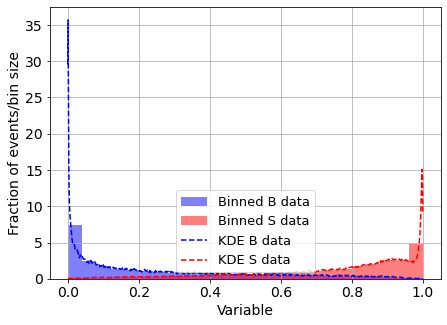

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


BP_tr1 :Z BP1:5.360595492505253
BP_tr1 :Z_std BP1:1.2360033782587923
BP_tr1 :Z_1 BP1:5.357894631022529
BP_tr1 :Z_std_1 BP1:1.2707251326981
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


BP_tr1 :Z BP2:10.80530434867131
BP_tr1 :Z_std BP2:1.7758980143594936
BP_tr1 :Z_1 BP2:10.797070709939563
BP_tr1 :Z_std_1 BP2:1.8570014344990942
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


BP_tr1 :Z BP3:11.327212498678483
BP_tr1 :Z_std BP3:1.8016685107235513
BP_tr1 :Z_1 BP3:11.199329531784494
BP_tr1 :Z_std_1 BP3:1.9753539071274628
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:22<00:00,  2.27s/it]


BP_tr1 :Z BP4:4.702098405951285
BP_tr1 :Z_std BP4:2.640218519483572
BP_tr1 :Z_1 BP4:4.604204595570783
BP_tr1 :Z_std_1 BP4:2.2636508949488965
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]


BP_tr1 :Z BP5:7.149126408215486
BP_tr1 :Z_std BP5:1.119287561228174
BP_tr1 :Z_1 BP5:7.127744766357887
BP_tr1 :Z_std_1 BP5:1.089314563278485
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


BP_tr1 :Z BP6:7.648013585043033
BP_tr1 :Z_std BP6:0.9869025854654494
BP_tr1 :Z_1 BP6:7.590768749087177
BP_tr1 :Z_std_1 BP6:1.0376852331929585
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


BP_tr1 :Z BP7:3.9071350450219753
BP_tr1 :Z_std BP7:1.3611354113148384
BP_tr1 :Z_1 BP7:3.6296301723161326
BP_tr1 :Z_std_1 BP7:1.0391890582107095
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:22<00:00,  2.29s/it]


BP_tr1 :Z BP8:5.005316071955659
BP_tr1 :Z_std BP8:1.2066080428112307
BP_tr1 :Z_1 BP8:4.871954012954531
BP_tr1 :Z_std_1 BP8:1.2951203425623459
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


BP_tr1 :Z BP9:4.9867587084278995
BP_tr1 :Z_std BP9:1.3818038852731291
BP_tr1 :Z_1 BP9:4.977712183730009
BP_tr1 :Z_std_1 BP9:1.313702490372486
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


BP_tr1 :Z BP10:3.2665746940989835
BP_tr1 :Z_std BP10:1.1347390211149677
BP_tr1 :Z_1 BP10:2.92671532819123
BP_tr1 :Z_std_1 BP10:1.00004615840896
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


BP_tr1 :Z BP11:4.282831180766178
BP_tr1 :Z_std BP11:1.1867156359817768
BP_tr1 :Z_1 BP11:3.984615136488769
BP_tr1 :Z_std_1 BP11:1.1033524096801806
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:24<00:00,  2.41s/it]


BP_tr1 :Z BP12:4.28951924571046
BP_tr1 :Z_std BP12:1.0280503432057522
BP_tr1 :Z_1 BP12:4.248084958226038
BP_tr1 :Z_std_1 BP12:0.9476807997237706
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:08<00:00,  1.16it/s]


BP_tr1 :Z BP13:2.257725411127672
BP_tr1 :Z_std BP13:0.6194897791408238
BP_tr1 :Z_1 BP13:2.020065472859682
BP_tr1 :Z_std_1 BP13:0.542834817019685
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]


BP_tr1 :Z BP14:2.2444009478885496
BP_tr1 :Z_std BP14:1.6414205196838232
BP_tr1 :Z_1 BP14:2.1288410214809215
BP_tr1 :Z_std_1 BP14:1.2235594246390116
3 done
4 done


100%|███████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]


BP_tr1 :Z BP15:3.5490543016794938
BP_tr1 :Z_std BP15:1.587528762046561
BP_tr1 :Z_1 BP15:3.356059296526919
BP_tr1 :Z_std_1 BP15:1.33005507388875


In [ ]:
nloops = 5
Z_MLL        = np.zeros((15, 15, nloops))
Z_MLL_std    = np.zeros((15, 15, nloops))
Z_MLL_mu     = np.zeros((15, 15, nloops))
Z_MLL_std_mu = np.zeros((15, 15, nloops))

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []

BPS_analyzed = np.arange(15)

np.random.seed(28890)

for iloop in range(nloops):
    
    print(iloop)
    for bp_i in np.arange(15): # loop for training each BP at a time
        nobs = len(photon_SM)
    
        SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

        df = pd.DataFrame()
        BPS_trained = np.asarray([bp_i])
        
        mask_list = []
        for bp in BPS_trained: # Loop for creating the training set
            nobs_bp = np.min((round(nobs / len(BPS_trained)), len(photon_NP[bp])))
            
            BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = nobs_bp, replace = False)
            mask = np.ones(len(photon_NP[bp]), dtype=bool)
            mask[BP_indices] = False
            mask_list.append( mask )
            if bp == BPS_trained[0]:

                df[lst[0]] = np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][BP_indices,0]])
                df[lst[1]] = np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][BP_indices,1]])
                df[lst[2]] = np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][BP_indices,2]])
                df[lst[3]] = np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][BP_indices,3]])

                df[lst[4]] = np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][BP_indices,0]])
                df[lst[5]] = np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][BP_indices,1]])
                df[lst[6]] = np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][BP_indices,2]])

                df[lst[7]] = np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][BP_indices,0]])
                df[lst[8]] = np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][BP_indices,1]])
                df[lst[9]] = np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][BP_indices,2]])
                df[lst[10]] = np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][BP_indices,3]])
                df[lst[11]] = np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][BP_indices,4]])

                df[lst[12]] = np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][BP_indices,0]])
                df[lst[13]] = np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][BP_indices,2]])

                df[lst[14]] = np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][BP_indices,0]])
                df[lst[15]] = np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][BP_indices,1]])
                df[lst[16]] = np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][BP_indices,2]])

                df[lst[17]] = np.concatenate([ST_SM[SM_indices], ST_NP[bp][BP_indices]])
                df[lst[18]] = np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][BP_indices]])

                df[lst[19]] = np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][BP_indices]])
                df[lst[20]] = np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][BP_indices]])
                df[lst[21]] = np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][BP_indices]])


                df['bkg_flag'] = np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][BP_indices]))) )

                df[lst[22]] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices]))])

                df['bp_flag'] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) ])
            else:
                df_aux = pd.DataFrame()

                df_aux[lst[0]] = photon_NP[bp][BP_indices,0] 
                df_aux[lst[1]] = photon_NP[bp][BP_indices,1] 
                df_aux[lst[2]] = photon_NP[bp][BP_indices,2] 
                df_aux[lst[3]] = photon_NP[bp][BP_indices,3] 

                df_aux[lst[4]] = jet_NP[bp][BP_indices,0] 
                df_aux[lst[5]] = jet_NP[bp][BP_indices,1] 
                df_aux[lst[6]] = jet_NP[bp][BP_indices,2] 

                df_aux[lst[7]] = lepton_NP[bp][BP_indices,0] 
                df_aux[lst[8]] = lepton_NP[bp][BP_indices,1] 
                df_aux[lst[9]] = lepton_NP[bp][BP_indices,2] 
                df_aux[lst[10]] = lepton_NP[bp][BP_indices,3] 
                df_aux[lst[11]] = lepton_NP[bp][BP_indices,4] 

                df_aux[lst[12]] = MET_NP[bp][BP_indices,0] 
                df_aux[lst[13]] = MET_NP[bp][BP_indices,2] 

                df_aux[lst[14]] = hadinfo_NP[bp][BP_indices,0] 
                df_aux[lst[15]] = hadinfo_NP[bp][BP_indices,1] 
                df_aux[lst[16]] = hadinfo_NP[bp][BP_indices,2] 

                df_aux[lst[17]] = ST_NP[bp][BP_indices] 
                df_aux[lst[18]] = MET_sig_NP[bp][BP_indices] 

                df_aux[lst[19]] = mT_photon_NP[bp][BP_indices] 
                df_aux[lst[20]] = mT_jet_NP[bp][BP_indices] 
                df_aux[lst[21]] = mT_lepton_NP[bp][BP_indices] 


                df_aux['bkg_flag'] = np.zeros(len(photon_NP[bp][BP_indices]))

                df_aux[lst[22]] = np.ones(len(photon_NP[bp][BP_indices]))
                df_aux['bp_flag'] = np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) 

                df = pd.concat((df, df_aux))
        df_array = np.asarray(df)


        SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

        df_test = pd.DataFrame()

        for bp in BPS_analyzed: # Loop for creating the testing set
            if bp in BPS_trained:
                mask = mask_list[np.where(BPS_trained == bp)[0][0]]
                mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 75000
            else:
                BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = 15_000, replace = False)
                mask = np.ones(len(photon_NP[bp]), dtype=bool)
                mask[BP_indices] = False
                
            if bp == 0:

                df_test[lst[0]] = np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][mask,0]])
                df_test[lst[1]] = np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][mask,1]])
                df_test[lst[2]] = np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][mask,2]])
                df_test[lst[3]] = np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][mask,3]])

                df_test[lst[4]] = np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][mask,0]])
                df_test[lst[5]] = np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][mask,1]])
                df_test[lst[6]] = np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][mask,2]])

                df_test[lst[7]] = np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][mask,0]])
                df_test[lst[8]] = np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][mask,1]])
                df_test[lst[9]] = np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][mask,2]])
                df_test[lst[10]] = np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][mask,3]])
                df_test[lst[11]] = np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][mask,4]])

                df_test[lst[12]] = np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][mask,0]])
                df_test[lst[13]] = np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][mask,2]])

                df_test[lst[14]] = np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][mask,0]])
                df_test[lst[15]] = np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][mask,1]])
                df_test[lst[16]] = np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][mask,2]])

                df_test[lst[17]] = np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][mask]])
                df_test[lst[18]] = np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][mask]])

                df_test[lst[19]] = np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][mask]])
                df_test[lst[20]] = np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][mask]])
                df_test[lst[21]] = np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][mask]])


                df_test['bkg_flag_pool'] = np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][mask]))) )

                df_test[lst[22]] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask]))])

                df_test['bp_flag'] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask])) * (bp+1) ])

            else:
                df_aux = pd.DataFrame()

                df_aux[lst[0]] = photon_NP[bp][mask,0] 
                df_aux[lst[1]] = photon_NP[bp][mask,1] 
                df_aux[lst[2]] = photon_NP[bp][mask,2] 
                df_aux[lst[3]] = photon_NP[bp][mask,3] 

                df_aux[lst[4]] = jet_NP[bp][mask,0] 
                df_aux[lst[5]] = jet_NP[bp][mask,1] 
                df_aux[lst[6]] = jet_NP[bp][mask,2] 

                df_aux[lst[7]] = lepton_NP[bp][mask,0] 
                df_aux[lst[8]] = lepton_NP[bp][mask,1] 
                df_aux[lst[9]] = lepton_NP[bp][mask,2] 
                df_aux[lst[10]] = lepton_NP[bp][mask,3] 
                df_aux[lst[11]] = lepton_NP[bp][mask,4] 

                df_aux[lst[12]] = MET_NP[bp][mask,0] 
                df_aux[lst[13]] = MET_NP[bp][mask,2] 

                df_aux[lst[14]] = hadinfo_NP[bp][mask,0] 
                df_aux[lst[15]] = hadinfo_NP[bp][mask,1] 
                df_aux[lst[16]] = hadinfo_NP[bp][mask,2] 

                df_aux[lst[17]] = ST_NP[bp][mask] 
                df_aux[lst[18]] = MET_sig_NP[bp][mask] 

                df_aux[lst[19]] = mT_photon_NP[bp][mask] 
                df_aux[lst[20]] = mT_jet_NP[bp][mask] 
                df_aux[lst[21]] = mT_lepton_NP[bp][mask] 


                df_aux['bkg_flag_pool'] = np.zeros(len(photon_NP[bp][mask]))

                df_aux[lst[22]] = np.ones(len(photon_NP[bp][mask]))

                df_aux['bp_flag'] = np.ones(len(photon_NP[bp][mask])) * (bp+1)

                df_test = pd.concat((df_test, df_aux))
        df_test_array = np.asarray(df_test)

        nobs = len(df_array)

        train_size = int(0.80 * nobs)
        val_size   = nobs - train_size #%- test_size 

        random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

        train_indices = random_indices[:train_size]
        val_indices   = random_indices[train_size:]    

        X_train        = df_array[train_indices, :22]
        bkg_flag_train = df_array[train_indices, 22]
        y_mon_train    = df_array[train_indices, -2]

        X_test        = df_test_array[:, :22]
        bkg_flag_test = df_test_array[:, 22]
        y_mon_test    = df_test_array[:, -2]

        X_val        = df_array[val_indices, :22]
        bkg_flag_val = df_array[val_indices, 22]
        y_mon_val    = df_array[val_indices, -2]

        # to normalize
        x_scaler = preprocessing.MinMaxScaler()
        x_scaler = x_scaler.fit(X_train)

        X_mon_train = x_scaler.transform(X_train)
        X_mon_test  = x_scaler.transform(X_test)
        X_mon_val   = x_scaler.transform(X_val)


        # CLASSIFIER
        classifier = XGBClassifier(
            n_estimators  = 500,
            learning_rate = 0.1,
            reg_lambda    = 0.0, reg_alpha = 0.0,
            early_stopping_rounds = 50,#early stopping
            eval_metric = 'logloss',
            gamma = 0.0, objective = 'binary:logistic',
            max_depth = 5)

        # FIT
        classifier.fit(X_mon_train, y_mon_train, 
                       eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                       verbose  = False)

        # PREDICTIONS
        y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

        pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
        pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]


        # Let's estimate the ROC Curve
        nvals = 50
        tpr_total   = np.zeros(nvals) 
        fpr_total   = np.zeros(nvals) 
        tpr_ttgamma = np.zeros(nvals) 
        fpr_ttgamma = np.zeros(nvals) 
        tpr_wgamma  = np.zeros(nvals) 
        fpr_wgamma  = np.zeros(nvals) 
        tpr_wjets   = np.zeros(nvals) 
        fpr_wjets   = np.zeros(nvals) 

        for ith, th in enumerate(np.linspace(0,1, nvals)):
            tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
            tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
            fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
            fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

            tpr_total[ith] = len(tp) / (len(tp) + len(fn))
            fpr_total[ith] = len(fp) / (len(fp) + len(tn))

            tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
            tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
            fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
            fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

            tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
            fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

            tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
            tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
            fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
            fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

            tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
            fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

            tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
            tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
            fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
            fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

            tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
            fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
        auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
        auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
        auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
        auc_total.append( auc(fpr_total, tpr_total) )


        print('AUC:' + str(auc_total[iloop]))
        
        pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp_i+1))[0]]
        NP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 50_000, replace = False)
        SM_indices = np.random.choice(np.arange(len(pred_XG_SM)), size = 50_000, replace = False)

        kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM[SM_indices], pred_XG_NP[NP_indices], 
                                                                                                50000, # Numero de datos para fitear
                                                                                                np.logspace(-4.0, 0.05, 20), 
                                                                                                set_kernel='epanechnikov')
        mask = np.ones(len(pred_XG_SM), dtype=bool)
        mask[SM_indices] = False
        pred_XG_SM = pred_XG_SM[mask]
        print('This may take a while...')

        pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
        print('1 done')
        pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
        print('2 done')

        # Normalize
        pB_B_data = pB_B_data / norm_factor_SM
        pS_B_data = pS_B_data / norm_factor_NP

        # indeces (to later build a random pseudo experiment)
        indices_B = [i for i in range(len(pS_B_data))]
        # loop over the number of pseudo experiments
        #np.random.seed(91218)

        for bp in BPS_analyzed:
            pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
            pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
            print('3 done')
            pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
            print('4 done')

            # Normalize
            pB_S_data = pB_S_data / norm_factor_SM
            pS_S_data = pS_S_data / norm_factor_NP
            indices_S = [i for i in range(len(pS_S_data))]

            muhat_selected_MLL_list = []
            q_muhat_MLL = []
            q_muhat_MLL_mu = []
            for its in tqdm(range(10)):

                # this pseudo-exp has B_rand number of B events
                B_rand = np.random.poisson(int(B_expected))

                ran_ind = np.random.choice(indices_B, B_rand)

                pB_B_data_shuf = []
                pS_B_data_shuf = []

                # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
                for i in ran_ind:
                    pB_B_data_shuf.append(pB_B_data[i])
                    pS_B_data_shuf.append(pS_B_data[i])

                pB_B_data_shuf  = np.array(pB_B_data_shuf)
                pS_B_data_shuf  = np.array(pS_B_data_shuf)

                # this pseudo-exp has S_rand number of S events
                S_rand = np.random.poisson(int(S_expected[bp]))

                ran_ind = np.random.choice(indices_S, S_rand)

                pB_S_data_shuf = []
                pS_S_data_shuf = []

                # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
                for i in ran_ind:
                    pB_S_data_shuf.append(pB_S_data[i])
                    pS_S_data_shuf.append(pS_S_data[i])

                pB_S_data_shuf  = np.array(pB_S_data_shuf)
                pS_S_data_shuf  = np.array(pS_S_data_shuf)

                # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
                prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])
                prob_x_given_B[np.where(prob_x_given_B <= 0)[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0)[0]])
                # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
                prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



                # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

                # approximation: mu_hat=1 (discovery)
                q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



                # ESTIMATE mu_hat for this particular ensemble (implicit equation)
                B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

                # reference points
                sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
                sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


                # we need (implicit eq. for mu_hat) = 1
                # conditions considering the reference points
                if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
                    #print('muhat = 2.1')
                    muhat_selected_MLL = 2.1

                    #print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
                    #print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
                    #print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
                    #print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

                elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
                    #print('muhat = -0.1')
                    muhat_selected_MLL = -0.1

                    #print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
                    #print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
                    #print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
                    #print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

                elif sum_muhat_zero < 1 < sum_muhat_two:
                    #print('muhat ~ 1')

                    # grid, mu_hat is around 1
                    muhat_test = np.arange(0, 2., 0.05)

                    for vv in range(len(muhat_test)):

                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                        if mu_hat_condition_equal_1 > 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break

                elif sum_muhat_two < 1 < sum_muhat_zero:
                    #print('muhat ~ 1')

                    # grid, mu_hat is around 1
                    muhat_test = np.arange(0, 2., 0.05)

                    for vv in range(len(muhat_test)):

                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                        if mu_hat_condition_equal_1 < 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break


                # save the computed mu_hat (within range) for each pseudo_experiment
                muhat_selected_MLL_list.append(muhat_selected_MLL)


                # compute the test statistic for each pseudo_exp considering mu_hat
                if muhat_selected_MLL > 0:
                    q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

                else:
                    q_muhat_MLL.append( 0 )



            # With the calculation of mu_hat
            muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
            Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
            Z_MLL[bp_i, bp,iloop] = Z_MLL_aux
            Z_MLL_std[bp_i, bp,iloop] = np.std(q_muhat_MLL) / (2.*Z_MLL_aux)


            # With the approximation of mu_hat
            Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
            Z_MLL_mu[bp_i, bp,iloop] = Z_MLL_mu_aux
            Z_MLL_std_mu[bp_i, bp,iloop] = np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux)

            print('BP_tr' + str(bp_i + 1) + ' :Z BP' + str(bp+1) + ':' + str(Z_MLL[bp_i,bp,iloop]))
            print('BP_tr' + str(bp_i + 1) + ' :Z_std BP' + str(bp+1) + ':' + str(Z_MLL_std[bp_i,bp,iloop]))
            print('BP_tr' + str(bp_i + 1) + ' :Z_1 BP' + str(bp+1) + ':' + str(Z_MLL_mu[bp_i,bp,iloop]))
            print('BP_tr' + str(bp_i + 1) + ' :Z_std_1 BP' + str(bp+1) + ':' + str(Z_MLL_std_mu[bp_i,bp,iloop]))

# Plots

/tmp/ipykernel_46594/3787724593.py:19: UserWarning: The following kwargs were not used by contour: 'marker'
  contour = plt.contour(xi, yi, zi, levels=[1], alpha=0, colors='blue', linewidths=0, marker='')


(10.0, 40.0)

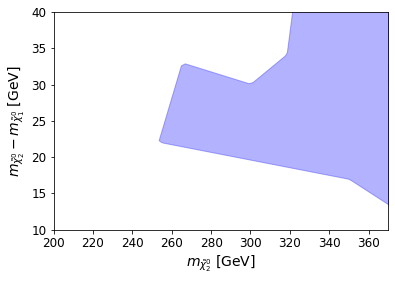

In [18]:

from scipy.interpolate import griddata



x = np.array([200, 200, 200, 250, 250, 250, 300, 300, 300, 300, 350, 350, 350, 350, 400, 400, 400])
y = np.array([34, 19, 10, 37, 22, 13, 40, 39, 24, 15, 41, 26, 17, 10, 43, 27, 18])
f = np.array([0.34, 0.47, 0.09, 0.74, 0.96, 0.19, 0.10, 0.13, 1.6, 0.36, 2.2, 2.5, 1.0, 0.5, 3.2, 3.6, 1.7])


# Creamos una malla regular de puntos (grid) para realizar la interpolación
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)


# Interpolamos los valores f(x, y) en la malla (grid) usando scipy
zi = griddata((x, y), f, (xi, yi), method='linear')

contour = plt.contour(xi, yi, zi, levels=[1], alpha=0, colors='blue', linewidths=0, marker='')

# Extraemos la línea de la curva de nivel f(x,y) = 1
for collection in contour.collections:
    paths = collection.get_paths()
    for path in paths:
        vertices = path.vertices
        x_curve = vertices[:, 0]
        y_curve = vertices[:, 1]
       
plt.fill_betweenx(y_curve, x_curve, 370, alpha=0.3, color='blue')
plt.xlabel(r'$m_{\tilde{\chi}_2^0}$ [GeV]', fontsize=14)
plt.ylabel(r'$m_{\tilde{\chi}_2^0}-m_{\tilde{\chi}_1^0}$ [GeV]', fontsize=14)
plt.xlim(200,370)
plt.ylim(10,40)

In [13]:
m_new = np.linspace(190, 410, 30)
deltam_new = np.linspace(9.5, 45, 30) 

## BP dependent

### MET > 100

In [133]:
#tck_BL0   = interpolate.bisplrep(np.concatenate((m, np.array([200,300,400,200,300,400]))), np.concatenate((deltam, np.array([45,45,45,5,5,5]))), np.concatenate((Z_BL0, np.array([2.0, 1.11, 1.86,12.54,3.83,1.08]))), kx = 1, ky = 1)
tck_BL0   = interpolate.bisplrep(m, deltam, Z_BL0, kx = 1, ky = 1)
Z_BL0_new = interpolate.bisplev(m_new, deltam_new, tck_BL0)
tck_BL0_max   = interpolate.bisplrep(m, deltam, (Z_BL0 + Z_BL0_std), kx = 1, ky = 1)
Z_BL0_new_max = interpolate.bisplev(m_new, deltam_new, tck_BL0_max)
tck_BL0_min   = interpolate.bisplrep(m, deltam, (Z_BL0 - Z_BL0_std), kx = 1, ky = 1)
Z_BL0_new_min = interpolate.bisplev(m_new, deltam_new, tck_BL0_min)

tck_MLL0   = interpolate.bisplrep(np.concatenate((m, np.array([300]))), 
                                  np.concatenate((deltam, np.array([10]))), 
                                  np.concatenate((Z_MLL0, np.array([5]))), kx = 1, ky = 1)
#tck_MLL0   = interpolate.bisplrep(m, deltam, Z_MLL0, kx = 1, ky = 1)
Z_MLL0_new = interpolate.bisplev(m_new, deltam_new, tck_MLL0)
tck_MLL0_max   = interpolate.bisplrep(m, deltam, (Z_MLL0 + Z_MLL0_std), kx = 1, ky = 1)
Z_MLL0_new_max = interpolate.bisplev(m_new, deltam_new, tck_MLL0_max)
tck_MLL0_min   = interpolate.bisplrep(m, deltam, (Z_MLL0 - Z_MLL0_std), kx = 1, ky = 1)
Z_MLL0_new_min = interpolate.bisplev(m_new, deltam_new, tck_MLL0_min)

tck_SCB0   = interpolate.bisplrep(m, deltam, Z_SCB0, kx = 1, ky = 1)
Z_SCB0_new = interpolate.bisplev(m_new, deltam_new, tck_SCB0)
tck_SCB0_max   = interpolate.bisplrep(m, deltam, (Z_SCB0 + Z_SCB0_std), kx = 1, ky = 1)
Z_SCB0_new_max = interpolate.bisplev(m_new, deltam_new, tck_SCB0_max)
tck_SCB0_min   = interpolate.bisplrep(m, deltam, (Z_SCB0 - Z_SCB0_std), kx = 1, ky = 1)
Z_SCB0_new_min = interpolate.bisplev(m_new, deltam_new, tck_SCB0_min)

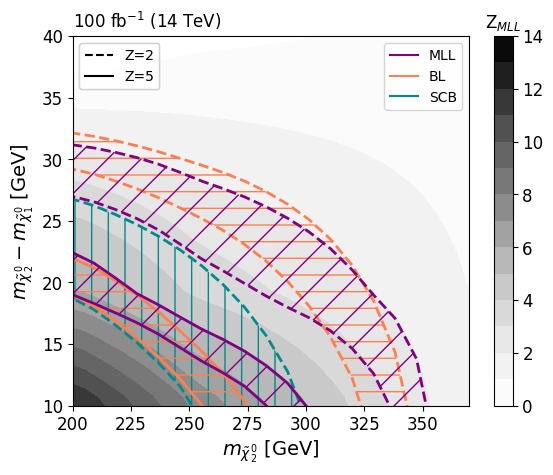

In [136]:
MLL_color = mcolors.to_rgb('purple')
mx = np.linspace(200,375,20)
#plt.contourf(m_new, deltam_new, Z_MLL0_new.T, levels = [0,2,5,16], 
#            colors = ['white', MLL_color + (0.20,), MLL_color + (0.6,)])
#cb = plt.colorbar()
#cb.ax.set_title('Z$_{MLL}$')

#plt.contour(m_new, deltam_new, Z_SCB0_new.T, levels = [-1,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2])
#plt.contour(m_new, deltam_new, Z_BL0_new.T, levels = [-1,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2])
#plt.contour(m_new, deltam_new, Z_MLL0_new.T, levels = [-1,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2])

plt.contourf(m_new, deltam_new, Z_MLL0_new.T, levels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], cmap = 'Grays')
cb = plt.colorbar()
cb.ax.set_title('Z$_{MLL}$')

c0 = plt.contour(m_new, deltam_new, Z_SCB0_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_SCB0_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor ='none', hatch = '|', edgecolor = 'darkcyan', alpha = 1, linewidth = 2, linestyle = '--')

c0 = plt.contour(m_new, deltam_new, Z_BL0_new.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)
cM = plt.contour(m_new, deltam_new, Z_BL0_new_max.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_BL0_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor ='none', hatch ='-', edgecolor = 'coral', alpha = 1, lw = 2)
f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4, fmt = '--')
plt.fill_between(mx, fm(mx), np.nan_to_num(f0(mx), neginf = 45, posinf = 45), facecolor = 'none', hatch ='-', edgecolor = 'coral', alpha = 1, linewidth = 2, linestyle = '--')

c0 = plt.contour(m_new, deltam_new, Z_MLL0_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2],alpha=0)
cM = plt.contour(m_new, deltam_new, Z_MLL0_new_max.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_MLL0_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = MLL_color, alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor = 'none', edgecolor = MLL_color, hatch='/', alpha = 1, linewidth = 2)

f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = MLL_color, alpha = 0.4, fmt = '--')
plt.fill_between(mx, fm(mx), np.nan_to_num(f0(mx), neginf = 45, posinf = 45), facecolor = 'none', hatch='/', edgecolor = MLL_color, alpha = 1, linewidth = 2, linestyle = '--')


#plt.scatter(m, deltam, color = 'red', marker = '*',s=10)

plt.ylim(10,40)
plt.xlim(200,370)

plt.ylabel(r'$m_{\tilde \chi^0_2} - m_{\tilde \chi^0_1}$ [GeV]', fontsize = 14)
plt.xlabel(r'$m_{\tilde \chi_2^0}$ [GeV]', fontsize = 14)
#plt.grid(True)

line_MLL = Line2D([0], [0], label='MLL', color=MLL_color)
line_BL = Line2D([0], [0], label='BL', color='coral')
line_SCB = Line2D([0], [0], label='SCB', color='darkcyan')


# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()

handles.extend([line_MLL, line_BL, line_SCB])
legend0 = plt.legend(handles=handles)
plt.gca().add_artist(legend0)

line_2 = Line2D([0], [0], label='Z=2', color='black', linestyle = 'dashed')
line_5 = Line2D([0], [0], label='Z=5', color='black', linestyle = 'solid')

legend1 = plt.legend([line_2, line_5], ["Z=2", "Z=5"], loc=2)
plt.gca().add_artist(legend1)

plt.title('$100$ fb$^{-1}$ (14 TeV)', loc = 'left')
plt.savefig('../graph/contour_plot_BPdep_NEW.pdf', bbox_inches="tight")

### MET > 200

In [73]:
#tck_BL0_MET200   = interpolate.bisplrep(np.concatenate((m, np.array([200,300,400,200,300,400]))), np.concatenate((deltam, np.array([45,45,45,5,5,5]))), np.concatenate((Z_BL0_MET200, np.array([2.0, 1.11, 1.86,12.54,3.83,1.08]))), kx = 1, ky = 1)
tck_BL0_MET200   = interpolate.bisplrep(m, deltam, Z_BL0_MET200, kx = 1, ky = 1)
Z_BL0_MET200_new = interpolate.bisplev(m_new, deltam_new, tck_BL0_MET200)
tck_BL0_MET200_max   = interpolate.bisplrep(m, deltam, (Z_BL0_MET200 + Z_BL0_MET200_std), kx = 1, ky = 1)
Z_BL0_MET200_new_max = interpolate.bisplev(m_new, deltam_new, tck_BL0_MET200_max)
tck_BL0_MET200_min   = interpolate.bisplrep(m, deltam, (Z_BL0_MET200 - Z_BL0_MET200_std), kx = 1, ky = 1)
Z_BL0_MET200_new_min = interpolate.bisplev(m_new, deltam_new, tck_BL0_MET200_min)

#tck_MLL0_MET200   = interpolate.bisplrep(np.concatenate((m, np.array([200,300,400]))), np.concatenate((deltam, np.array([5,5,5]))), np.concatenate((Z_MLL0_MET200, np.array([15.8, 5.23, 1.55]))), kx = 1, ky = 1)
tck_MLL0_MET200   = interpolate.bisplrep(m, deltam, Z_MLL0_MET200, kx = 1, ky = 1)
Z_MLL0_MET200_new = interpolate.bisplev(m_new, deltam_new, tck_MLL0_MET200)
tck_MLL0_MET200_max   = interpolate.bisplrep(m, deltam, (Z_MLL0_MET200 + Z_MLL0_MET200_std), kx = 1, ky = 1)
Z_MLL0_MET200_new_max = interpolate.bisplev(m_new, deltam_new, tck_MLL0_MET200_max)
tck_MLL0_MET200_min   = interpolate.bisplrep(m, deltam, (Z_MLL0_MET200 - Z_MLL0_MET200_std), kx = 1, ky = 1)
Z_MLL0_MET200_new_min = interpolate.bisplev(m_new, deltam_new, tck_MLL0_MET200_min)

tck_SCB0_MET200   = interpolate.bisplrep(m, deltam, Z_SCB0_MET200, kx = 1, ky = 1)
Z_SCB0_MET200_new = interpolate.bisplev(m_new, deltam_new, tck_SCB0_MET200)
tck_SCB0_MET200_max   = interpolate.bisplrep(m, deltam, (Z_SCB0_MET200 + Z_SCB0_std), kx = 1, ky = 1)
Z_SCB0_MET200_new_max = interpolate.bisplev(m_new, deltam_new, tck_SCB0_MET200_max)
tck_SCB0_MET200_min   = interpolate.bisplrep(m, deltam, (Z_SCB0_MET200 - Z_SCB0_MET200_std), kx = 1, ky = 1)
Z_SCB0_MET200_new_min = interpolate.bisplev(m_new, deltam_new, tck_SCB0_MET200_min)

Text(0.0, 1.0, '$100$ fb$^{-1}$ (14 TeV)')

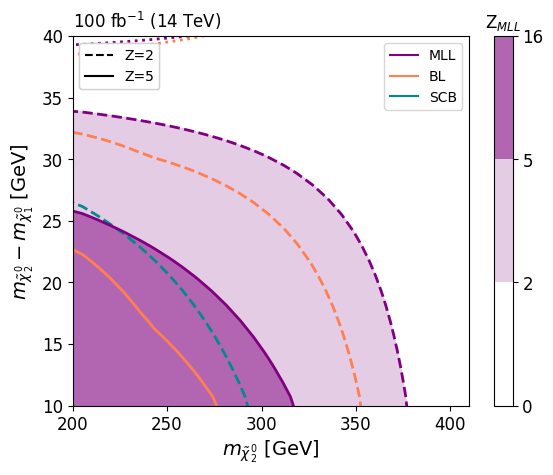

In [74]:
MLL_color = mcolors.to_rgb('purple')

#plt.contourf(m_new, deltam_new, Z_MLL0_new.T, levels = [0,2,5,16], 
#            colors = ['white', MLL_color + (0.20,), MLL_color + (0.6,)])
#cb = plt.colorbar()
#cb.ax.set_title('Z$_{MLL}$')

#plt.contour(m_new, deltam_new, Z_SCB0_new.T, levels = [-1,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2])
#plt.contour(m_new, deltam_new, Z_BL0_new.T, levels = [-1,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2])
#plt.contour(m_new, deltam_new, Z_MLL0_new.T, levels = [-1,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2])

plt.contourf(m_new, deltam_new, Z_MLL0_MET200_new.T, levels = [0,2,5,16], 
            colors = ['white', MLL_color + (0.20,), MLL_color + (0.6,)]            )
cb = plt.colorbar()
cb.ax.set_title('Z$_{MLL}$')
plt.contour(m_new, deltam_new, Z_SCB0_MET200_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2])
plt.contour(m_new, deltam_new, Z_BL0_MET200_new.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2])
plt.contour(m_new, deltam_new, Z_MLL0_MET200_new.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2])

#plt.legend()
#plt.contourf(m_new, deltam_new, Z_MLL0_new, levels = [0,2,5,200], 
#            linestyles = ['dashed','solid'], colors = ['black','red','blue'], linewidths = [2])
#plt.scatter(m, deltam, color = 'red', marker = '*',s=10)

plt.ylim(10,40)
plt.xlim(200,410)

plt.ylabel(r'$m_{\tilde \chi^0_2} - m_{\tilde \chi^0_1}$ [GeV]', fontsize = 14)
plt.xlabel(r'$m_{\tilde \chi_2^0}$ [GeV]', fontsize = 14)
#plt.grid(True)

line_MLL = Line2D([0], [0], label='MLL', color=MLL_color)
line_BL = Line2D([0], [0], label='BL', color='coral')
line_SCB = Line2D([0], [0], label='SCB', color='darkcyan')


# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()

handles.extend([line_MLL, line_BL, line_SCB])
legend0 = plt.legend(handles=handles)
plt.gca().add_artist(legend0)

line_2 = Line2D([0], [0], label='Z=2', color='black', linestyle = 'dashed')
line_5 = Line2D([0], [0], label='Z=5', color='black', linestyle = 'solid')

legend1 = plt.legend([line_2, line_5], ["Z=2", "Z=5"], loc=2)
plt.gca().add_artist(legend1)

plt.title('$100$ fb$^{-1}$ (14 TeV)', loc = 'left')
#plt.savefig('../graph/contour_plot_purple_MET200_NEW.pdf', bbox_inches="tight")

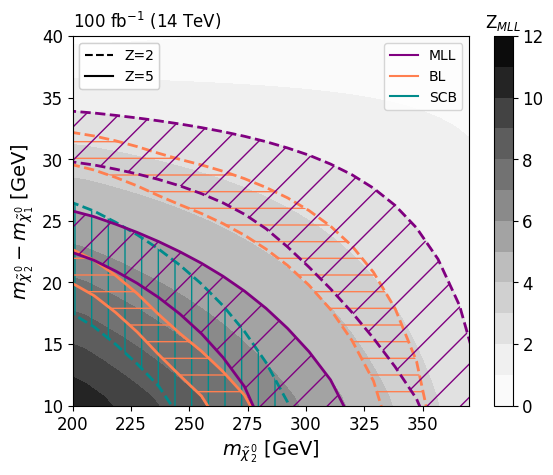

In [116]:
MLL_color = mcolors.to_rgb('purple')
mx = np.linspace(200,375,20)
#plt.contourf(m_new, deltam_new, Z_MLL0_new.T, levels = [0,2,5,16], 
#            colors = ['white', MLL_color + (0.20,), MLL_color + (0.6,)])
#cb = plt.colorbar()
#cb.ax.set_title('Z$_{MLL}$')

#plt.contour(m_new, deltam_new, Z_SCB0_new.T, levels = [-1,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2])
#plt.contour(m_new, deltam_new, Z_BL0_new.T, levels = [-1,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2])
#plt.contour(m_new, deltam_new, Z_MLL0_new.T, levels = [-1,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2])

plt.contourf(m_new, deltam_new, Z_MLL0_MET200_new.T, levels = [0,1,2,3,4,5,6,7,8,9,10,11,12], cmap = 'Grays')
cb = plt.colorbar()
cb.ax.set_title('Z$_{MLL}$')

c0 = plt.contour(m_new, deltam_new, Z_SCB0_MET200_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_SCB0_MET200_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor ='none', hatch = '|', edgecolor = 'darkcyan', alpha = 1, linewidth = 2, linestyle = '--')

c0 = plt.contour(m_new, deltam_new, Z_BL0_MET200_new.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)
cM = plt.contour(m_new, deltam_new, Z_BL0_MET200_new_max.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_BL0_MET200_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor ='none', hatch ='-', edgecolor = 'coral', alpha = 1, lw = 2)
f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4, fmt = '--')
plt.fill_between(mx, fm(mx), np.nan_to_num(f0(mx), neginf = 45, posinf = 45), facecolor = 'none', hatch ='-', edgecolor = 'coral', alpha = 1, linewidth = 2, linestyle = '--')

c0 = plt.contour(m_new, deltam_new, Z_MLL0_MET200_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2],alpha=0)
cM = plt.contour(m_new, deltam_new, Z_MLL0_MET200_new_max.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_MLL0_MET200_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = MLL_color, alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor = 'none', edgecolor = MLL_color, hatch='/', alpha = 1, linewidth = 2)

f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = MLL_color, alpha = 0.4, fmt = '--')
plt.fill_between(mx, fm(mx), np.nan_to_num(f0(mx), neginf = 45, posinf = 45), facecolor = 'none', hatch='/', edgecolor = MLL_color, alpha = 1, linewidth = 2, linestyle = '--')


#plt.scatter(m, deltam, color = 'red', marker = '*',s=10)

plt.ylim(10,40)
plt.xlim(200,370)

plt.ylabel(r'$m_{\tilde \chi^0_2} - m_{\tilde \chi^0_1}$ [GeV]', fontsize = 14)
plt.xlabel(r'$m_{\tilde \chi_2^0}$ [GeV]', fontsize = 14)
#plt.grid(True)

line_MLL = Line2D([0], [0], label='MLL', color=MLL_color)
line_BL = Line2D([0], [0], label='BL', color='coral')
line_SCB = Line2D([0], [0], label='SCB', color='darkcyan')


# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()

handles.extend([line_MLL, line_BL, line_SCB])
legend0 = plt.legend(handles=handles)
plt.gca().add_artist(legend0)

line_2 = Line2D([0], [0], label='Z=2', color='black', linestyle = 'dashed')
line_5 = Line2D([0], [0], label='Z=5', color='black', linestyle = 'solid')

legend1 = plt.legend([line_2, line_5], ["Z=2", "Z=5"], loc=2)
plt.gca().add_artist(legend1)

plt.title('$100$ fb$^{-1}$ (14 TeV)', loc = 'left')
plt.savefig('../graph/contour_plot_BPdep_MET200_NEW.pdf', bbox_inches="tight")

Text(0.0, 1.0, '$100$ fb$^{-1}$ (14 TeV)')

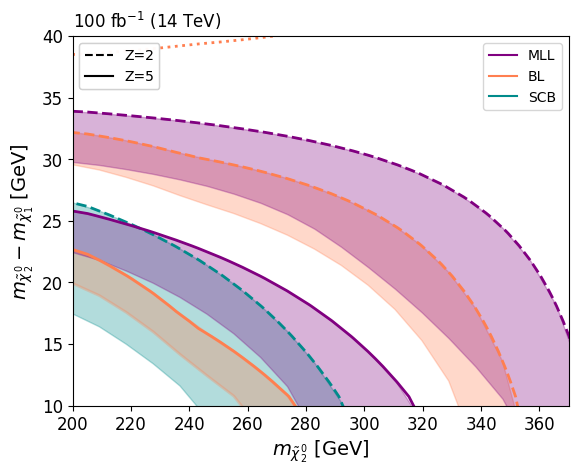

In [117]:
MLL_color = mcolors.to_rgb('purple')
mx = np.linspace(200,375,20)

#plt.contourf(m_new, deltam_new, Z_MLL0_MET200_new.T, levels = [0,1,2,3,4,5,6,7,8,9,10,11,12], cmap = 'Grays')
#cb = plt.colorbar()
#cb.ax.set_title('Z$_{MLL}$')
c0 = plt.contour(m_new, deltam_new, Z_SCB0_MET200_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2])
cm = plt.contour(m_new, deltam_new, Z_SCB0_MET200_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor ='darkcyan', edgecolor = 'darkcyan', alpha = 0.3)

c0 = plt.contour(m_new, deltam_new, Z_BL0_MET200_new.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2])
cM = plt.contour(m_new, deltam_new, Z_BL0_MET200_new_max.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_BL0_MET200_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor ='coral', edgecolor = 'coral', alpha = 0.3, lw = 2)
f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4, fmt = '--')
plt.fill_between(mx, fm(mx), np.nan_to_num(f0(mx), neginf = 45, posinf = 45), facecolor = 'coral', edgecolor = 'coral', alpha = 0.3)

c0 = plt.contour(m_new, deltam_new, Z_MLL0_MET200_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2])
cM = plt.contour(m_new, deltam_new, Z_MLL0_MET200_new_max.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_MLL0_MET200_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = MLL_color, alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor = MLL_color, edgecolor = MLL_color, alpha = 0.3)

f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = MLL_color, alpha = 0.4, fmt = '--')
plt.fill_between(mx, fm(mx), np.nan_to_num(f0(mx), neginf = 45, posinf = 45), facecolor = MLL_color, edgecolor = MLL_color, alpha = 0.3)


#plt.scatter(m, deltam, color = 'red', marker = '*',s=10)

plt.ylim(10,40)
plt.xlim(200,370)

plt.ylabel(r'$m_{\tilde \chi^0_2} - m_{\tilde \chi^0_1}$ [GeV]', fontsize = 14)
plt.xlabel(r'$m_{\tilde \chi_2^0}$ [GeV]', fontsize = 14)
#plt.grid(True)

line_MLL = Line2D([0], [0], label='MLL', color=MLL_color)
line_BL = Line2D([0], [0], label='BL', color='coral')
line_SCB = Line2D([0], [0], label='SCB', color='darkcyan')


# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()

handles.extend([line_MLL, line_BL, line_SCB])
legend0 = plt.legend(handles=handles)
plt.gca().add_artist(legend0)

line_2 = Line2D([0], [0], label='Z=2', color='black', linestyle = 'dashed')
line_5 = Line2D([0], [0], label='Z=5', color='black', linestyle = 'solid')

legend1 = plt.legend([line_2, line_5], ["Z=2", "Z=5"], loc=2)
plt.gca().add_artist(legend1)

plt.title('$100$ fb$^{-1}$ (14 TeV)', loc = 'left')
#plt.savefig('../graph/contour_plot_purple_MET200_NEW.pdf', bbox_inches="tight")

## BP Independent

### MET > 100

In [14]:
tck_dm = interpolate.bisplrep(m, deltam, dm_rd, kx = 3, ky = 2)
dm_new = interpolate.bisplev(m_new, deltam_new, tck_dm)

In [15]:
i = 0
deltam_min = []
deltam_max = []
dm0_new = []
for i in range(5):
    tck_dm = interpolate.interp1d(x = deltam[(i*3):((i+1)*3)], y = dm_rd[(i*3):((i+1)*3)], kind = 'linear', fill_value='extrapolate')
    aux = tck_dm(deltam_new)
    deltam_min.append( deltam_new[np.argmin(np.abs(aux - 0.10))] )
    deltam_max.append( deltam_new[np.argmin(np.abs(aux - 0.14))] )
    dm0_new.append( m[i*3] )

In [16]:
dm_planck = 0.12
sd_planck = 0.02

In [17]:
tck_BL1   = interpolate.bisplrep(m, deltam, Z_BL1, kx = 1, ky = 1)
Z_BL1_new = interpolate.bisplev(m_new, deltam_new, tck_BL1)
tck_BL1_max   = interpolate.bisplrep(m, deltam, (Z_BL1 + Z_BL1_std), kx = 1, ky = 1)
Z_BL1_new_max = interpolate.bisplev(m_new, deltam_new, tck_BL1_max)
tck_BL1_min   = interpolate.bisplrep(m, deltam, (Z_BL1 - Z_BL1_std), kx = 1, ky = 1)
Z_BL1_new_min = interpolate.bisplev(m_new, deltam_new, tck_BL1_min)

#tck_MLL1   = interpolate.bisplrep(np.concatenate((m, np.array([300]))), 
                                  #np.concatenate((deltam, np.array([10]))), 
                                  #np.concatenate((Z_MLL1, np.array([5]))), kx = 1, ky = 1)
tck_MLL1   = interpolate.bisplrep(m, deltam, Z_MLL1, kx = 1, ky = 1)
Z_MLL1_new = interpolate.bisplev(m_new, deltam_new, tck_MLL1)
tck_MLL1_max   = interpolate.bisplrep(m, deltam, (Z_MLL1 + Z_MLL1_std), kx = 1, ky = 1)
Z_MLL1_new_max = interpolate.bisplev(m_new, deltam_new, tck_MLL1_max)
tck_MLL1_min   = interpolate.bisplrep(m, deltam, (Z_MLL1 - Z_MLL1_std), kx = 1, ky = 1)
Z_MLL1_new_min = interpolate.bisplev(m_new, deltam_new, tck_MLL1_min)

tck_SCB1   = interpolate.bisplrep(m, deltam, Z_SCB1, kx = 1, ky = 1)
Z_SCB1_new = interpolate.bisplev(m_new, deltam_new, tck_SCB1)
tck_SCB1_max   = interpolate.bisplrep(m, deltam, (Z_SCB1 + Z_SCB1_std), kx = 1, ky = 1)
Z_SCB1_new_max = interpolate.bisplev(m_new, deltam_new, tck_SCB1_max)
tck_SCB1_min   = interpolate.bisplrep(m, deltam, (Z_SCB1 - Z_SCB1_std), kx = 1, ky = 1)
Z_SCB1_new_min = interpolate.bisplev(m_new, deltam_new, tck_SCB1_min)

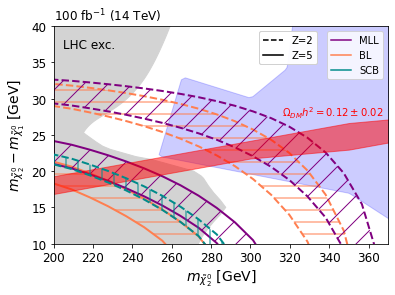

In [21]:
MLL_color = mcolors.to_rgb('purple')
mx = np.linspace(200,375,20)


#plt.contourf(m_new, deltam_new, Z_MLL1_new.T, levels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], cmap = 'Greys')
#cb = plt.colorbar()
#cb.ax.set_title('Z$_{MLL}$')

ind = np.argsort(ATLAS[:,3])
plt.fill_betweenx(y = ATLAS[ind,3], x1 = ATLAS[ind,0], color = 'lightgray', alpha = 1)
ind = np.argsort(CMS[:,3])
plt.fill_betweenx(y = CMS[ind,3], x1 = CMS[ind,0], color = 'lightgray', alpha = 1)

c0 = plt.contour(m_new, deltam_new, Z_SCB1_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 0, zorder = 4)
cm = plt.contour(m_new, deltam_new, Z_SCB1_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 0, zorder = 4)

f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor ='none', hatch = '|', edgecolor = 'darkcyan', alpha = 1, linewidth = 2, linestyle = '--', zorder = 4)

c0 = plt.contour(m_new, deltam_new, Z_BL1_new.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)
cM = plt.contour(m_new, deltam_new, Z_BL1_new_max.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_BL1_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor ='none', hatch ='-', edgecolor = 'coral', alpha = 1, lw = 2)
f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4, fmt = '--')
plt.fill_between(mx, fm(mx), np.nan_to_num(f0(mx), neginf = 45, posinf = 45), facecolor = 'none', hatch ='-', edgecolor = 'coral', alpha = 1, linewidth = 2, linestyle = '--')

c0 = plt.contour(m_new, deltam_new, Z_MLL1_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2],alpha=0)
cM = plt.contour(m_new, deltam_new, Z_MLL1_new_max.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_MLL1_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = MLL_color, alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor = 'none', edgecolor = MLL_color, hatch='/', alpha = 1, linewidth = 2)

f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = MLL_color, alpha = 0.4, fmt = '--')
plt.fill_between(mx, fm(mx), np.nan_to_num(f0(mx), neginf = 45, posinf = 45), facecolor = 'none', hatch='/', edgecolor = MLL_color, alpha = 1, linewidth = 2, linestyle = '--')

#plt.contour(m_new, deltam_new, dm_new.T, levels = [-10, (dm_planck - sd_planck),(dm_planck + sd_planck),15], colors = ['red'], zorder = 8)
plt.text(316, 27.5, '$\Omega_{DM}h^{2} = 0.12 \pm 0.02$', color = 'red')
#plt.plot(dm0_new, deltam_min, color = 'red')
#plt.plot(dm0_new, deltam_max, color = 'red')
plt.fill_between(dm0_new, deltam_min, deltam_max, color = 'red', zorder = 1, alpha = 0.5)
#plt.scatter(m, deltam, color = 'red', marker = '*',s=10)

plt.ylim(10,40)
plt.xlim(200,370)

plt.ylabel(r'$m_{\tilde \chi^0_2} - m_{\tilde \chi^0_1}$ [GeV]', fontsize = 14)
plt.xlabel(r'$m_{\tilde \chi_2^0}$ [GeV]', fontsize = 14)
#plt.grid(True)

line_MLL = Line2D([0], [0], label='MLL', color=MLL_color)
line_BL = Line2D([0], [0], label='BL', color='coral')
line_SCB = Line2D([0], [0], label='SCB', color='darkcyan')


# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()

handles.extend([line_MLL, line_BL, line_SCB])
legend0 = plt.legend(handles=handles)
plt.gca().add_artist(legend0)

line_2 = Line2D([0], [0], label='Z=2', color='black', linestyle = 'dashed')
line_5 = Line2D([0], [0], label='Z=5', color='black', linestyle = 'solid')

legend1 = plt.legend([line_2, line_5], ["Z=2", "Z=5"], loc=2, bbox_to_anchor=(0.6,1))
plt.gca().add_artist(legend1)

plt.text(205, 37, 'LHC exc.', fontsize = 12)
plt.title('$100$ fb$^{-1}$ (14 TeV)', loc = 'left')

plt.fill_betweenx(y_curve, x_curve, 370, alpha=0.2, color='blue', zorder = 0)

plt.savefig('../graph/contour_plot_BPind_NEW.pdf', bbox_inches="tight")

### MET > 200

In [22]:
Z_MLL1_MET200_std[12] = 1.2

In [23]:
tck_BL1_MET200   = interpolate.bisplrep(m, deltam, Z_BL1_MET200, kx = 1, ky = 1)
Z_BL1_MET200_new = interpolate.bisplev(m_new, deltam_new, tck_BL1_MET200)
tck_BL1_MET200_max   = interpolate.bisplrep(m, deltam, (Z_BL1_MET200 + Z_BL1_MET200_std), kx = 1, ky = 1)
Z_BL1_MET200_new_max = interpolate.bisplev(m_new, deltam_new, tck_BL1_MET200_max)
tck_BL1_MET200_min   = interpolate.bisplrep(m, deltam, (Z_BL1_MET200 - Z_BL1_MET200_std), kx = 1, ky = 1)
Z_BL1_MET200_new_min = interpolate.bisplev(m_new, deltam_new, tck_BL1_MET200_min)

tck_MLL1_MET200   = interpolate.bisplrep(m, deltam, Z_MLL1_MET200, kx = 1, ky = 1)
Z_MLL1_MET200_new = interpolate.bisplev(m_new, deltam_new, tck_MLL1_MET200)
tck_MLL1_MET200_max   = interpolate.bisplrep(m, deltam, (Z_MLL1_MET200 + Z_MLL1_MET200_std), kx = 1, ky = 1)
Z_MLL1_MET200_new_max = interpolate.bisplev(m_new, deltam_new, tck_MLL1_MET200_max)
tck_MLL1_MET200_min   = interpolate.bisplrep(m, deltam, (Z_MLL1_MET200 - Z_MLL1_MET200_std), kx = 1, ky = 1)
Z_MLL1_MET200_new_min = interpolate.bisplev(m_new, deltam_new, tck_MLL1_MET200_min)

tck_SCB1_MET200   = interpolate.bisplrep(m, deltam, Z_SCB1_MET200, kx = 1, ky = 1)
Z_SCB1_MET200_new = interpolate.bisplev(m_new, deltam_new, tck_SCB1_MET200)
tck_SCB1_MET200_max   = interpolate.bisplrep(m, deltam, (Z_SCB1_MET200 + Z_SCB1_std), kx = 1, ky = 1)
Z_SCB1_MET200_new_max = interpolate.bisplev(m_new, deltam_new, tck_SCB1_MET200_max)
tck_SCB1_MET200_min   = interpolate.bisplrep(m, deltam, (Z_SCB1_MET200 - Z_SCB1_MET200_std), kx = 1, ky = 1)
Z_SCB1_MET200_new_min = interpolate.bisplev(m_new, deltam_new, tck_SCB1_MET200_min)

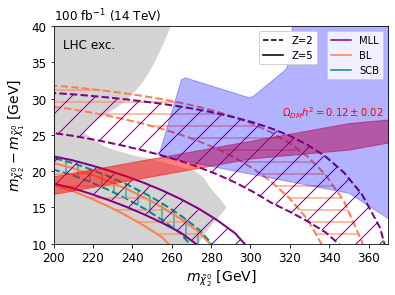

In [24]:
MLL_color = mcolors.to_rgb('purple')
mx = np.linspace(200,375,20)

#plt.contourf(m_new, deltam_new, Z_MLL1_MET200_new.T, levels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], cmap = 'Grays')
#cb = plt.colorbar()
#cb.ax.set_title('Z$_{MLL}$')


ind = np.argsort(ATLAS[:,3])
plt.fill_betweenx(y = ATLAS[ind,3], x1 = ATLAS[ind,0], color = 'lightgray', alpha = 1)
ind = np.argsort(CMS[:,3])
plt.fill_betweenx(y = CMS[ind,3], x1 = CMS[ind,0], color = 'lightgray', alpha = 1)

c0 = plt.contour(m_new, deltam_new, Z_SCB1_MET200_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_SCB1_MET200_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor ='none', hatch = '|', edgecolor = 'darkcyan', alpha = 1, linewidth = 2, linestyle = '--')

c0 = plt.contour(m_new, deltam_new, Z_BL1_MET200_new.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)
cM = plt.contour(m_new, deltam_new, Z_BL1_MET200_new_max.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_BL1_MET200_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor ='none', hatch ='-', edgecolor = 'coral', alpha = 1, lw = 2)
f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = 'coral', alpha = 0.4, fmt = '--')
plt.fill_between(mx, fm(mx), np.nan_to_num(f0(mx), neginf = 45, posinf = 45), facecolor = 'none', hatch ='-', edgecolor = 'coral', alpha = 1, linewidth = 2, linestyle = '--')

c0 = plt.contour(m_new, deltam_new, Z_MLL1_MET200_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2],alpha=0)
cM = plt.contour(m_new, deltam_new, Z_MLL1_MET200_new_max.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)
cm = plt.contour(m_new, deltam_new, Z_MLL1_MET200_new_min.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)

f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = MLL_color, alpha = 0.4)
plt.fill_between(mx, fm(mx), f0(mx), facecolor = 'none', edgecolor = MLL_color, hatch='/', alpha = 1, linewidth = 2)

f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#plt.errorbar(mx, y = f0(mx), yerr = [np.abs(fm(mx) - f0(mx)), np.abs(fM(mx) - f0(mx))], color = MLL_color, alpha = 0.4, fmt = '--')
plt.fill_between(mx, fm(mx), np.nan_to_num(f0(mx), neginf = 45, posinf = 45), facecolor = 'none', hatch='/', edgecolor = MLL_color, alpha = 1, linewidth = 2, linestyle = '--')

#plt.contour(m_new, deltam_new, dm_new.T, levels = [-10, (dm_planck - sd_planck),(dm_planck + sd_planck),15], colors = ['red'], zorder = 8)
plt.text(316, 27.5, '$\Omega_{DM}h^{2} = 0.12 \pm 0.02$', color = 'red')
#plt.plot(dm0_new, deltam_min, color = 'red')
#plt.plot(dm0_new, deltam_max, color = 'red')
plt.fill_between(dm0_new, deltam_min, deltam_max, color = 'red', zorder = 1, alpha = 0.5)
#plt.scatter(m, deltam, color = 'red', marker = '*',s=10)

#plt.scatter(m, deltam, color = 'red', marker = '*',s=10)

plt.ylim(10,40)
plt.xlim(200,370)

plt.ylabel(r'$m_{\tilde \chi^0_2} - m_{\tilde \chi^0_1}$ [GeV]', fontsize = 14)
plt.xlabel(r'$m_{\tilde \chi_2^0}$ [GeV]', fontsize = 14)
#plt.grid(True)

line_MLL = Line2D([0], [0], label='MLL', color=MLL_color)
line_BL = Line2D([0], [0], label='BL', color='coral')
line_SCB = Line2D([0], [0], label='SCB', color='darkcyan')


# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()

handles.extend([line_MLL, line_BL, line_SCB])
legend0 = plt.legend(handles=handles)
plt.gca().add_artist(legend0)

line_2 = Line2D([0], [0], label='Z=2', color='black', linestyle = 'dashed')
line_5 = Line2D([0], [0], label='Z=5', color='black', linestyle = 'solid')

legend1 = plt.legend([line_2, line_5], ["Z=2", "Z=5"], loc=2, bbox_to_anchor = (0.6,1))
plt.gca().add_artist(legend1)

plt.fill_betweenx(y_curve, x_curve, 370, alpha=0.3, color='blue')

plt.text(205, 37, 'LHC exc.', fontsize = 12)

plt.title('$100$ fb$^{-1}$ (14 TeV)', loc = 'left')
plt.savefig('../graph/contour_plot_BPind_MET200_NEW.pdf', bbox_inches="tight")

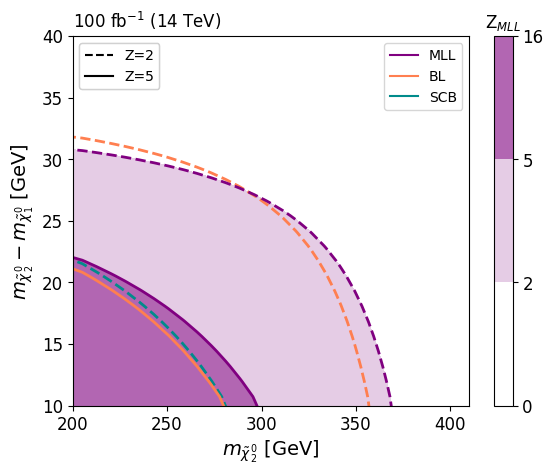

In [36]:
MLL_color = mcolors.to_rgb('purple')

#plt.contourf(m_new, deltam_new, Z_MLL1_new.T, levels = [0,2,5,16], 
#            colors = ['white', MLL_color + (0.20,), MLL_color + (0.6,)])
#cb = plt.colorbar()
#cb.ax.set_title('Z$_{MLL}$')


#plt.contour(m_new, deltam_new, Z_SCB1_new.T, levels = [-1,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2])
#plt.contour(m_new, deltam_new, Z_BL1_new.T, levels = [-1,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2])
#plt.contour(m_new, deltam_new, Z_MLL1_new.T, levels = [-1,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2])

plt.contourf(m_new, deltam_new, Z_MLL1_MET200_new.T, levels = [0,2,5,16], 
            colors = ['white', MLL_color + (0.20,), MLL_color + (0.6,)])
cb = plt.colorbar()
cb.ax.set_title('Z$_{MLL}$')
plt.contour(m_new, deltam_new, Z_SCB1_MET200_new.T, levels = [-2,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2])
plt.contour(m_new, deltam_new, Z_BL1_MET200_new.T, levels = [-2,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2])
plt.contour(m_new, deltam_new, Z_MLL1_MET200_new.T, levels = [-2,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2])

#plt.legend()
#plt.contourf(m_new, deltam_new, Z_MLL0_new, levels = [0,2,5,200], 
#            linestyles = ['dashed','solid'], colors = ['black','red','blue'], linewidths = [2])
#plt.scatter(m, deltam, color = 'red', marker = '*',s=10)

plt.ylim(10,40)
plt.xlim(200,410)

plt.ylabel(r'$m_{\tilde \chi^0_2} - m_{\tilde \chi^0_1}$ [GeV]', fontsize = 14)
plt.xlabel(r'$m_{\tilde \chi_2^0}$ [GeV]', fontsize = 14)
#plt.grid(True)

line_MLL = Line2D([0], [0], label='MLL', color=MLL_color)
line_BL = Line2D([0], [0], label='BL', color='coral')
line_SCB = Line2D([0], [0], label='SCB', color='darkcyan')


# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()

handles.extend([line_MLL, line_BL, line_SCB])
legend0 = plt.legend(handles=handles)
plt.gca().add_artist(legend0)

line_2 = Line2D([0], [0], label='Z=2', color='black', linestyle = 'dashed')
line_5 = Line2D([0], [0], label='Z=5', color='black', linestyle = 'solid')

legend1 = plt.legend([line_2, line_5], ["Z=2", "Z=5"], loc=2)
plt.gca().add_artist(legend1)

plt.title('$100$ fb$^{-1}$ (14 TeV)', loc = 'left')
plt.savefig('../graph/contour_plot_purple_AllBPs_MET200_NEW.pdf', bbox_inches="tight")